# Summarize models

This notebook summarizes all metrics required for model comparison including the following:

  1. Standardized predictor distributions
  1. Model residuals by predictor
  1. Forecast errors overall and by timepoint
  1. Model coefficients averages and by timepoint
  
## Table of contents

 1. [Import and define functions](#Import-and-define-functions)
 1. [Define configuration settings](#Define-configuration-settings)
 1. [Load data](#Load-data)
 1. [Summarize raw predictors](#Summarize-raw-predictors)
 1. [Summarize standardized predictor distributions](#Summarize-standardized-predictor-distributions)
 1. [Summarize model residuals](#Summarize-model-residuals)
 1. [Summarize observed and predicted frequencies and growth rates](#Summarize-observed-and-predicted-frequencies-and-growth-rates)
 1. [Summarize model forecasting error](#Summarize-model-forecasting-error)

## Import and define functions

In [181]:
import Bio.SeqIO
from collections import defaultdict
import glob
import json
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import networkx as nx
import numpy as np
import pandas as pd
from scipy.stats import pearsonr
import seaborn as sns

%matplotlib inline

In [182]:
#sns.set_style("ticks")
plt.style.use("huddlej")

In [183]:
mpl.rcParams['savefig.dpi'] = 200
mpl.rcParams['figure.dpi'] = 200
mpl.rcParams['font.weight'] = 300
mpl.rcParams['axes.labelweight'] = 300
mpl.rcParams['font.size'] = 18

In [184]:
!pwd

/Users/jlhudd/projects/nextstrain/flu-forecasting/analyses


In [185]:
def mean_absolute_error(observed, estimated, **kwargs):
    """
    Calculates the mean absolute error between observed and estimated values.

    Parameters
    ----------
    observed : numpy.ndarray
        observed values

    estimated : numpy.ndarray
        estimated values

    Returns
    -------
    float :
        mean absolute error between observed and estimated values
    """
    return np.mean(np.abs(observed - estimated))

def root_mean_square_error(observed, estimated, **kwargs):
    """
    Calculates the root mean square error between observed and estimated values.

    Parameters
    ----------
    observed : numpy.ndarray
        observed values

    estimated : numpy.ndarray
        estimated values

    Returns
    -------
    float :
        root mean square error between observed and estimated values
    """
    return np.sqrt(np.mean((observed - estimated) ** 2))

def mean_square_error(observed, estimated, **kwargs):
    """
    Calculates the mean square error between observed and estimated values.

    Parameters
    ----------
    observed : numpy.ndarray
        observed values

    estimated : numpy.ndarray
        estimated values

    Returns
    -------
    float :
        mean square error between observed and estimated values
    """
    return np.mean((observed - estimated) ** 2)

def facet_time_plot(data, value, value_label, timepoint_column="timepoint", predictors_column="predictors", hue=None,
                    height=4, aspect=1, col_order=None, col_wrap=4):
    g = sns.FacetGrid(data, col=predictors_column, col_order=col_order, col_wrap=col_wrap, hue=hue, height=height, aspect=aspect)
    g.map_dataframe(sns.lineplot, x=timepoint_column, y=value, estimator="mean", ci="sd", markers=True, dashes=False,
                   style=predictors_column, markersize=15)
    g.set_axis_labels("Date", value_label)

    for ax in g.axes.flatten():
        ax.axhline(y=0, color="#cccccc", zorder=-10)

        #start, end = [int(value) for value in ax.get_xlim()]
        #end = end + 1
        #stepsize = 2.0
        #ax.xaxis.set_ticks(np.arange(start, end, stepsize))

        #labels = ax.get_xticklabels()
        #output = plt.setp(labels, rotation=30)
        
    plt.gcf().autofmt_xdate()
    return g

## Define configuration settings
[back to top](#Summarize-models)

In [186]:
predictor_names_order = [
    "naive",
    "delta_frequency",
    "lbi",
    "ep_x",
    "cTiterSub_x",
    "ne_star",
    "dms_star",
    "lbi-delta_frequency",
    "lbi-dms_star",
    "lbi-ep_x-ne_star"
]

predictor_names_order = [
    "naive",
    "delta_frequency",
    "lbi",
    "ep_x",
    "cTiterSub_x",
    "ne_star",
    "dms_star"
]

In [187]:
data_root = "../results/builds/h3n2/10_viruses_per_month/sample_0/1994-10-01--2015-10-01/"
data_root = "../results/builds/h3n2/90_viruses_per_month/sample_0/2000-10-01--2015-10-01/"

## Load data
[back to top](#Summarize-models)

In [377]:
tip_attributes_df = pd.read_table(data_root + "standardized_tip_attributes.tsv", parse_dates=["timepoint"])

In [378]:
tips_to_clades_df = pd.read_table(data_root + "tips_to_clades.tsv", parse_dates=["timepoint"])

In [379]:
model_jsons = glob.glob(data_root + "models/*.json")

In [380]:
models_by_predictors = {}

for model_json in model_jsons:
    with open(model_json, "r") as fh:
        data = json.load(fh)
        models_by_predictors["-".join(data["predictors"])] = data

In [381]:
models_by_predictors["lbi"]["cost_function"]

'information_gain'

In [382]:
models_by_predictors["lbi"]["l1_lambda"]

0.0

In [383]:
models_by_predictors["lbi"]["training_window"]

6

In [384]:
models_by_predictors["lbi"]["pseudocount"]

0.0

In [385]:
type(models_by_predictors["lbi"])

dict

In [386]:
models_by_predictors.keys()

dict_keys(['dms_star', 'ep', 'lbi', 'lbi-ep_x-ne_star', 'ne_star', 'delta_frequency', 'cTiterSub_x', 'lbi-cTiterSub_x', 'ep_x', 'lbi-delta_frequency', 'naive', 'cTiterSub', 'lbi-dms_star-cTiterSub_x'])

In [387]:
models_by_predictors["lbi"].keys()

dict_keys(['scores', 'predictors', 'cv_error_mean', 'cv_error_std', 'coefficients_mean', 'coefficients_std', 'cost_function', 'l1_lambda', 'delta_months', 'training_window', 'pseudocount'])

In [388]:
models_by_predictors["lbi"]["scores"][0].keys()

dict_keys(['predictors', 'training_data', 'training_n', 'training_error', 'coefficients', 'validation_data', 'validation_n', 'validation_error', 'last_training_timepoint', 'validation_timepoint'])

In [389]:
models_by_predictors["lbi"]["scores"][0]["training_n"]

86

In [390]:
models_by_predictors["lbi"]["scores"][0]["validation_data"].keys()

dict_keys(['X', 'y', 'y_hat'])

In [391]:
models_by_predictors["lbi"]["scores"][0]["coefficients"]

[0.5009737557703939]

In [392]:
len(models_by_predictors["lbi"]["scores"])

7

Build data frames for plotting from the model scores.

In [393]:
overall_errors = []
errors_by_time = []
overall_coefficients = []
coefficients_by_time = []
frequency_dfs = []
residuals_dfs = []

for predictors, model in models_by_predictors.items():
    overall_errors.append({
        "predictors": predictors,
        "cv_error_mean": model["cv_error_mean"],
        "cv_error_std": model["cv_error_std"]
    })

    for predictor, mean, std in zip(model["predictors"], model["coefficients_mean"], model["coefficients_std"]):
        overall_coefficients.append({
            "predictors": predictors,
            "predictor": predictor,
            "mean": mean,
            "std": std
        })
    
    for scores in model["scores"]:
        errors_by_time.append({
            "predictors": predictors,
            "validation_timepoint": scores["validation_timepoint"],
            "validation_error": scores["validation_error"],
            "validation_n": scores["validation_n"]
        })
        
        for predictor, coefficient in zip(model["predictors"], scores["coefficients"]):
            coefficients_by_time.append({
                "predictors": predictors,
                "predictor": predictor,
                "coefficient": coefficient,
                "validation_timepoint": scores["validation_timepoint"]
            })
        
        X = pd.DataFrame(scores["validation_data"]["X"])
        X["timepoint"] = pd.to_datetime(X["timepoint"])
        y_init = X.groupby(["timepoint", "clade_membership"])["frequency"].sum().reset_index()
        
        y = pd.DataFrame(scores["validation_data"]["y"])
        y["timepoint"] = pd.to_datetime(y["timepoint"])

        y_hat = pd.DataFrame(scores["validation_data"]["y_hat"])
        y_hat["timepoint"] = pd.to_datetime(y_hat["timepoint"])

        frequency_df = y.merge(y_hat, on=["timepoint", "clade_membership"], suffixes=["", "_hat"])
        frequency_df = frequency_df.merge(y_init, on=["timepoint", "clade_membership"], suffixes=["", "_init"])
        frequency_df["residual"] = frequency_df["frequency"] - frequency_df["frequency_hat"]
        frequency_df["observed_growth_rate"] = frequency_df["frequency"] / frequency_df["frequency_init"]
        frequency_df["predicted_growth_rate"] = frequency_df["frequency_hat"] / frequency_df["frequency_init"]
        frequency_df["validation_timepoint"] = pd.to_datetime(scores["validation_timepoint"])
        frequency_df["predictors"] = predictors
        frequency_dfs.append(frequency_df)

        training_X = pd.DataFrame(scores["training_data"]["X"])
        training_X["timepoint"] = pd.to_datetime(training_X["timepoint"])
        training_y_init = training_X.groupby(["timepoint", "clade_membership"])["frequency"].sum().reset_index()

        training_y = pd.DataFrame(scores["training_data"]["y"])
        training_y["timepoint"] = pd.to_datetime(training_y["timepoint"])
        training_y_hat = pd.DataFrame(scores["training_data"]["y_hat"])
        training_y_hat["timepoint"] = pd.to_datetime(training_y_hat["timepoint"])
        residual_df = training_y.merge(training_y_hat, on=["timepoint", "clade_membership"], suffixes=["", "_hat"])
        residual_df["residual"] = residual_df["frequency"] - residual_df["frequency_hat"]
        residual_df["validation_timepoint"] = pd.to_datetime(scores["validation_timepoint"])
        residual_df["predictors"] = predictors

        residual_df = residual_df.merge(training_y_init, on=["timepoint", "clade_membership"], suffixes=["", "_init"])
        residual_df["observed_growth_rate"] = residual_df["frequency"] / residual_df["frequency_init"]
        residual_df["predicted_growth_rate"] = residual_df["frequency_hat"] / residual_df["frequency_init"]

        residuals_dfs.append(residual_df)
        
overall_errors_df = pd.DataFrame(overall_errors)
errors_by_time_df = pd.DataFrame(errors_by_time)
overall_coefficients_df = pd.DataFrame(overall_coefficients)
coefficients_by_time_df = pd.DataFrame(coefficients_by_time)
frequency_df = pd.concat(frequency_dfs, ignore_index=True)
residual_df = pd.concat(residuals_dfs, ignore_index=True)

In [394]:
residual_df.head()

clade_membership  frequency  timepoint  frequency_hat  residual  \
0          06ed3c7   0.000000 2004-10-01       0.061800 -0.061800   
1          31e4ba2   0.000000 2004-10-01       0.027706 -0.027706   
2          412c00a   0.000000 2004-10-01       0.006543 -0.006543   
3          44989e1   0.018695 2004-10-01       0.087227 -0.068532   
4          4952842   0.000000 2004-10-01       0.000394 -0.000394   

  validation_timepoint predictors  frequency_init  observed_growth_rate  \
0           2011-10-01   dms_star        0.064648              0.000000   
1           2011-10-01   dms_star        0.030862              0.000000   
2           2011-10-01   dms_star        0.017579              0.000000   
3           2011-10-01   dms_star        0.128015              0.146038   
4           2011-10-01   dms_star        0.000583              0.000000   

   predicted_growth_rate  
0               0.955940  
1               0.897727  
2               0.372213  
3               0.681380  
4               0.676071

In [395]:
training_y.head()

clade_membership  frequency  timepoint
0          050242e   0.052186 2007-10-01
1          1518fdb   0.000000 2007-10-01
2          2bc0250   0.000000 2007-10-01
3          39f7347   0.000000 2007-10-01
4          3c0baec   0.000000 2007-10-01

In [396]:
training_y_hat.head()

clade_membership  frequency  timepoint
0          050242e   0.078598 2007-10-01
1          1518fdb   0.002707 2007-10-01
2          2bc0250   0.049229 2007-10-01
3          39f7347   0.067545 2007-10-01
4          3c0baec   0.003718 2007-10-01

In [397]:
residual_df.head()

clade_membership  frequency  timepoint  frequency_hat  residual  \
0          06ed3c7   0.000000 2004-10-01       0.061800 -0.061800   
1          31e4ba2   0.000000 2004-10-01       0.027706 -0.027706   
2          412c00a   0.000000 2004-10-01       0.006543 -0.006543   
3          44989e1   0.018695 2004-10-01       0.087227 -0.068532   
4          4952842   0.000000 2004-10-01       0.000394 -0.000394   

  validation_timepoint predictors  frequency_init  observed_growth_rate  \
0           2011-10-01   dms_star        0.064648              0.000000   
1           2011-10-01   dms_star        0.030862              0.000000   
2           2011-10-01   dms_star        0.017579              0.000000   
3           2011-10-01   dms_star        0.128015              0.146038   
4           2011-10-01   dms_star        0.000583              0.000000   

   predicted_growth_rate  
0               0.955940  
1               0.897727  
2               0.372213  
3               0.681380  
4               0.676071

In [398]:
residual_df.shape

(19188, 10)

In [399]:
frequency_df.head()

clade_membership  frequency  timepoint  frequency_hat  frequency_init  \
0          026d21f   0.001468 2011-10-01       0.000454        0.000710   
1          05daa66   0.002323 2011-10-01       0.000631        0.002257   
2          15db5d7   0.000000 2011-10-01       0.011897        0.012943   
3          1e46575   0.000000 2011-10-01       0.026932        0.015778   
4          24fc224   0.000000 2011-10-01       0.001591        0.002445   

   residual  observed_growth_rate  predicted_growth_rate validation_timepoint  \
0  0.001014              2.067606               0.639083           2011-10-01   
1  0.001692              1.029242               0.279577           2011-10-01   
2 -0.011897              0.000000               0.919209           2011-10-01   
3 -0.026932              0.000000               1.706961           2011-10-01   
4 -0.001591              0.000000               0.650778           2011-10-01   

  predictors  
0   dms_star  
1   dms_star  
2   dms_star  
3   dms_star  
4   dms_star

In [400]:
overall_errors_df.sort_values("cv_error_mean")

cv_error_mean  cv_error_std                predictors
7       -0.291989      0.258462           lbi-cTiterSub_x
6       -0.206930      0.234936               cTiterSub_x
2       -0.171483      0.127143                       lbi
9       -0.122332      0.120457       lbi-delta_frequency
5       -0.108041      0.110863           delta_frequency
11      -0.043715      0.028503                 cTiterSub
0       -0.019790      0.213716                  dms_star
3       -0.000859      0.264757          lbi-ep_x-ne_star
10      -0.000009      0.000030                     naive
4        0.044458      0.069832                   ne_star
8        0.063658      0.159263                      ep_x
1        0.215668      0.226357                        ep
12       1.195532      2.960129  lbi-dms_star-cTiterSub_x

In [401]:
errors_by_time_df.head()

predictors  validation_error  validation_n validation_timepoint
0   dms_star          0.035644            24           2011-10-01
1   dms_star         -0.017430            25           2012-04-01
2   dms_star          0.349120            30           2012-10-01
3   dms_star         -0.056585            19           2013-04-01
4   dms_star         -0.029279            14           2013-10-01

In [402]:
frequency_df.head()

clade_membership  frequency  timepoint  frequency_hat  frequency_init  \
0          026d21f   0.001468 2011-10-01       0.000454        0.000710   
1          05daa66   0.002323 2011-10-01       0.000631        0.002257   
2          15db5d7   0.000000 2011-10-01       0.011897        0.012943   
3          1e46575   0.000000 2011-10-01       0.026932        0.015778   
4          24fc224   0.000000 2011-10-01       0.001591        0.002445   

   residual  observed_growth_rate  predicted_growth_rate validation_timepoint  \
0  0.001014              2.067606               0.639083           2011-10-01   
1  0.001692              1.029242               0.279577           2011-10-01   
2 -0.011897              0.000000               0.919209           2011-10-01   
3 -0.026932              0.000000               1.706961           2011-10-01   
4 -0.001591              0.000000               0.650778           2011-10-01   

  predictors  
0   dms_star  
1   dms_star  
2   dms_star  
3   dms_star  
4   dms_star

## Summarize future frequencies per timepoint

In [497]:
(frequency_df.groupby(["predictors", "timepoint"])["frequency_init"].sum() > 0.9999).sum()

63

In [498]:
frequency_df.groupby(["predictors", "timepoint"])["frequency_init"].sum().shape

(63,)

In [499]:
(frequency_df.groupby(["predictors", "timepoint"])["frequency"].sum() > 0.9999).sum()

54

In [500]:
frequency_df[frequency_df["predictors"] == "lbi"].groupby(["timepoint"])["frequency"].sum()

timepoint
2011-10-01    0.997606
2012-04-01    0.999994
2012-10-01    0.999995
2013-04-01    1.000038
2013-10-01    0.999939
2014-04-01    0.999943
2014-10-01    0.999963
Name: frequency, dtype: float64

(0.99, 1.01)

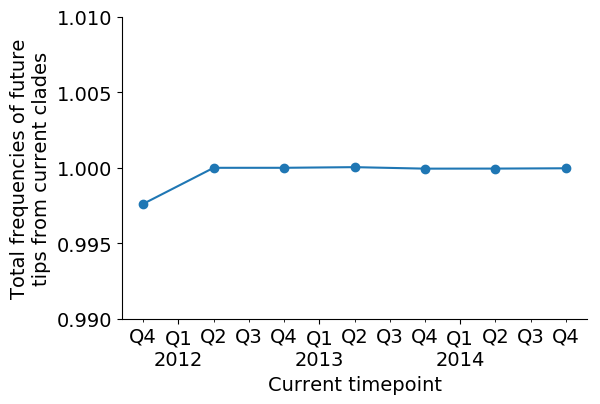

In [501]:
ax = frequency_df[frequency_df["predictors"] == "lbi"].groupby(["timepoint"])["frequency"].sum().plot(marker="o")
ax.set_xlabel("Current timepoint")
ax.set_ylabel("Total frequencies of future\ntips from current clades")
ax.set_ylim(0.99, 1.01)

## Inspect clade linkage between timepoints

Find out which clades assigned to tips per timepoint are present in the final timepoint.

In [502]:
tip_attributes_df.loc[:, ["strain", "timepoint", "clade_membership"]].head()

strain  timepoint clade_membership
0       A/BacGiang/BG003/2004 2004-10-01          4ff1302
1      A/BayofPlenty/383/2004 2004-10-01          aaeb03c
2         A/California/7/2004 2004-10-01          aaeb03c
3  A/California/NHRC0002/2003 2004-10-01          4ff1302
4  A/California/NHRC0003/2003 2004-10-01          4ff1302

In [503]:
tips_to_clades_df.head()

tip clade_membership  depth lineage segment  \
0  A/WesternAustralia/12/2000             root      0    h3n2      ha   
1      A/Netherlands/126/2001             root      0    h3n2      ha   
2            A/Perth/201/2001             root      0    h3n2      ha   
3         A/Auckland/598/2000             root      0    h3n2      ha   
4       A/Canterbury/103/2000             root      0    h3n2      ha   

   timepoint  
0 2004-10-01  
1 2004-10-01  
2 2004-10-01  
3 2004-10-01  
4 2004-10-01

In [504]:
clades_per_timepoint = tip_attributes_df.loc[:, ["timepoint", "clade_membership"]].drop_duplicates()

In [505]:
clades_per_timepoint.head()

timepoint clade_membership
0  2004-10-01          4ff1302
1  2004-10-01          aaeb03c
6  2004-10-01          4952842
7  2004-10-01          7aa732d
11 2004-10-01          44989e1

In [506]:
clades_per_timepoint.tail()

timepoint clade_membership
12659 2015-10-01          aafb4e9
12737 2015-10-01          414723b
13045 2015-10-01          1a16e36
13121 2015-10-01          c65d2b1
13174 2015-10-01          c25ef77

In [507]:
tips_to_clades_df.tail()

tip clade_membership  depth lineage  \
1633901  A/PortoAlegre/LACENRS-1447/2014          4e35443    211    h3n2   
1633902  A/PortoAlegre/LACENRS-1447/2014          9a3ff5d    212    h3n2   
1633903  A/PortoAlegre/LACENRS-1447/2014          a5bcb4f    213    h3n2   
1633904  A/PortoAlegre/LACENRS-1447/2014          1c5e069    215    h3n2   
1633905  A/PortoAlegre/LACENRS-1447/2014             root    216    h3n2   

        segment  timepoint  
1633901      ha 2015-10-01  
1633902      ha 2015-10-01  
1633903      ha 2015-10-01  
1633904      ha 2015-10-01  
1633905      ha 2015-10-01

In [508]:
tips_to_clades_df["timepoint"].max()

Timestamp('2015-10-01 00:00:00')

In [509]:
clades_present_at_last_timepoint = set(tips_to_clades_df.loc[
    tips_to_clades_df["timepoint"] == tips_to_clades_df["timepoint"].max(),
    "clade_membership"
].drop_duplicates().values)

In [510]:
list(clades_present_at_last_timepoint)[:5]

['ca3acdb', 'root', 'e4d8ffe', '4ff1302', '9e447e4']

In [511]:
len(clades_present_at_last_timepoint)

73

In [512]:
clades_per_timepoint["present_at_last_timepoint"] = clades_per_timepoint["clade_membership"].apply(
    lambda clade: clade in clades_present_at_last_timepoint
)

In [513]:
clades_per_timepoint.head()

timepoint clade_membership  present_at_last_timepoint
0  2004-10-01          4ff1302                       True
1  2004-10-01          aaeb03c                      False
6  2004-10-01          4952842                       True
7  2004-10-01          7aa732d                       True
11 2004-10-01          44989e1                       True

Text(0,0.5,'Number of clades')

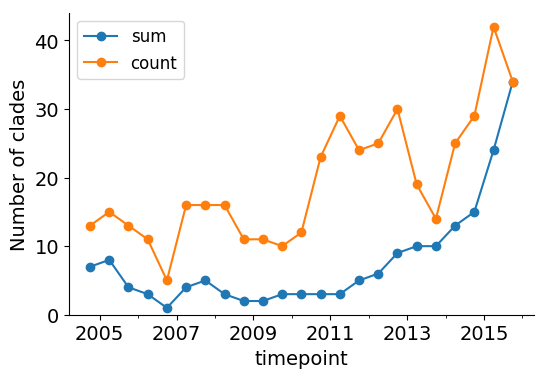

In [514]:
ax = clades_per_timepoint.groupby("timepoint")["present_at_last_timepoint"].aggregate(["sum", "count"]).plot(marker="o")
ax.set_ylim(bottom=0)
ax.set_ylabel("Number of clades")

In [515]:
counts_of_clades_per_timepoint = clades_per_timepoint.groupby("timepoint")["present_at_last_timepoint"].aggregate(["sum", "count"])

In [516]:
counts_of_clades_per_timepoint["missing"] = counts_of_clades_per_timepoint["count"] - counts_of_clades_per_timepoint["sum"]

Text(0,0.5,'Clades missing from final timepoint')

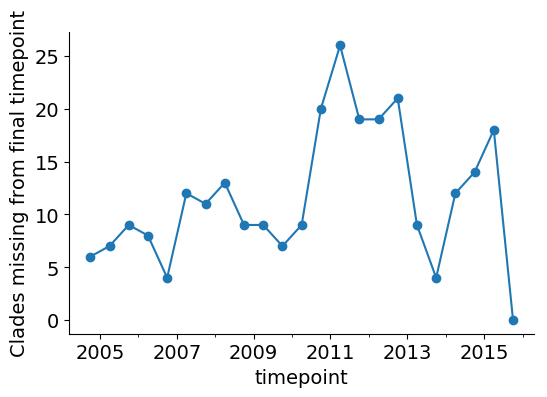

In [517]:
ax = counts_of_clades_per_timepoint["missing"].plot(marker="o")
ax.set_ylabel("Clades missing from final timepoint")

In [518]:
clades_per_timepoint[~clades_per_timepoint["present_at_last_timepoint"]].head()

timepoint clade_membership  present_at_last_timepoint
1  2004-10-01          aaeb03c                      False
23 2004-10-01          f3190f7                      False
45 2004-10-01          962ced9                      False
65 2004-10-01          31e4ba2                      False
71 2004-10-01          58ffa77                      False

In [519]:
tip_attributes_df[(tip_attributes_df["timepoint"] == "2004-10-01") & (tip_attributes_df["clade_membership"] == "42c20f9")]

Empty DataFrame
Columns: [strain, branch_length, cTiter, cTiterSub, cTiterSub_x, clade_membership, clock_length, country, country_entropy, dTiter, dTiterSub, date, delta_frequency, dms_star, ep, ep_x, lbi, mutation_length, ne, ne_star, numdate, raw_date, rb, region, region_entropy, is_terminal, timepoint, lineage, segment, frequency, naive]
Index: []

[0 rows x 31 columns]

In [520]:
tips_to_clades_df[(tips_to_clades_df["tip"] == "A/Austria/144219/2004") & (tips_to_clades_df["depth"] == 0)]

Empty DataFrame
Columns: [tip, clade_membership, depth, lineage, segment, timepoint]
Index: []

In [521]:
timepoints = tip_attributes_df["timepoint"].drop_duplicates()

In [522]:
# Get sequence for above strain from all amino acid translations per timepoint.
strain = "A/Austria/144219/2004"
strain_sequences = []
genes = ["SigPep", "HA1", "HA2"]

for timepoint in timepoints:
    sequence = ""
    for gene in genes:
        alignment_name = data_root + "timepoints/%s/segments/ha/aa-seq_%s.fasta" % (timepoint.strftime("%Y-%m-%d"), gene)
        with open(alignment_name, "r") as fh:
            records = Bio.SeqIO.parse(fh, "fasta")
            for record in records:
                if record.id == strain:
                    sequence += str(record.seq)
                    break

    if len(sequence) > 0:
        strain_sequences.append(sequence)

FileNotFoundError: [Errno 2] No such file or directory: '../results/builds/h3n2/90_viruses_per_month/sample_0/2000-10-01--2015-10-01/timepoints/2004-10-01/segments/ha/aa-seq_SigPep.fasta'

In [523]:
len(strain_sequences)

0

In [524]:
if len(strain_sequences) > 0:
    for i in range(len(strain_sequences[0])):
        bases = set([sequence[i] for sequence in strain_sequences])
        if len(bases) != 1:
            print("%i: %s" % (i, bases))

In [525]:
strain_nucleotide_sequences = []
if len(strain_sequences) > 0:
    for timepoint in timepoints:
        json_name = data_root + "timepoints/%s/segments/ha/nt_muts.json" % timepoint.strftime("%Y-%m-%d")
        with open(json_name, "r") as fh:
            nt_muts = json.load(fh)
            strain_nucleotide_sequences.append(nt_muts["nodes"][strain]["sequence"])

In [526]:
len(strain_nucleotide_sequences)

0

In [527]:
len(set(strain_nucleotide_sequences))

0

In [528]:
if len(strain_nucleotide_sequences) > 0:
    for i in range(len(strain_nucleotide_sequences[0])):
        bases = set([sequence[i] for sequence in strain_nucleotide_sequences])
        if len(bases) != 1:
            print("%i: %s" % (i, bases))

In [529]:
strain

'A/Austria/144219/2004'

In [530]:
clades_per_timepoint.head()

timepoint clade_membership  present_at_last_timepoint
0  2004-10-01          4ff1302                       True
1  2004-10-01          aaeb03c                      False
6  2004-10-01          4952842                       True
7  2004-10-01          7aa732d                       True
11 2004-10-01          44989e1                       True

In [531]:
def clade_in_next_timepoint(record):
    clade = record["clade_membership"]
    future_timepoint = record["timepoint"] + pd.DateOffset(months=12)
    
    return ((clades_per_timepoint["clade_membership"] == clade) & (clades_per_timepoint["timepoint"] == future_timepoint)).sum() > 0

In [532]:
clades_per_timepoint["present_in_next_timepoint"] = clades_per_timepoint.apply(clade_in_next_timepoint, axis=1)

In [533]:
counts_of_clades_per_timepoint = clades_per_timepoint.groupby("timepoint")["present_in_next_timepoint"].aggregate(["sum", "count"]).reset_index()

In [534]:
counts_of_clades_per_timepoint["missing"] = counts_of_clades_per_timepoint["count"] - counts_of_clades_per_timepoint["sum"]

In [535]:
counts_of_clades_per_timepoint.head()

timepoint  sum  count  missing
0 2004-10-01  3.0     13     10.0
1 2005-04-01  4.0     15     11.0
2 2005-10-01  3.0     13     10.0
3 2006-04-01  4.0     11      7.0
4 2006-10-01  2.0      5      3.0

Text(0,0.5,'Clades missing from next timepoint')

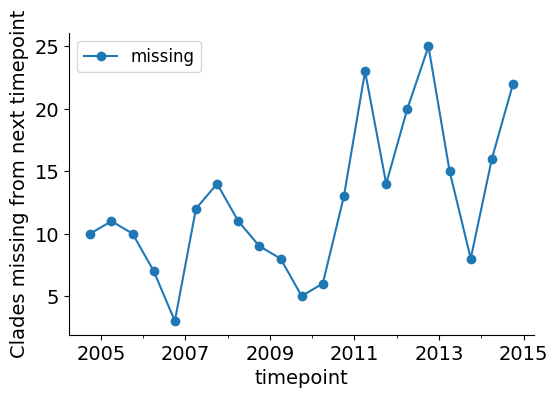

In [536]:
ax = counts_of_clades_per_timepoint.loc[
    counts_of_clades_per_timepoint["timepoint"] <= counts_of_clades_per_timepoint["timepoint"].max() - pd.DateOffset(months=12)
].plot(x="timepoint", y="missing", marker="o")
ax.set_ylabel("Clades missing from next timepoint")

## Summarize raw predictors

In [538]:
raw_tip_attributes_df = pd.read_table(data_root + "tip_attributes.tsv")

In addition to the raw tip attributes, load the standardization metrics associated with each predictor for comparison to the overall distributions per predictor per timepoint shown below.

In [539]:
standardization_stats = pd.read_csv(data_root + "standardization_statistics.json", sep="\t")

In [540]:
standardization_stats

mean        var        predictor
0   4.139616   2.868253        cTiterSub
1  -4.770553   0.252776      cTiterSub_x
2   0.058714   0.250921  delta_frequency
3  -0.740971  28.318678         dms_star
4  15.117508   8.858301               ep
5  -3.497598   0.247276             ep_x
6   0.275287   0.041882              lbi
7   0.000000   0.000000            naive
8   0.744248   0.947213          ne_star

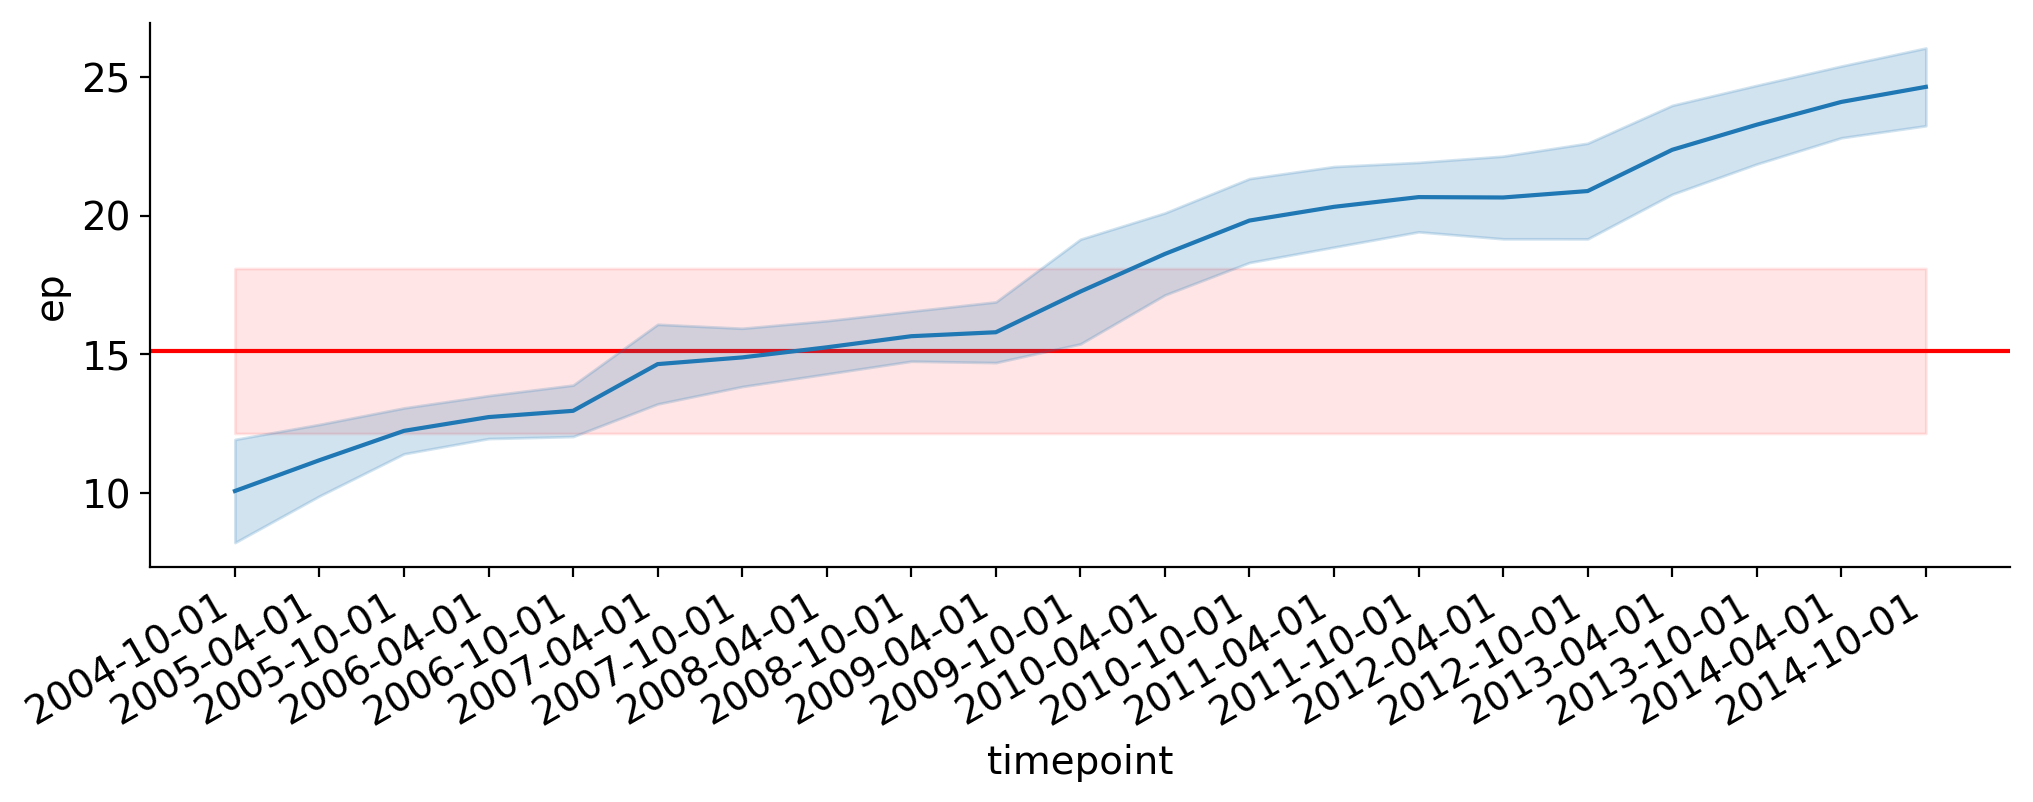

In [541]:
predictor = "ep"
fig, ax = plt.subplots(1, 1, figsize=(12, 4))
sns.lineplot(
    x="timepoint",
    y=predictor,
    data=raw_tip_attributes_df[raw_tip_attributes_df["timepoint"] < "2015-04-01"],
    ci="sd",
    ax=ax
)
plt.gcf().autofmt_xdate()
#ax.set_ylim(bottom=0)

# Draw the standardization mean and standard deviation for comparison.
mean = standardization_stats[standardization_stats["predictor"] == predictor]["mean"].values[0]
std = np.sqrt(standardization_stats[standardization_stats["predictor"] == predictor]["var"].values[0])

ax.axhline(y=standardization_stats[standardization_stats["predictor"] == predictor]["mean"].values[0], color="red", zorder=-10)
ax.fill_between(
    raw_tip_attributes_df[raw_tip_attributes_df["timepoint"] < "2015-04-01"]["timepoint"].values,
    mean - std,
    mean + std,
    color="red",
    alpha=0.1,
    zorder=-10
)

Text(0,0.5,'Epitope cross-immunity')

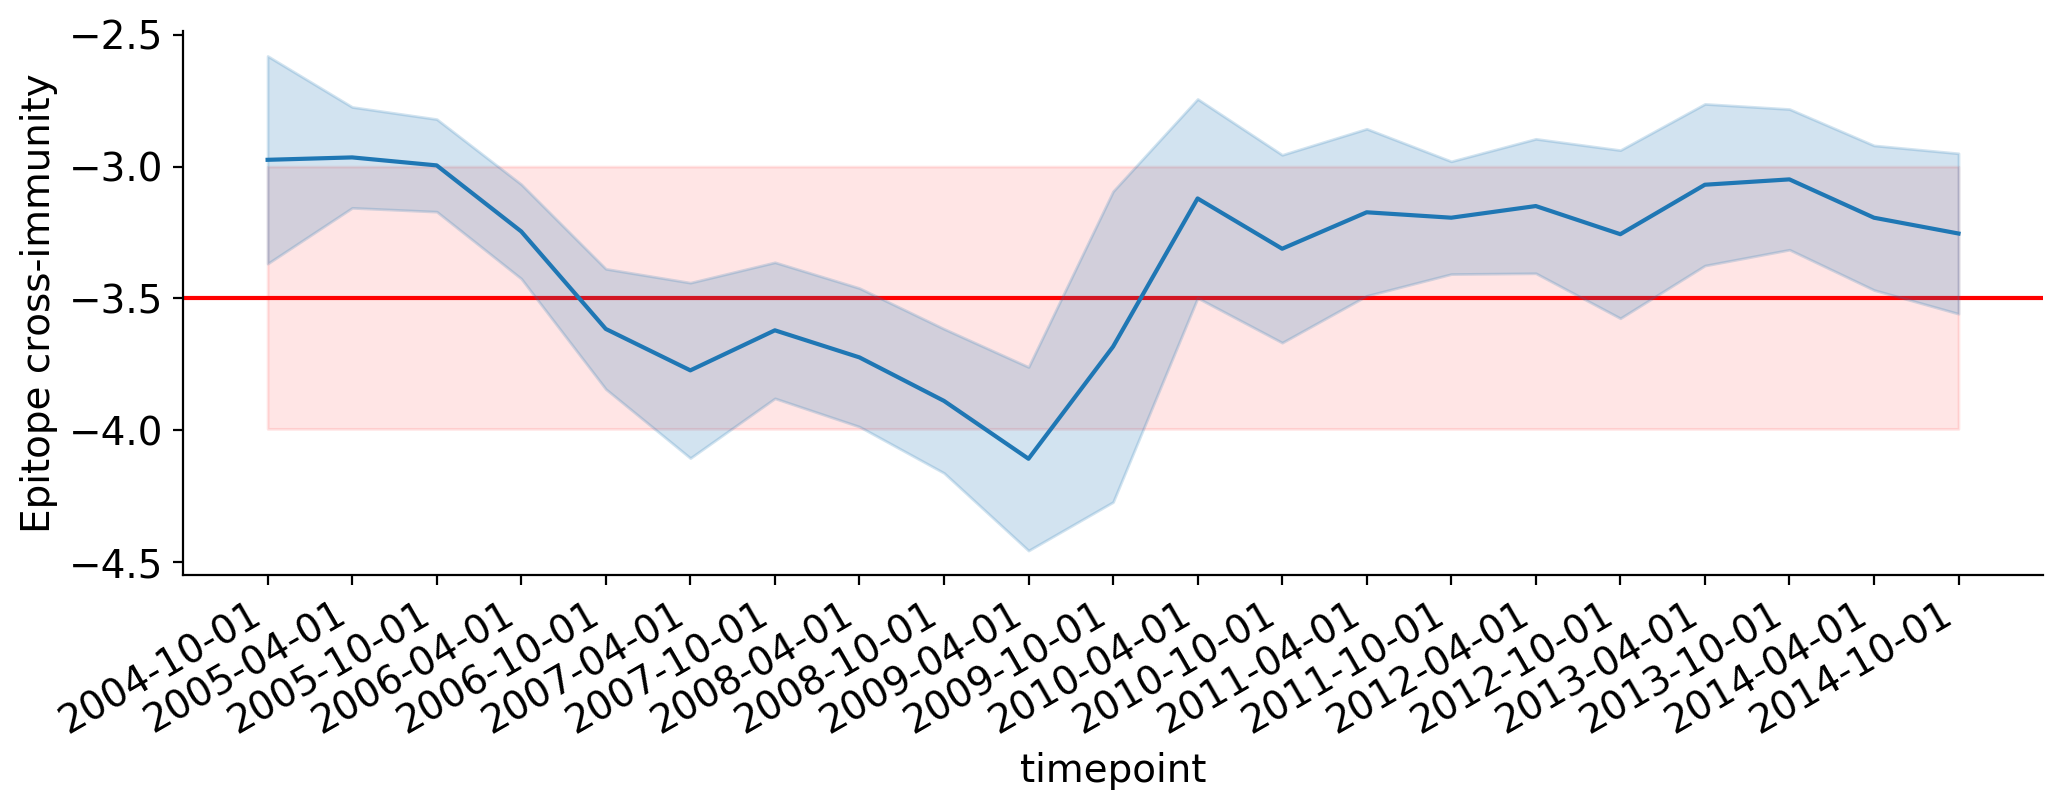

In [546]:
predictor = "ep_x"
fig, ax = plt.subplots(1, 1, figsize=(12, 4))
sns.lineplot(
    x="timepoint",
    y=predictor,
    data=raw_tip_attributes_df[raw_tip_attributes_df["timepoint"] < "2015-04-01"],
    ci="sd",
    ax=ax
)
plt.gcf().autofmt_xdate()
#ax.set_ylim(bottom=0)

# Draw the standardization mean and standard deviation for comparison.
mean = standardization_stats[standardization_stats["predictor"] == predictor]["mean"].values[0]
std = np.sqrt(standardization_stats[standardization_stats["predictor"] == predictor]["var"].values[0])

ax.axhline(y=standardization_stats[standardization_stats["predictor"] == predictor]["mean"].values[0], color="red", zorder=-10)
ax.fill_between(
    raw_tip_attributes_df[raw_tip_attributes_df["timepoint"] < "2015-04-01"]["timepoint"].values,
    mean - std,
    mean + std,
    color="red",
    alpha=0.1,
    zorder=-10
)
ax.set_ylabel("Epitope cross-immunity")

Text(0,0.5,'std dev of ep_x')

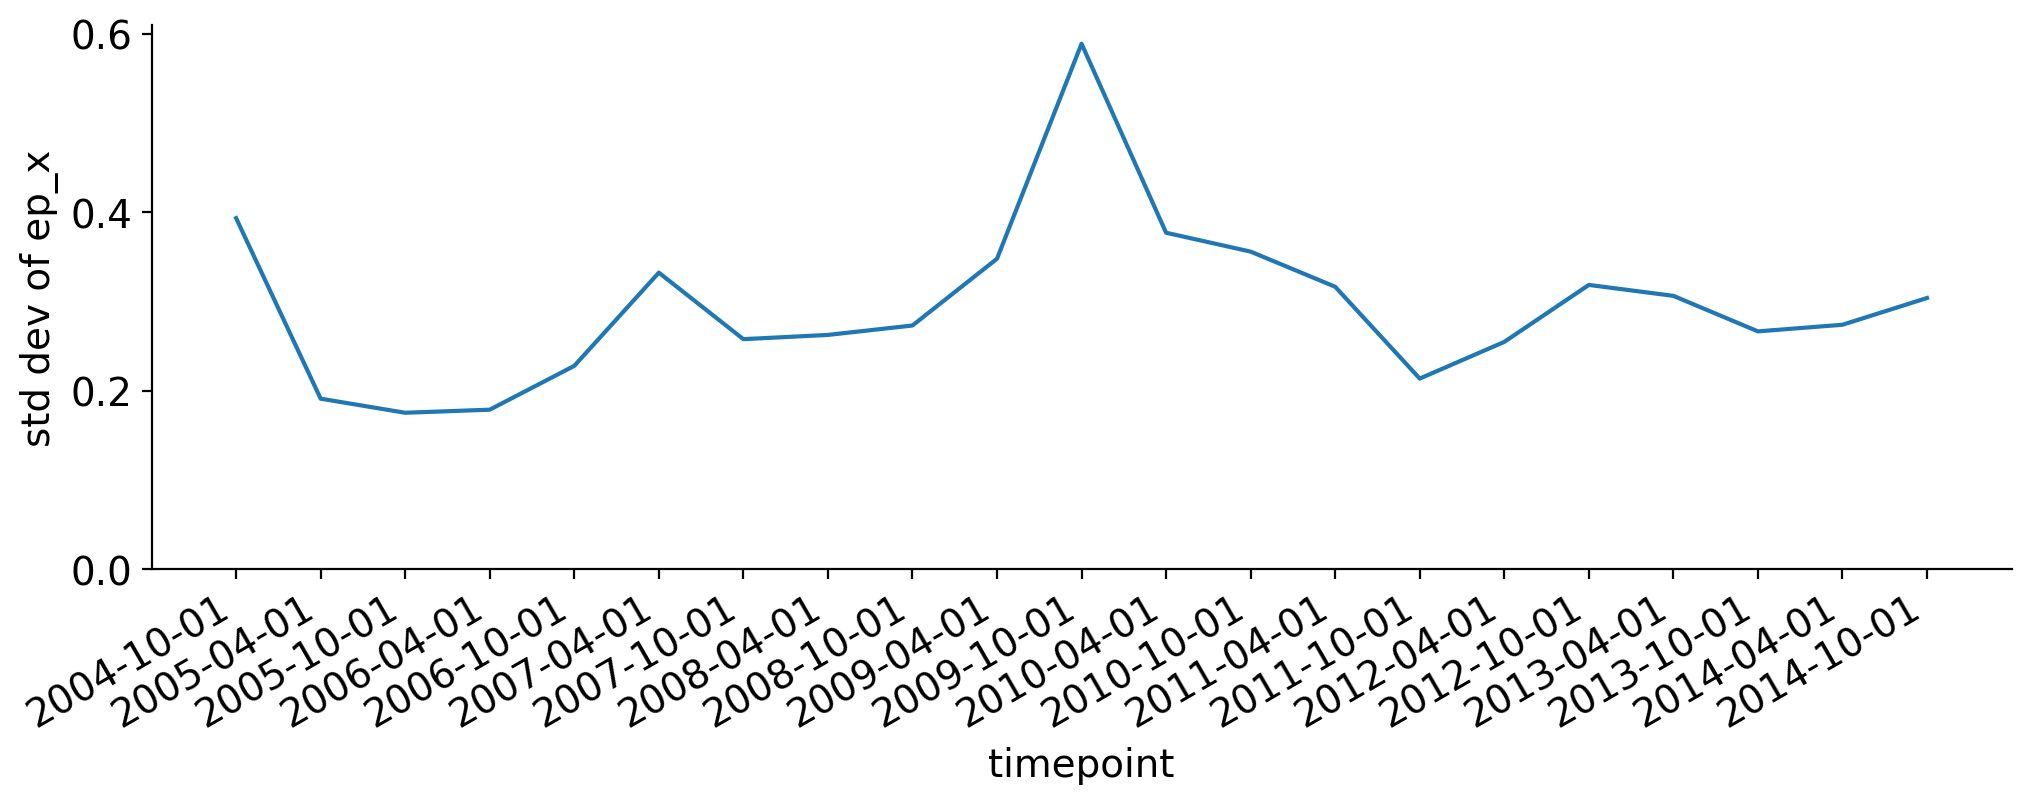

In [543]:
predictor = "ep_x"
fig, ax = plt.subplots(1, 1, figsize=(12, 4))
sns.lineplot(
    x="timepoint",
    y=predictor,
    data=raw_tip_attributes_df[raw_tip_attributes_df["timepoint"] < "2015-04-01"],
    estimator="std",
    ci=None,
    ax=ax
)
plt.gcf().autofmt_xdate()
ax.set_ylim(bottom=0)
ax.set_ylabel("std dev of %s" % predictor)

ValueError: Could not interpret input 'ep_star'

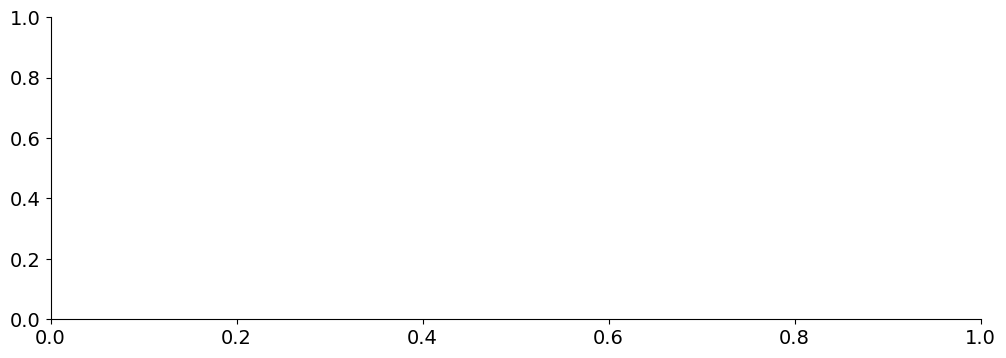

In [543]:
predictor = "ep_star"
fig, ax = plt.subplots(1, 1, figsize=(12, 4))
sns.lineplot(
    x="timepoint",
    y=predictor,
    data=raw_tip_attributes_df[raw_tip_attributes_df["timepoint"] < "2015-04-01"],
    ci="sd",
    ax=ax
)
plt.gcf().autofmt_xdate()
#ax.set_ylim(bottom=0)

# Draw the standardization mean and standard deviation for comparison.
mean = standardization_stats[standardization_stats["predictor"] == predictor]["mean"].values[0]
std = np.sqrt(standardization_stats[standardization_stats["predictor"] == predictor]["var"].values[0])

ax.axhline(y=standardization_stats[standardization_stats["predictor"] == predictor]["mean"].values[0], color="red", zorder=-10)
ax.fill_between(
    raw_tip_attributes_df[raw_tip_attributes_df["timepoint"] < "2015-04-01"]["timepoint"].values,
    mean - std,
    mean + std,
    color="red",
    alpha=0.1,
    zorder=-10
)

In [ ]:
predictor = "cTiterSub_star"
fig, ax = plt.subplots(1, 1, figsize=(12, 4))
sns.lineplot(
    x="timepoint",
    y=predictor,
    data=raw_tip_attributes_df[raw_tip_attributes_df["timepoint"] < "2015-04-01"],
    ci="sd",
    ax=ax
)
plt.gcf().autofmt_xdate()
#ax.set_ylim(bottom=0)

# Draw the standardization mean and standard deviation for comparison.
mean = standardization_stats[standardization_stats["predictor"] == predictor]["mean"].values[0]
std = np.sqrt(standardization_stats[standardization_stats["predictor"] == predictor]["var"].values[0])

ax.axhline(y=standardization_stats[standardization_stats["predictor"] == predictor]["mean"].values[0], color="red", zorder=-10)
ax.fill_between(
    raw_tip_attributes_df[raw_tip_attributes_df["timepoint"] < "2015-04-01"]["timepoint"].values,
    mean - std,
    mean + std,
    color="red",
    alpha=0.1,
    zorder=-10
)

Text(0,0.5,'HI cross-immunity')

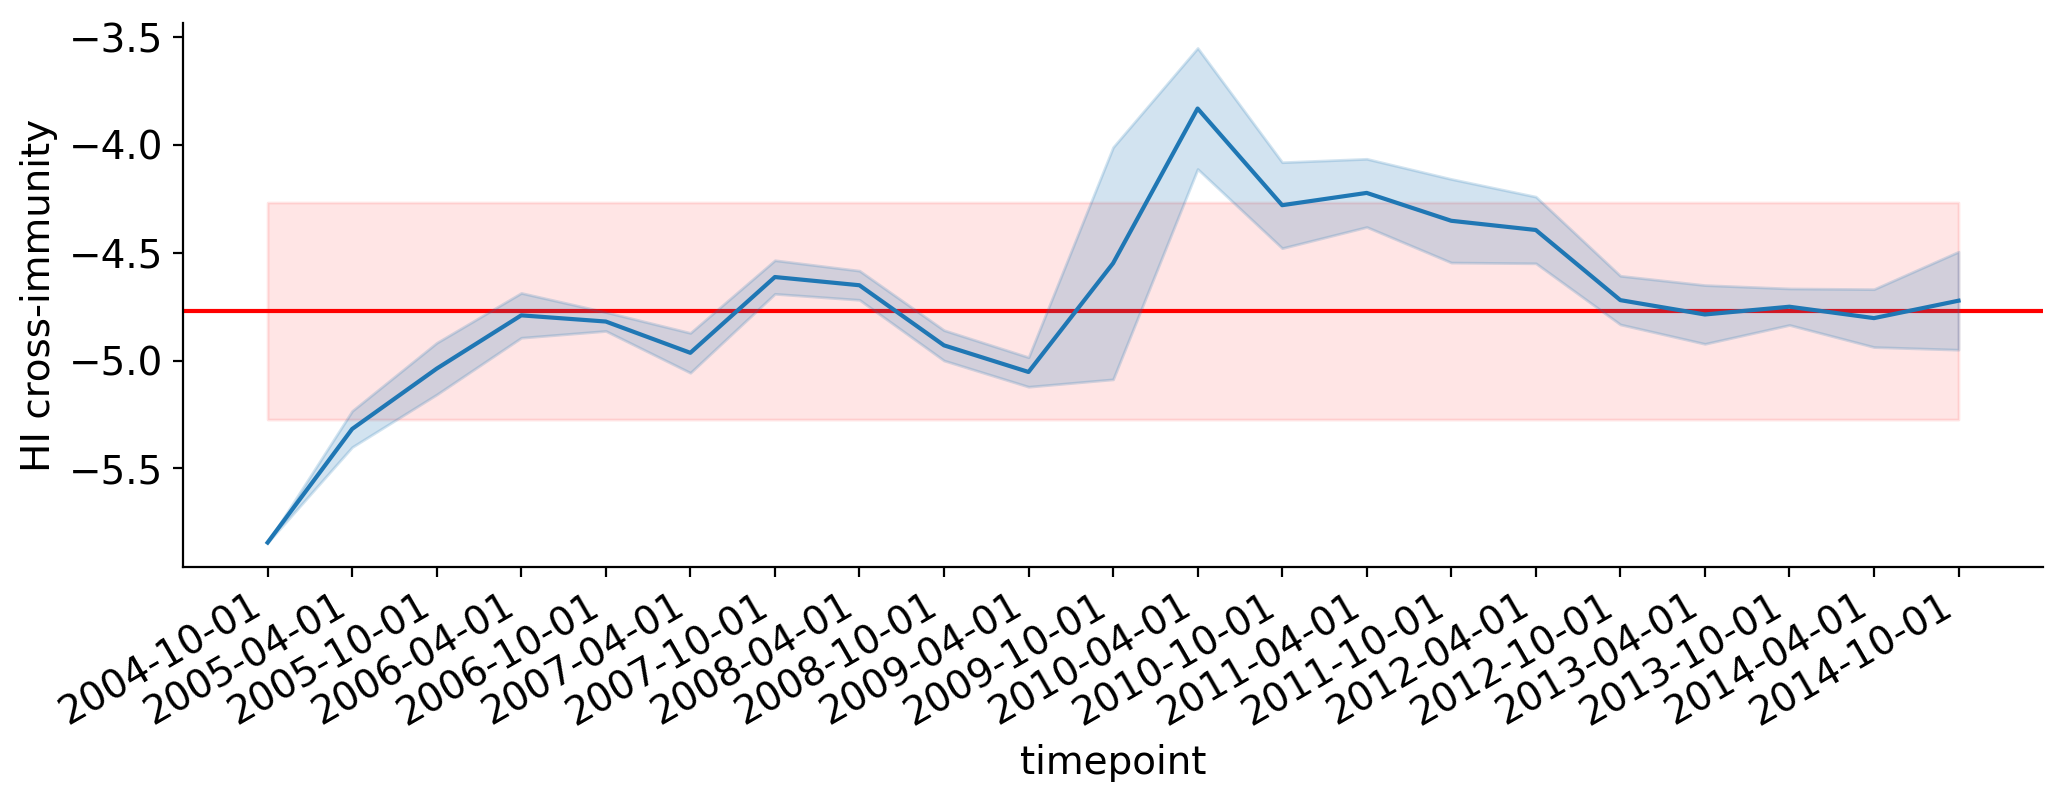

In [545]:
predictor = "cTiterSub_x"
fig, ax = plt.subplots(1, 1, figsize=(12, 4))
sns.lineplot(
    x="timepoint",
    y=predictor,
    data=raw_tip_attributes_df[raw_tip_attributes_df["timepoint"] < "2015-04-01"],
    ci="sd",
    ax=ax
)
plt.gcf().autofmt_xdate()
#ax.set_ylim(bottom=0)

# Draw the standardization mean and standard deviation for comparison.
mean = standardization_stats[standardization_stats["predictor"] == predictor]["mean"].values[0]
std = np.sqrt(standardization_stats[standardization_stats["predictor"] == predictor]["var"].values[0])

ax.axhline(y=standardization_stats[standardization_stats["predictor"] == predictor]["mean"].values[0], color="red", zorder=-10)
ax.fill_between(
    raw_tip_attributes_df[raw_tip_attributes_df["timepoint"] < "2015-04-01"]["timepoint"].values,
    mean - std,
    mean + std,
    color="red",
    alpha=0.1,
    zorder=-10
)
ax.set_ylabel("HI cross-immunity")

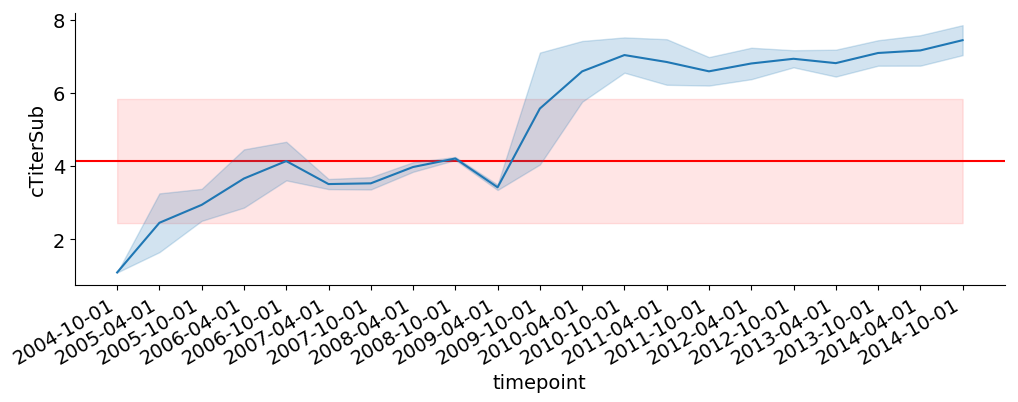

In [545]:
predictor = "cTiterSub"
fig, ax = plt.subplots(1, 1, figsize=(12, 4))
sns.lineplot(
    x="timepoint",
    y=predictor,
    data=raw_tip_attributes_df[raw_tip_attributes_df["timepoint"] < "2015-04-01"],
    ci="sd",
    ax=ax
)
plt.gcf().autofmt_xdate()
#ax.set_ylim(bottom=0)

# Draw the standardization mean and standard deviation for comparison.
mean = standardization_stats[standardization_stats["predictor"] == predictor]["mean"].values[0]
std = np.sqrt(standardization_stats[standardization_stats["predictor"] == predictor]["var"].values[0])

ax.axhline(y=standardization_stats[standardization_stats["predictor"] == predictor]["mean"].values[0], color="red", zorder=-10)
ax.fill_between(
    raw_tip_attributes_df[raw_tip_attributes_df["timepoint"] < "2015-04-01"]["timepoint"].values,
    mean - std,
    mean + std,
    color="red",
    alpha=0.1,
    zorder=-10
)

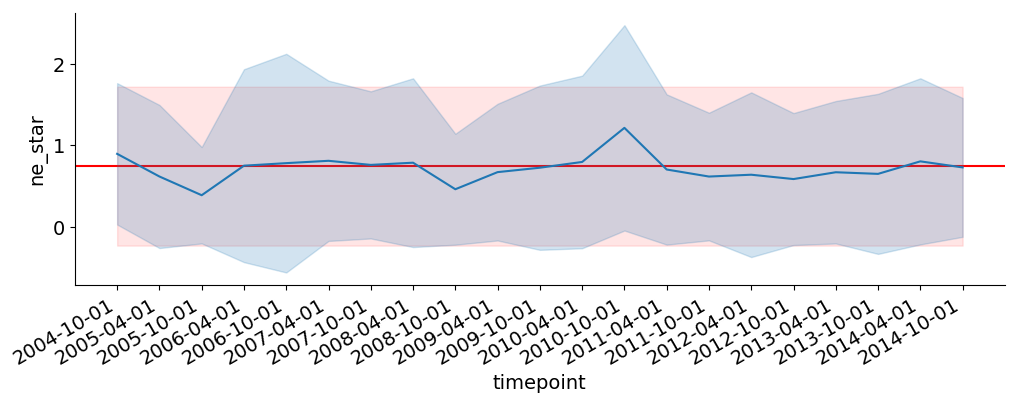

In [546]:
predictor = "ne_star"
fig, ax = plt.subplots(1, 1, figsize=(12, 4))
sns.lineplot(
    x="timepoint",
    y=predictor,
    data=raw_tip_attributes_df[raw_tip_attributes_df["timepoint"] < "2015-04-01"],
    ci="sd",
    ax=ax
)
plt.gcf().autofmt_xdate()
#ax.set_ylim(bottom=0)

# Draw the standardization mean and standard deviation for comparison.
mean = standardization_stats[standardization_stats["predictor"] == predictor]["mean"].values[0]
std = np.sqrt(standardization_stats[standardization_stats["predictor"] == predictor]["var"].values[0])

ax.axhline(y=standardization_stats[standardization_stats["predictor"] == predictor]["mean"].values[0], color="red", zorder=-10)
ax.fill_between(
    raw_tip_attributes_df[raw_tip_attributes_df["timepoint"] < "2015-04-01"]["timepoint"].values,
    mean - std,
    mean + std,
    color="red",
    alpha=0.1,
    zorder=-10
)

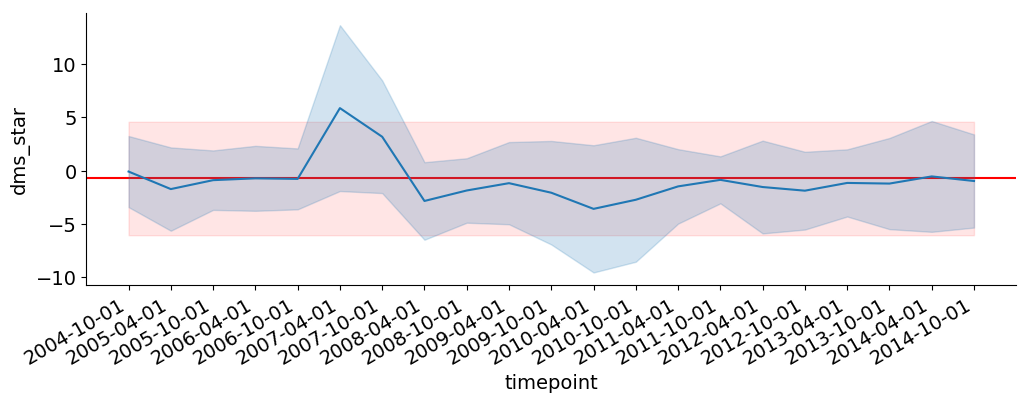

In [547]:
predictor = "dms_star"
fig, ax = plt.subplots(1, 1, figsize=(12, 4))
sns.lineplot(
    x="timepoint",
    y=predictor,
    data=raw_tip_attributes_df[raw_tip_attributes_df["timepoint"] < "2015-04-01"],
    ci="sd",
    ax=ax
)
plt.gcf().autofmt_xdate()
#ax.set_ylim(bottom=0)

# Draw the standardization mean and standard deviation for comparison.
mean = standardization_stats[standardization_stats["predictor"] == predictor]["mean"].values[0]
std = np.sqrt(standardization_stats[standardization_stats["predictor"] == predictor]["var"].values[0])

ax.axhline(y=standardization_stats[standardization_stats["predictor"] == predictor]["mean"].values[0], color="red", zorder=-10)
ax.fill_between(
    raw_tip_attributes_df[raw_tip_attributes_df["timepoint"] < "2015-04-01"]["timepoint"].values,
    mean - std,
    mean + std,
    color="red",
    alpha=0.1,
    zorder=-10
)

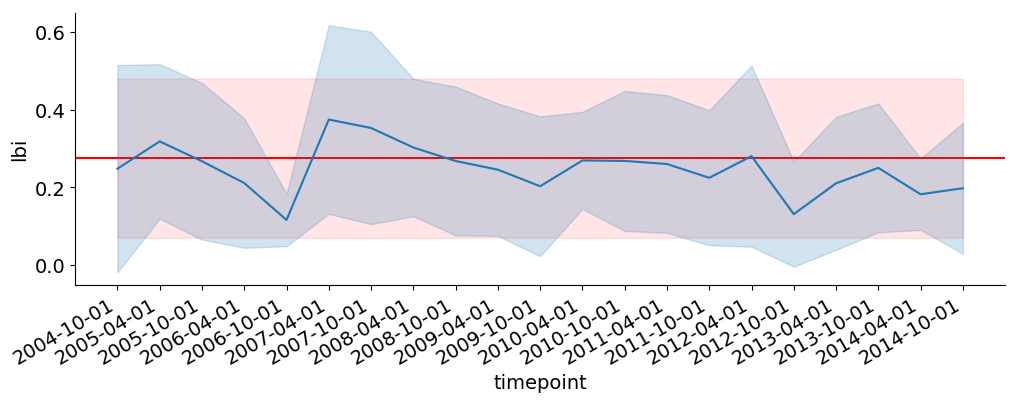

In [548]:
predictor = "lbi"
fig, ax = plt.subplots(1, 1, figsize=(12, 4))
sns.lineplot(
    x="timepoint",
    y=predictor,
    data=raw_tip_attributes_df[raw_tip_attributes_df["timepoint"] < "2015-04-01"],
    ci="sd",
    ax=ax
)
plt.gcf().autofmt_xdate()
#ax.set_ylim(bottom=0)

# Draw the standardization mean and standard deviation for comparison.
mean = standardization_stats[standardization_stats["predictor"] == predictor]["mean"].values[0]
std = np.sqrt(standardization_stats[standardization_stats["predictor"] == predictor]["var"].values[0])

ax.axhline(y=standardization_stats[standardization_stats["predictor"] == predictor]["mean"].values[0], color="red", zorder=-10)
ax.fill_between(
    raw_tip_attributes_df[raw_tip_attributes_df["timepoint"] < "2015-04-01"]["timepoint"].values,
    mean - std,
    mean + std,
    color="red",
    alpha=0.1,
    zorder=-10
)

Text(0,0.5,'std dev of lbi')

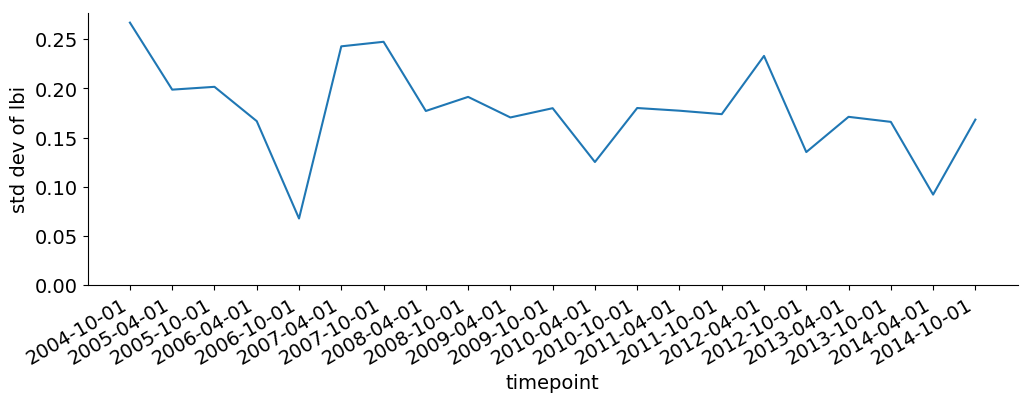

In [549]:
predictor = "lbi"
fig, ax = plt.subplots(1, 1, figsize=(12, 4))
sns.lineplot(
    x="timepoint",
    y=predictor,
    data=raw_tip_attributes_df[raw_tip_attributes_df["timepoint"] < "2015-04-01"],
    estimator="std",
    ci=None,
    ax=ax
)
plt.gcf().autofmt_xdate()
ax.set_ylim(bottom=0)
ax.set_ylabel("std dev of %s" % predictor)

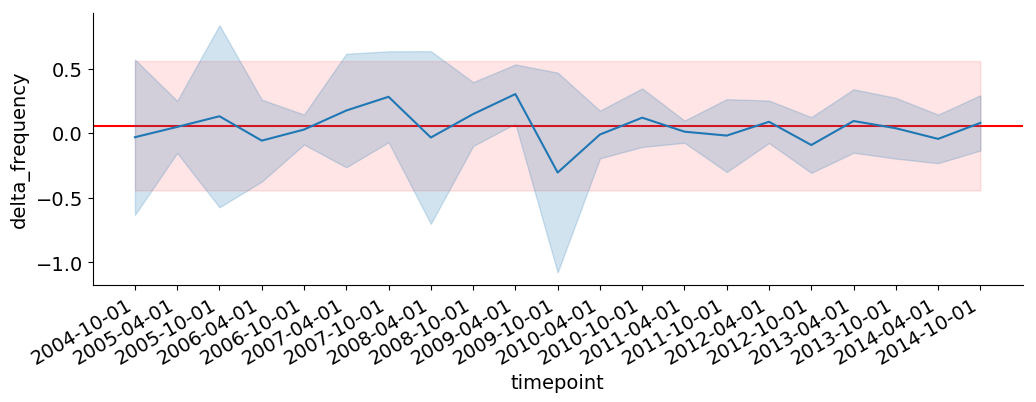

In [550]:
predictor = "delta_frequency"
fig, ax = plt.subplots(1, 1, figsize=(12, 4))
sns.lineplot(
    x="timepoint",
    y=predictor,
    data=raw_tip_attributes_df[raw_tip_attributes_df["timepoint"] < "2015-04-01"],
    ci="sd",
    ax=ax
)
plt.gcf().autofmt_xdate()
#ax.set_ylim(bottom=0)

# Draw the standardization mean and standard deviation for comparison.
mean = standardization_stats[standardization_stats["predictor"] == predictor]["mean"].values[0]
std = np.sqrt(standardization_stats[standardization_stats["predictor"] == predictor]["var"].values[0])

ax.axhline(y=standardization_stats[standardization_stats["predictor"] == predictor]["mean"].values[0], color="red", zorder=-10)
ax.fill_between(
    raw_tip_attributes_df[raw_tip_attributes_df["timepoint"] < "2015-04-01"]["timepoint"].values,
    mean - std,
    mean + std,
    color="red",
    alpha=0.1,
    zorder=-10
)

## Summarize standardized predictor distributions

In [551]:
tip_attributes_df.shape

(13305, 31)

In [552]:
tip_attributes_df["ep_x"].head()

0    1.060767
1    1.853693
2    2.541048
3    1.105738
4    0.667970
Name: ep_x, dtype: float64

In [553]:
tip_attributes_df["ep_x"].dropna().shape

(13305,)

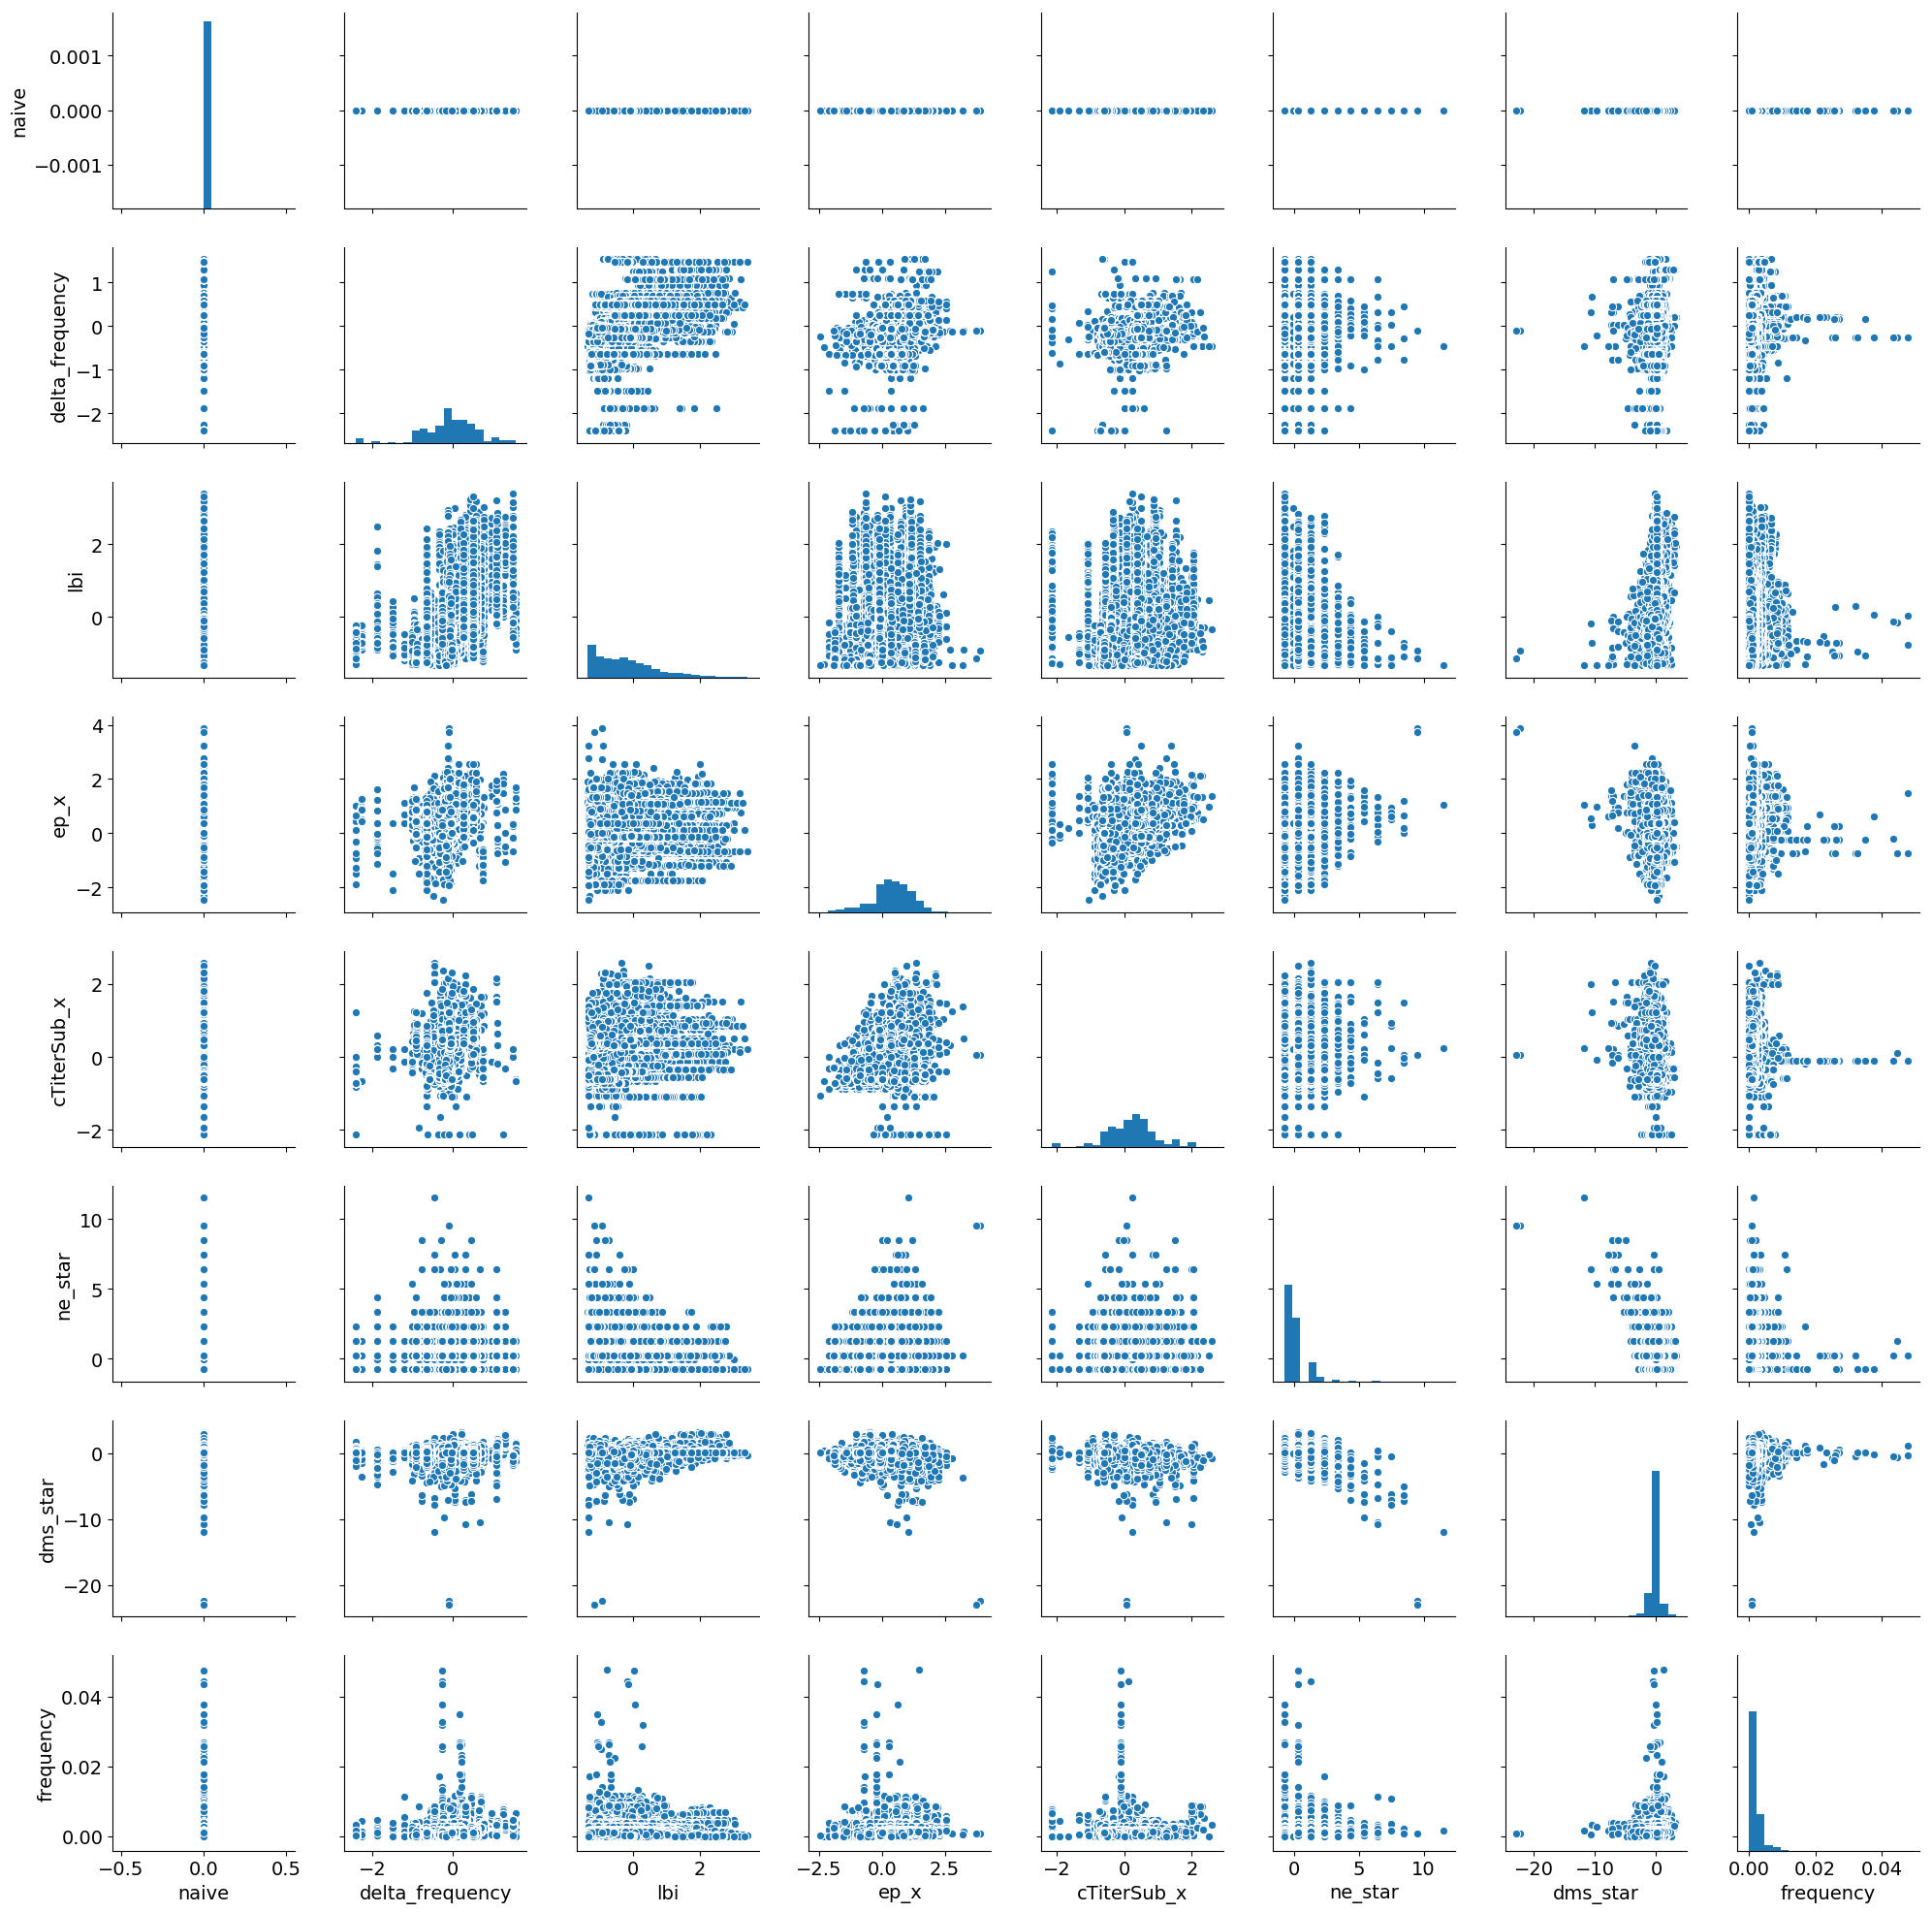

In [554]:
variables_to_plot = [predictor for predictor in predictor_names_order if not "-" in predictor] + ["frequency"]
sns.pairplot(tip_attributes_df, vars=variables_to_plot, diag_kind="hist", diag_kws={"bins": 20})

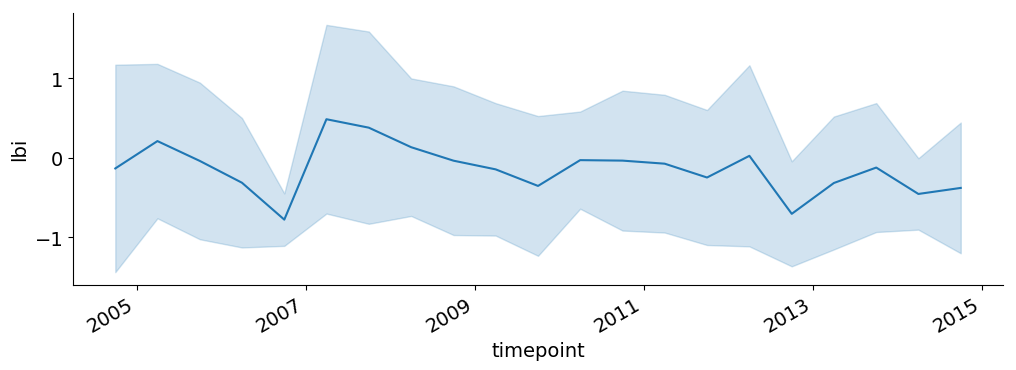

In [555]:
fig, ax = plt.subplots(1, 1, figsize=(12, 4))
sns.lineplot(
    x="timepoint",
    y="lbi",
    data=tip_attributes_df[tip_attributes_df["timepoint"] < "2015-04-01"],
    ci="sd",
    ax=ax
)
plt.gcf().autofmt_xdate()
#ax.set_ylim(bottom=0)

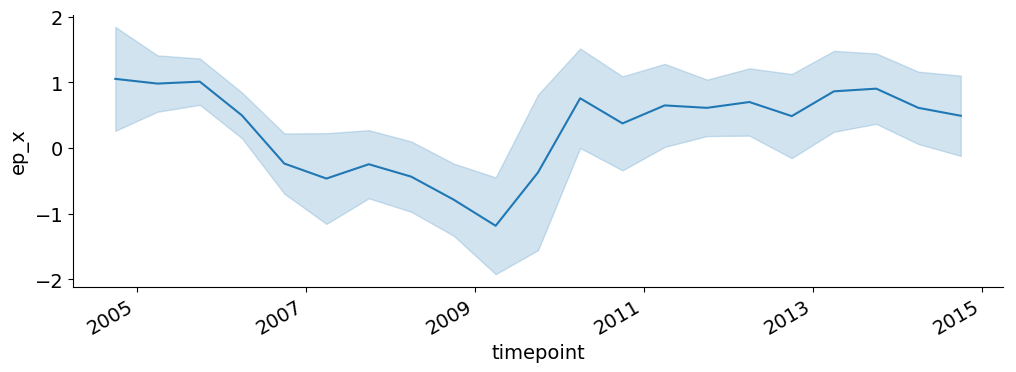

In [556]:
fig, ax = plt.subplots(1, 1, figsize=(12, 4))
sns.lineplot(
    x="timepoint",
    y="ep_x",
    data=tip_attributes_df[tip_attributes_df["timepoint"] < "2015-04-01"],
    ci="sd",
    ax=ax
)
plt.gcf().autofmt_xdate()
#ax.set_ylim(bottom=0)

In [557]:
tip_attributes_df.loc[pd.isnull(tip_attributes_df["ep_x"]), ["strain", "timepoint", "frequency"]]

Empty DataFrame
Columns: [strain, timepoint, frequency]
Index: []

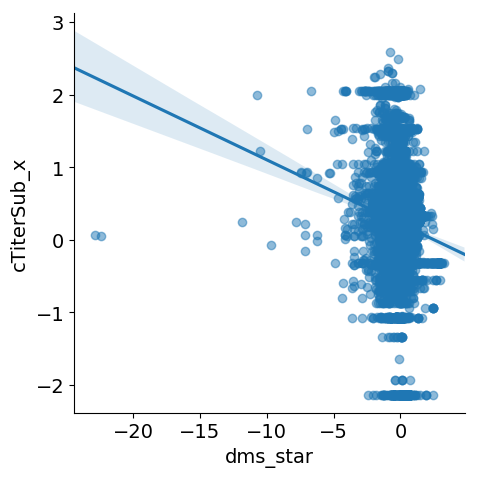

In [558]:
sns.lmplot("dms_star", "cTiterSub_x", tip_attributes_df, scatter_kws={"alpha": 0.5})

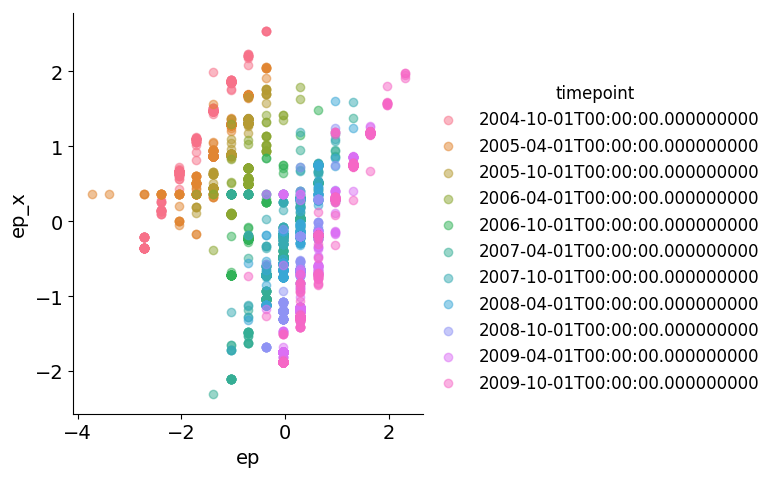

In [559]:
sns.lmplot("ep", "ep_x", tip_attributes_df[(tip_attributes_df["ep"] < 50) & (tip_attributes_df["timepoint"] < "2010-01-01")], hue="timepoint", scatter_kws={"alpha": 0.5}, fit_reg=False)



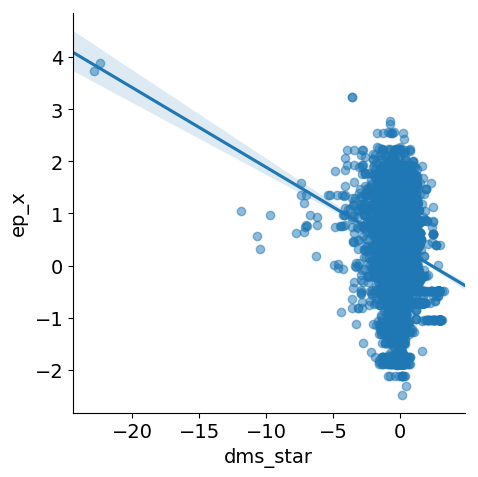

In [560]:
sns.lmplot("dms_star", "ep_x", tip_attributes_df, scatter_kws={"alpha": 0.5})

(-7, 7)

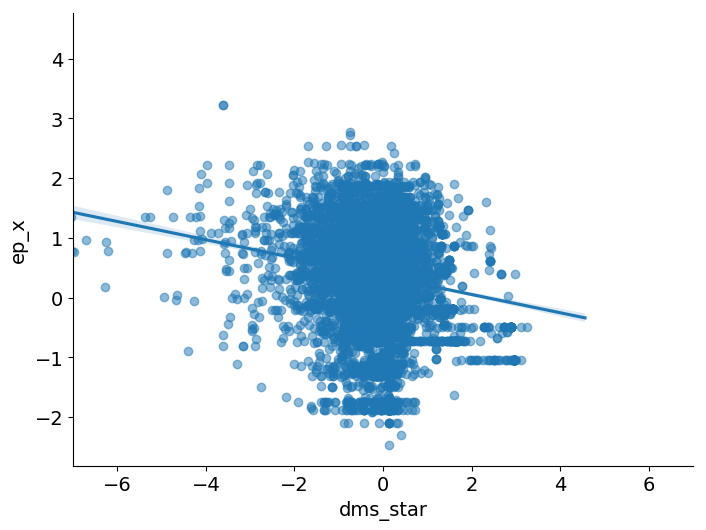

In [561]:
fig, ax = plt.subplots(1, 1, figsize=(8, 6))
sns.regplot("dms_star", "ep_x", tip_attributes_df, scatter_kws={"alpha": 0.5}, ax=ax)
ax.set_xlim(-7, 7)

In [562]:
tip_attributes_df.loc[tip_attributes_df["dms_star"] < -15, ["timepoint", "strain", "cTiterSub_x", "ep_x", "dms_star", "frequency", "raw_date"]].head()

timepoint                    strain  cTiterSub_x      ep_x   dms_star  \
9470  2014-04-01  A/Thailand/CU-CB166/2014     0.055382  3.886724 -22.380600   
10505 2014-10-01  A/Thailand/CU-CB166/2014     0.064513  3.732838 -22.882336   

       frequency    raw_date  
9470    0.000805  2014-04-01  
10505   0.000845  2014-04-01

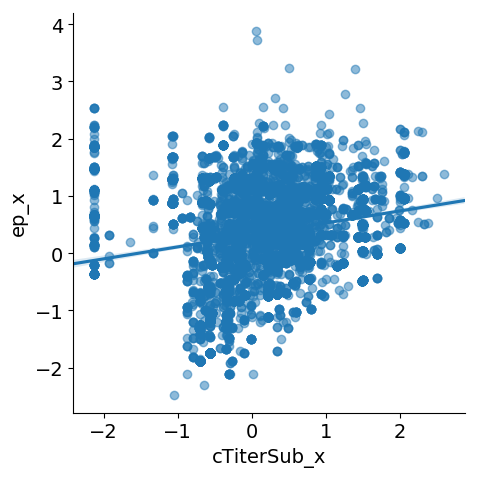

In [563]:
sns.lmplot("cTiterSub_x", "ep_x", tip_attributes_df, scatter_kws={"alpha": 0.5})

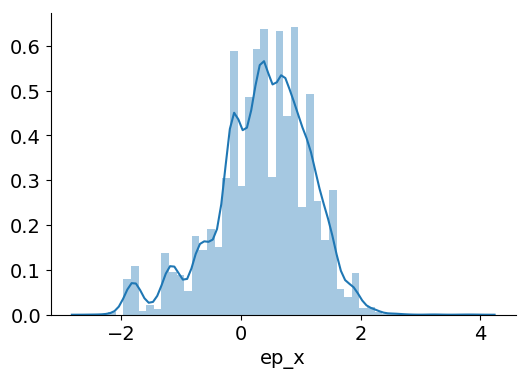

In [564]:
sns.distplot(tip_attributes_df["ep_x"])

In [565]:
tip_attributes_df["ep_x"].mean()

0.36604673227273266

In [566]:
raw_tip_attributes_df = pd.read_table(data_root + "tip_attributes.tsv")

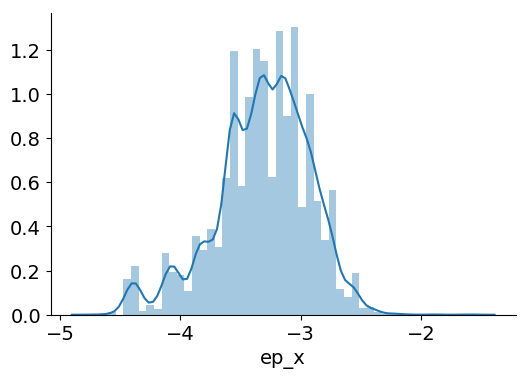

In [567]:
sns.distplot(raw_tip_attributes_df["ep_x"].dropna())

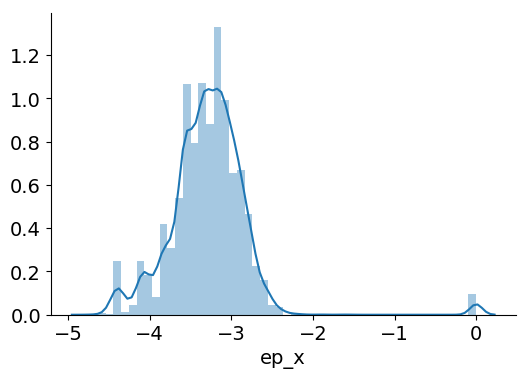

In [568]:
sns.distplot(raw_tip_attributes_df["ep_x"].fillna(0.0))

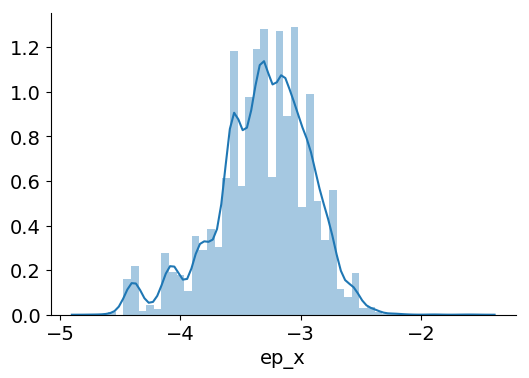

In [569]:
sns.distplot(raw_tip_attributes_df["ep_x"].fillna(raw_tip_attributes_df["ep_x"].dropna().mean()))

In [570]:
raw_tip_attributes_df["ep_x"].dropna().mean()

-3.3155747065557915

In [571]:
raw_tip_attributes_df["ep_x"].dropna().std()

0.39177974208678495

In [572]:
raw_tip_attributes_df["ep_x"].fillna(0.0).mean()

-3.2851725935005636

In [573]:
raw_tip_attributes_df["ep_x"].fillna(0.0).std()

0.5019636635631467

## Summarize model residuals

In [574]:
residuals_by_timepoint = residual_df.groupby(["predictors", "timepoint"])["residual"].sum().reset_index()

In [575]:
residuals_by_timepoint.head()

predictors  timepoint  residual
0  cTiterSub 2004-10-01  0.000002
1  cTiterSub 2005-04-01 -0.000014
2  cTiterSub 2005-10-01  0.000003
3  cTiterSub 2006-04-01  0.000088
4  cTiterSub 2006-10-01  0.000125

In [576]:
residuals_by_timepoint.groupby("predictors")["residual"].sum()

predictors
cTiterSub         -0.011653
cTiterSub_x       -0.011653
delta_frequency   -0.011653
dms_star          -0.011653
ep                -0.011653
ep_x              -0.011653
lbi               -0.011653
naive             -0.011653
ne_star           -0.011653
Name: residual, dtype: float64

In [577]:
model_name = "lbi"

In [578]:
model_residuals_by_timepoint = residuals_by_timepoint[residuals_by_timepoint["predictors"] == model_name]

In [579]:
max_lags = 18

Text(0,0.5,'Number of clades')

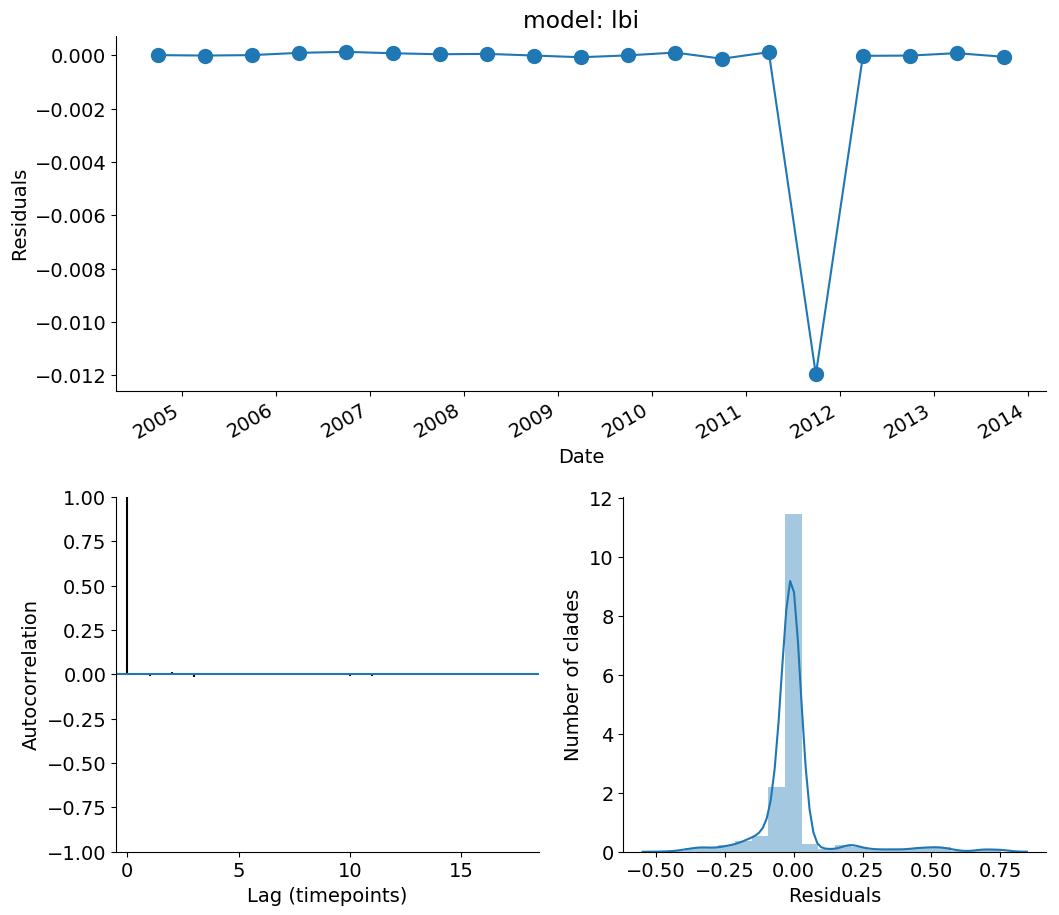

In [580]:
fig = plt.figure(figsize=(12, 12))
gs = gridspec.GridSpec(2, 2)
gs.update(hspace=0.3)

ax1 = plt.subplot(gs[0, :])
ax1.plot(model_residuals_by_timepoint["timepoint"], model_residuals_by_timepoint["residual"], "o-", markersize=10)
ax1.set_xlabel("Date")
ax1.set_ylabel("Residuals")
ax1.set_title("model: %s" % model_name)
plt.gcf().autofmt_xdate()

ax2 = plt.subplot(gs[1, :-1])
max_lags = len(model_residuals_by_timepoint["residual"]) - 1
lags, autocorrelation, lines, horizonal_lines = ax2.acorr(
    model_residuals_by_timepoint["residual"],
    maxlags=max_lags
)
ax2.set_xlabel("Lag (timepoints)")
ax2.set_ylabel("Autocorrelation")
ax2.set_xlim(-0.5, max_lags + 0.5)
ax2.set_ylim(-1, 1)

ax3 = plt.subplot(gs[1:, -1])
sns.distplot(residual_df.loc[residual_df["predictors"] == model_name, "residual"], ax=ax3, bins=20)
ax3.set_xlabel("Residuals")
ax3.set_ylabel("Number of clades")

In [581]:
residual_df.head()

clade_membership  frequency  timepoint  frequency_hat  residual  \
0          06ed3c7   0.000000 2004-10-01       0.061800 -0.061800   
1          31e4ba2   0.000000 2004-10-01       0.027706 -0.027706   
2          412c00a   0.000000 2004-10-01       0.006543 -0.006543   
3          44989e1   0.018695 2004-10-01       0.087227 -0.068532   
4          4952842   0.000000 2004-10-01       0.000394 -0.000394   

  validation_timepoint predictors  frequency_init  observed_growth_rate  \
0           2011-10-01   dms_star        0.064648              0.000000   
1           2011-10-01   dms_star        0.030862              0.000000   
2           2011-10-01   dms_star        0.017579              0.000000   
3           2011-10-01   dms_star        0.128015              0.146038   
4           2011-10-01   dms_star        0.000583              0.000000   

   predicted_growth_rate  
0               0.955939  
1               0.897724  
2               0.372209  
3               0.681377  
4               0.676068

### Residuals by predictor

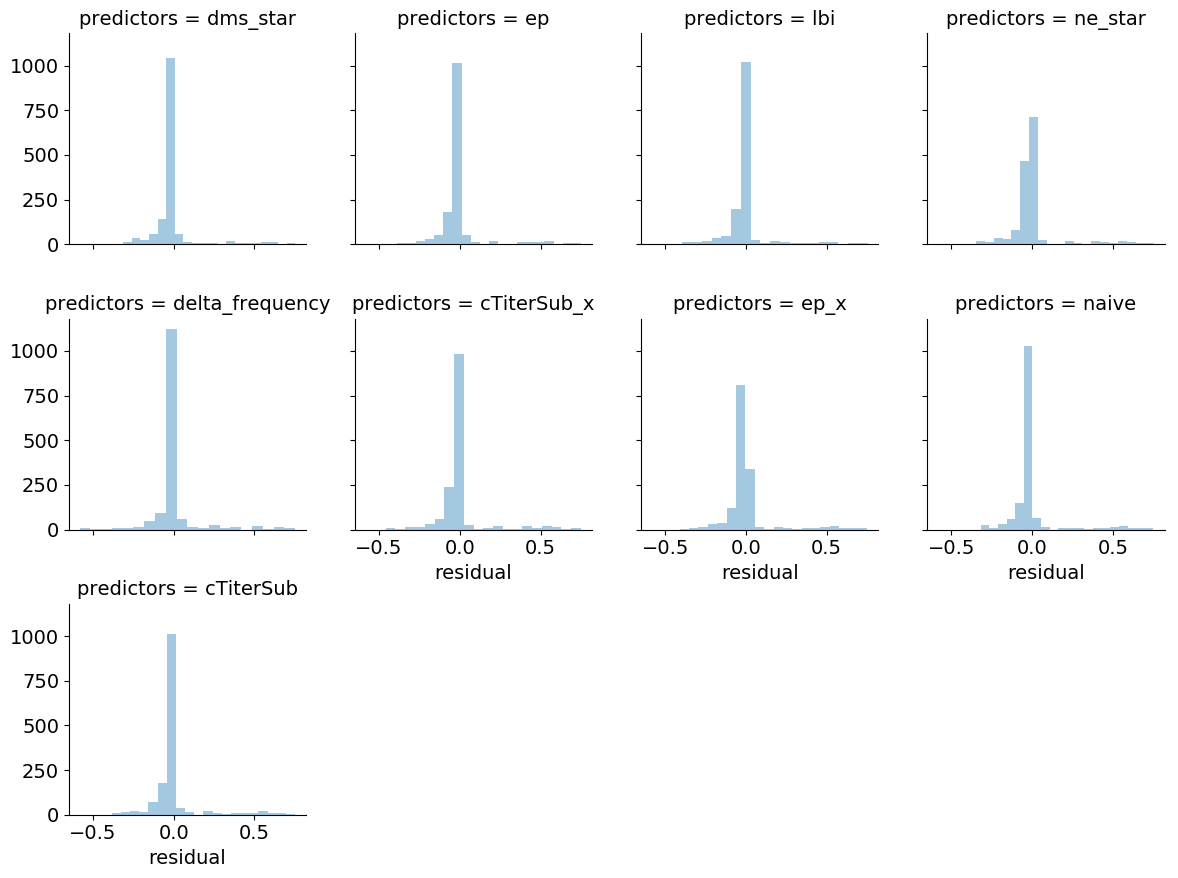

In [582]:
g = sns.FacetGrid(residual_df, col="predictors", col_wrap=4)
g.map(sns.distplot, "residual", bins=20, kde=False)

In [583]:
residual_df.groupby("predictors")["residual"].median().sort_values()

predictors
naive             -0.014657
ep_x              -0.014637
cTiterSub         -0.014290
ep                -0.014233
ne_star           -0.014044
cTiterSub_x       -0.012072
dms_star          -0.010964
delta_frequency   -0.006814
lbi               -0.006496
Name: residual, dtype: float64

In [584]:
residual_df.groupby("predictors")["residual"].count()

predictors
cTiterSub          1476
cTiterSub_x        1476
delta_frequency    1476
dms_star           1476
ep                 1476
ep_x               1476
lbi                1476
naive              1476
ne_star            1476
Name: residual, dtype: int64

In [585]:
(residual_df["residual"] < -0.01).sum()

6984

### Residuals by timepoint

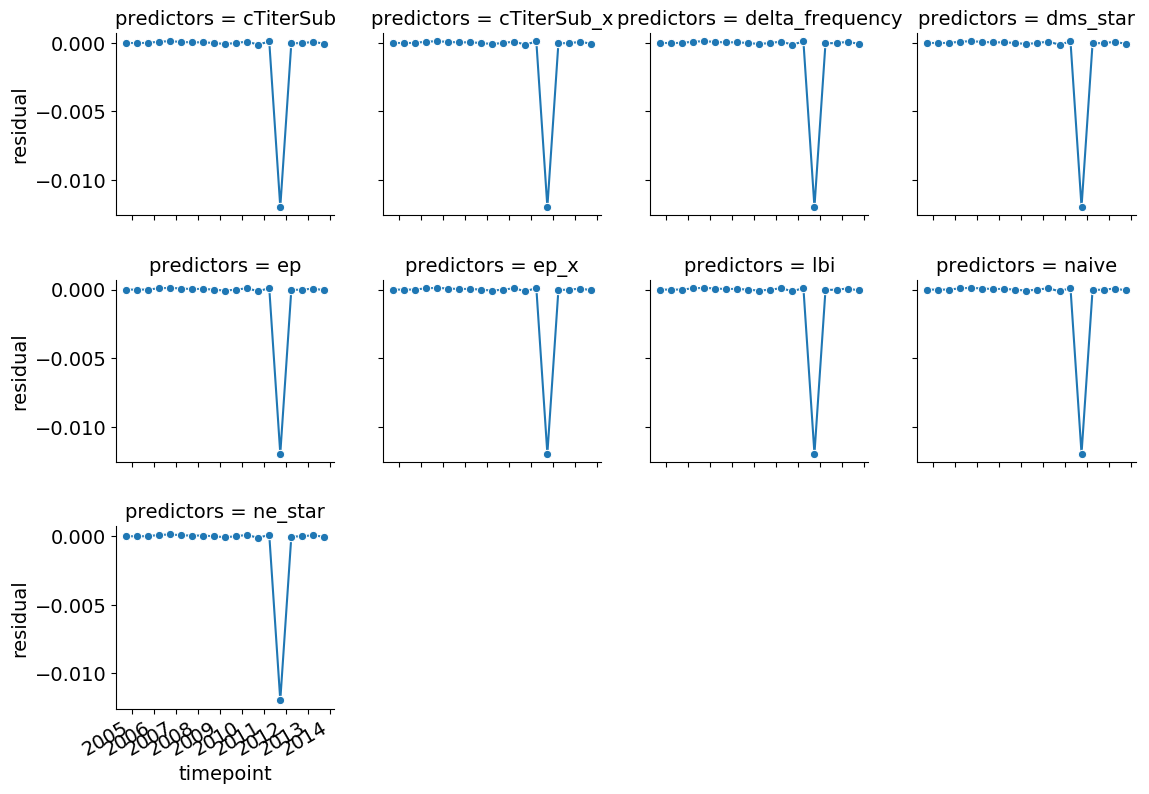

In [586]:
g = sns.FacetGrid(residuals_by_timepoint, col="predictors", col_wrap=4)
g.map(sns.lineplot, "timepoint", "residual", marker="o", linestyle="")
plt.gcf().autofmt_xdate()

In [587]:
np.abs(residuals_by_timepoint[residuals_by_timepoint["predictors"] == "lbi"]["residual"].values - residuals_by_timepoint[residuals_by_timepoint["predictors"] == "naive"]["residual"].values)

array([2.77555756e-16, 4.15803392e-16, 1.80411242e-16, 2.17707796e-16,
       5.55111512e-17, 7.95804395e-16, 1.18590034e-15, 1.29757316e-15,
       2.27248775e-15, 5.44009282e-15, 5.89805982e-16, 7.91033905e-16,
       1.10089889e-15, 2.94035629e-16, 4.89192020e-16, 2.35922393e-15,
       6.86950496e-16, 1.73472348e-18, 2.13154147e-16])

### Autocorrelation of residuals

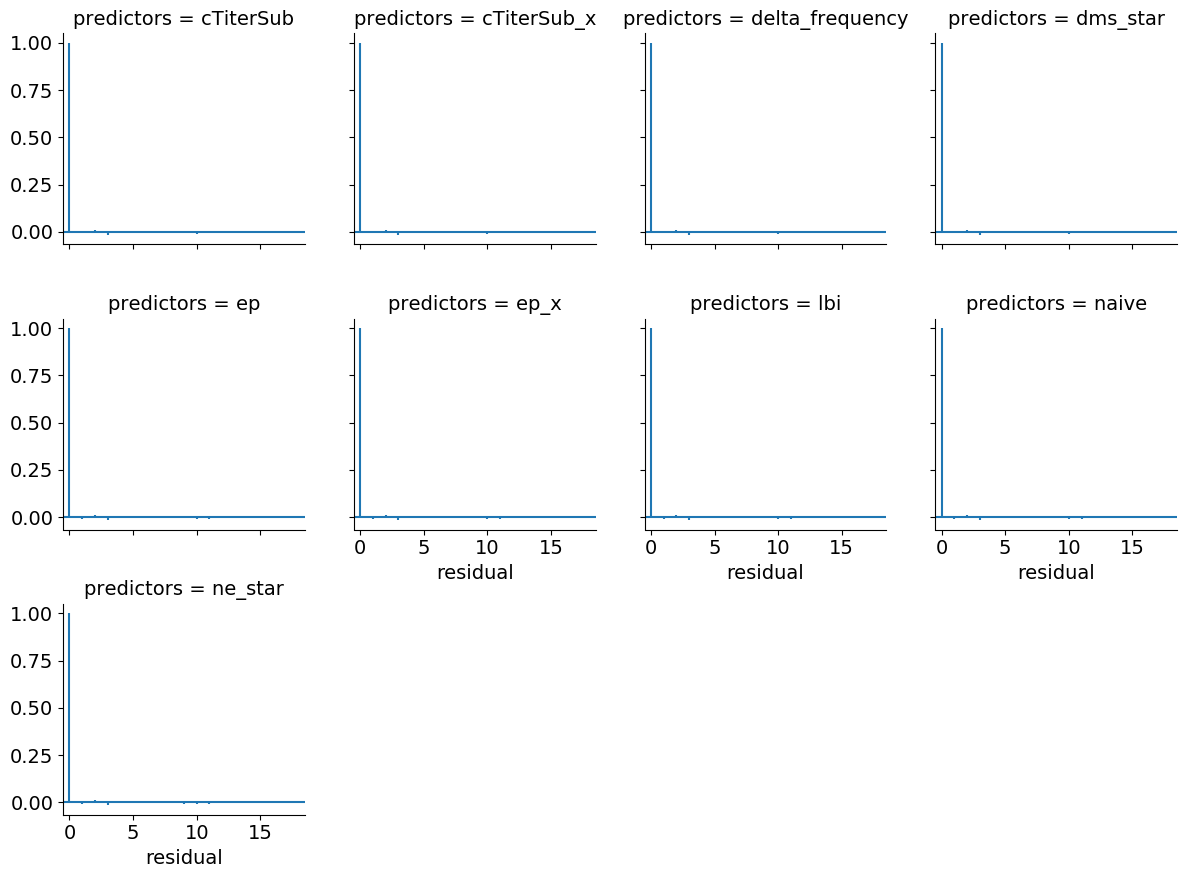

In [588]:
g = sns.FacetGrid(residuals_by_timepoint, col="predictors", col_wrap=4)
g.map(plt.acorr, "residual", maxlags=max_lags)

for ax in g.axes.flatten():
    ax.set_xlim(-0.5, max_lags + 0.5)

## Summarize observed and predicted frequencies and growth rates

### Observed and predicted frequencies

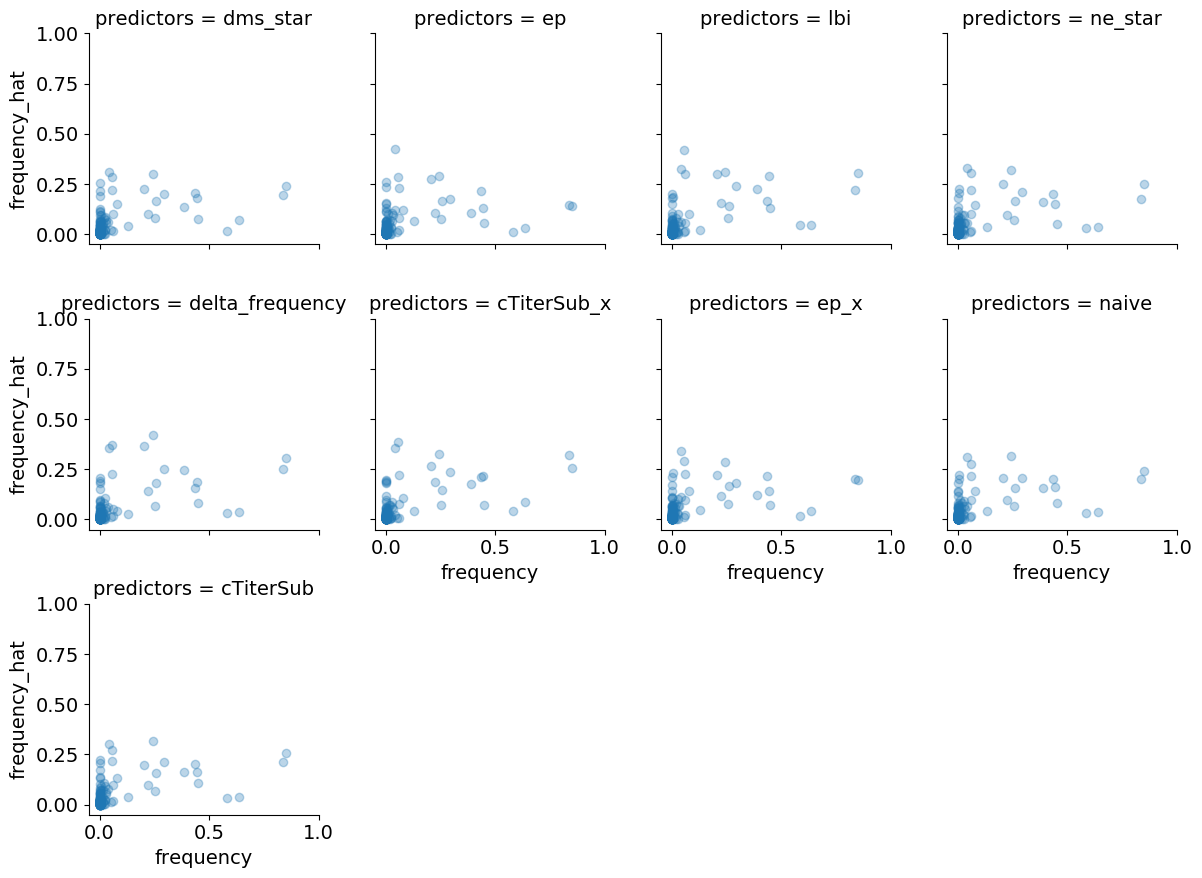

In [589]:
g = sns.FacetGrid(frequency_df, col="predictors", col_wrap=4)
g.map(plt.plot, "frequency", "frequency_hat", marker="o", linestyle="", alpha=0.3)

for ax in g.axes.flatten():
    ax.set_xlim(-0.05, 1)
    ax.set_ylim(-0.05, 1)

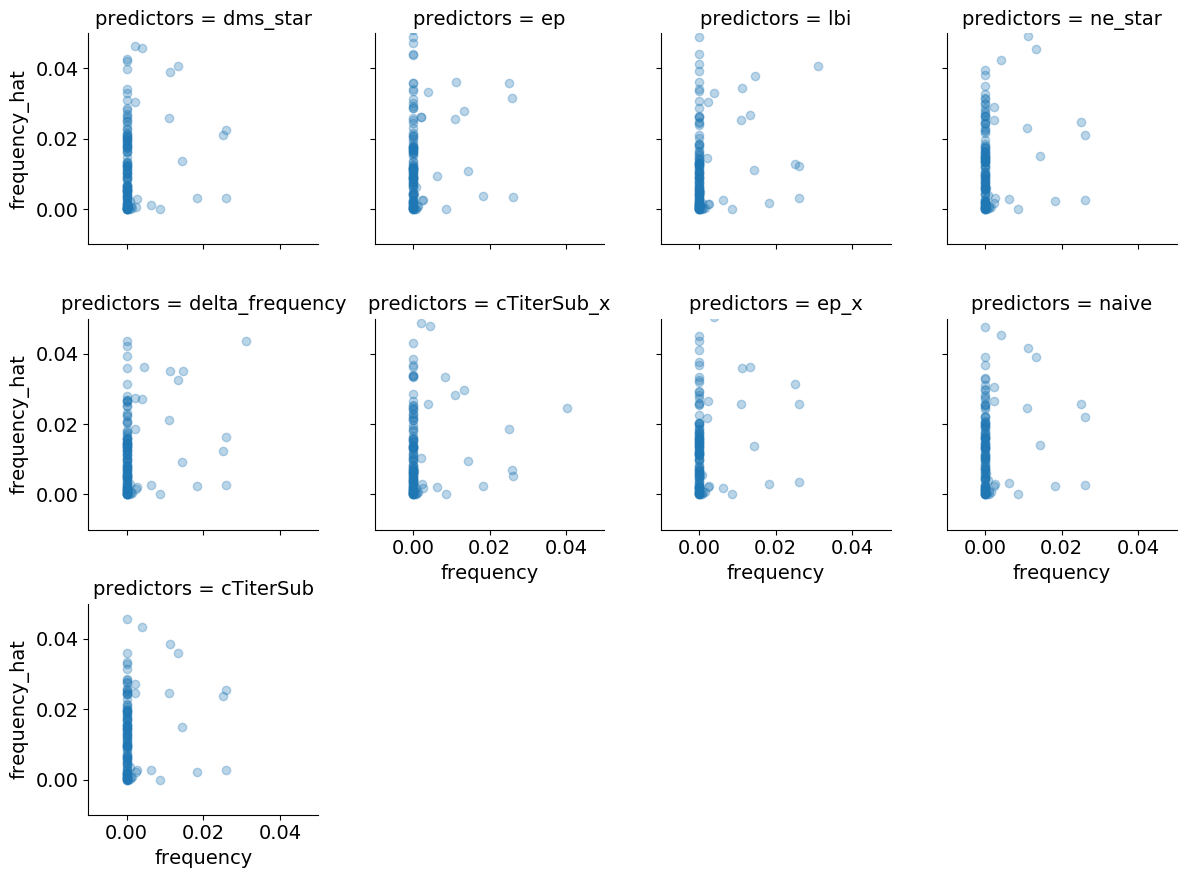

In [590]:
g = sns.FacetGrid(frequency_df, col="predictors", col_wrap=4)
g.map(plt.plot, "frequency", "frequency_hat", marker="o", linestyle="", alpha=0.3)

for ax in g.axes.flatten():
    ax.set_xlim(-0.01, 0.05)
    ax.set_ylim(-0.01, 0.05)

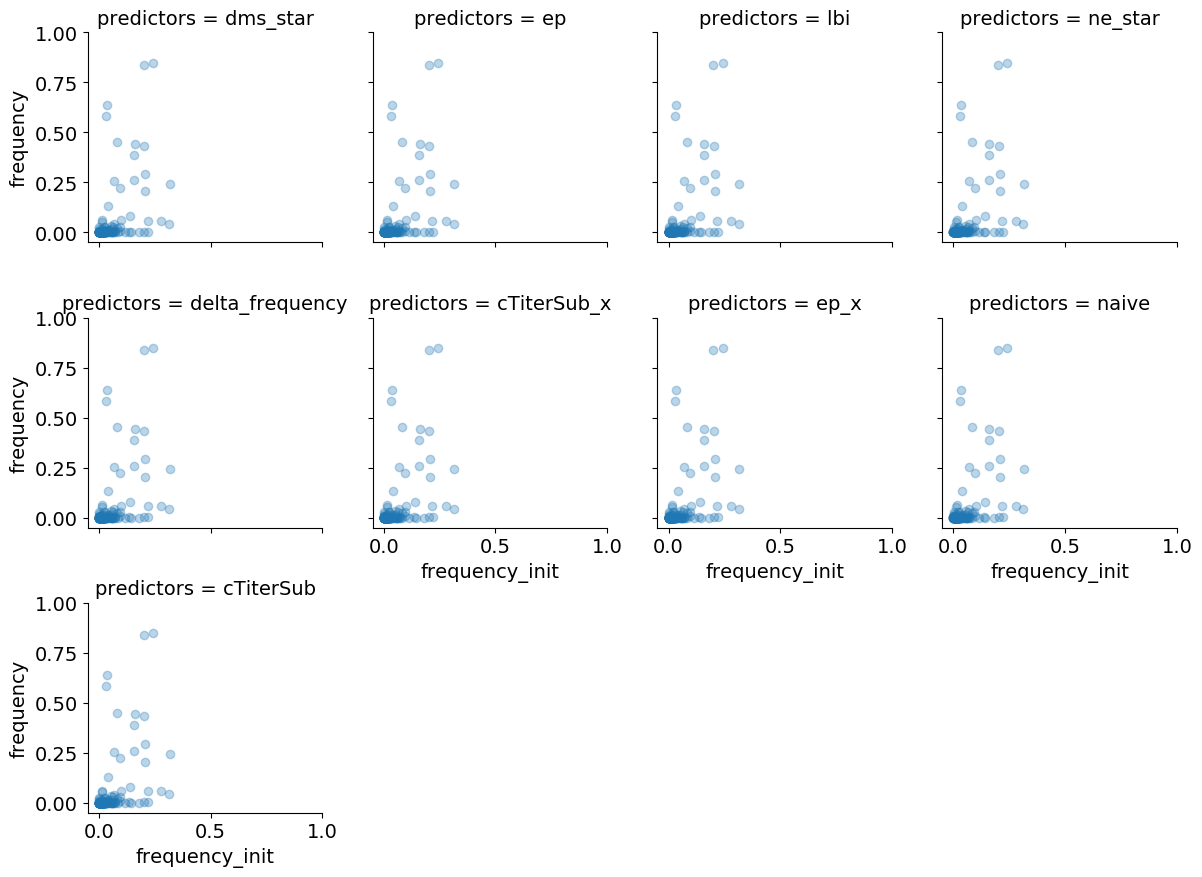

In [591]:
g = sns.FacetGrid(frequency_df, col="predictors", col_wrap=4)
g.map(plt.plot, "frequency_init", "frequency", marker="o", linestyle="", alpha=0.3)

for ax in g.axes.flatten():
    ax.set_xlim(-0.05, 1)
    ax.set_ylim(-0.05, 1)

In [592]:
(frequency_df["frequency_init"] < 0.01).sum()

486

In [593]:
(frequency_df["frequency_init"] >= 0.01).sum()

1008

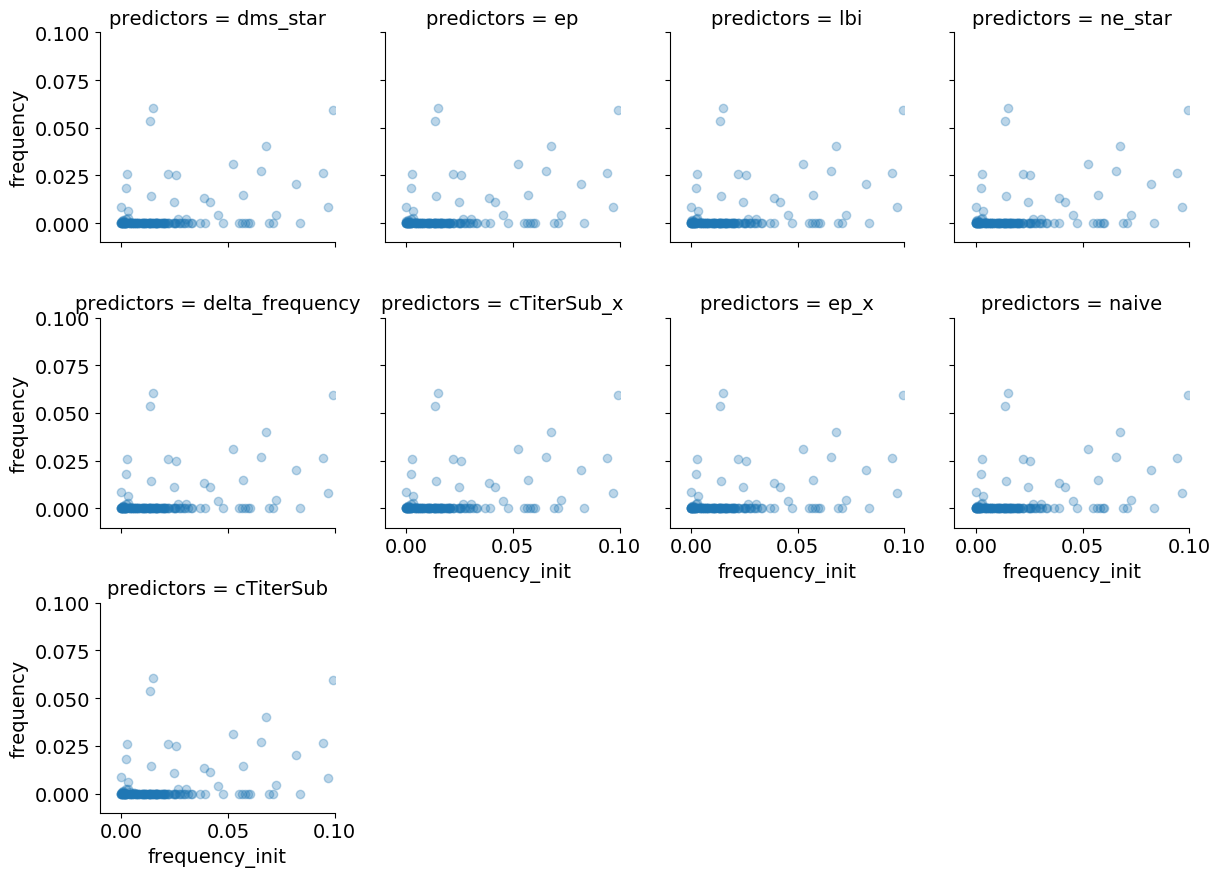

In [594]:
g = sns.FacetGrid(frequency_df, col="predictors", col_wrap=4)
g.map(plt.plot, "frequency_init", "frequency", marker="o", linestyle="", alpha=0.3)

for ax in g.axes.flatten():
    ax.set_xlim(-0.01, 0.1)
    ax.set_ylim(-0.01, 0.1)

In [595]:
frequency_df[frequency_df["predictors"] == "lbi"]["frequency"].shape

(166,)

In [596]:
(frequency_df[frequency_df["predictors"] == "lbi"]["frequency"] == 0.0).sum()

107

In [597]:
(frequency_df[frequency_df["predictors"] == "lbi"]["frequency_init"] < 0.01).sum()

54

In [598]:
(frequency_df[frequency_df["predictors"] == "lbi"]["frequency_init"] >= 0.01).sum()

112

In [599]:
(frequency_df[frequency_df["predictors"] == "lbi"]["frequency_init"] < 0.01).sum() / frequency_df[frequency_df["predictors"] == "lbi"]["frequency"].shape

array([0.3253012])

In [600]:
(frequency_df[frequency_df["predictors"] == "lbi"]["frequency_init"] < 0.05).sum()

127

In [601]:
(frequency_df[frequency_df["predictors"] == "lbi"]["frequency_init"] < 0.05).sum() / frequency_df[frequency_df["predictors"] == "lbi"]["frequency"].shape

array([0.76506024])

### Observed and predicted growth rates for training timepoints

In [602]:
residual_df.head()

clade_membership  frequency  timepoint  frequency_hat  residual  \
0          06ed3c7   0.000000 2004-10-01       0.061800 -0.061800   
1          31e4ba2   0.000000 2004-10-01       0.027706 -0.027706   
2          412c00a   0.000000 2004-10-01       0.006543 -0.006543   
3          44989e1   0.018695 2004-10-01       0.087227 -0.068532   
4          4952842   0.000000 2004-10-01       0.000394 -0.000394   

  validation_timepoint predictors  frequency_init  observed_growth_rate  \
0           2011-10-01   dms_star        0.064648              0.000000   
1           2011-10-01   dms_star        0.030862              0.000000   
2           2011-10-01   dms_star        0.017579              0.000000   
3           2011-10-01   dms_star        0.128015              0.146038   
4           2011-10-01   dms_star        0.000583              0.000000   

   predicted_growth_rate  
0               0.955939  
1               0.897724  
2               0.372209  
3               0.681377  
4               0.676068

In [603]:
residual_df.groupby("predictors").apply(
    lambda records: pearsonr(records["observed_growth_rate"], records["predicted_growth_rate"])[0]
).sort_values()

predictors
ep                -0.018215
lbi               -0.017938
ne_star           -0.006895
dms_star           0.033034
delta_frequency    0.034479
cTiterSub_x        0.042168
ep_x               0.060646
naive              0.096446
cTiterSub          0.105115
dtype: float64

In [604]:
correlation_by_predictors_and_timepoint = residual_df.groupby(["predictors", "validation_timepoint"]).apply(
    lambda records: pearsonr(records["observed_growth_rate"], records["predicted_growth_rate"])[0]
).reset_index().rename(columns={0: "training_correlation"})

In [605]:
print(correlation_by_predictors_and_timepoint[correlation_by_predictors_and_timepoint["predictors"] == "ep"])

   predictors validation_timepoint  training_correlation
28         ep           2011-10-01             -0.021554
29         ep           2012-04-01              0.008036
30         ep           2012-10-01              0.038138
31         ep           2013-04-01              0.052188
32         ep           2013-10-01             -0.055193
33         ep           2014-04-01             -0.051533
34         ep           2014-10-01             -0.053551


In [606]:
residual_df.head()

clade_membership  frequency  timepoint  frequency_hat  residual  \
0          06ed3c7   0.000000 2004-10-01       0.061800 -0.061800   
1          31e4ba2   0.000000 2004-10-01       0.027706 -0.027706   
2          412c00a   0.000000 2004-10-01       0.006543 -0.006543   
3          44989e1   0.018695 2004-10-01       0.087227 -0.068532   
4          4952842   0.000000 2004-10-01       0.000394 -0.000394   

  validation_timepoint predictors  frequency_init  observed_growth_rate  \
0           2011-10-01   dms_star        0.064648              0.000000   
1           2011-10-01   dms_star        0.030862              0.000000   
2           2011-10-01   dms_star        0.017579              0.000000   
3           2011-10-01   dms_star        0.128015              0.146038   
4           2011-10-01   dms_star        0.000583              0.000000   

   predicted_growth_rate  
0               0.955939  
1               0.897724  
2               0.372209  
3               0.681377  
4               0.676068

In [607]:
(residual_df["predictors"] == "lbi").sum()

1476

In [608]:
((residual_df["predictors"] == "lbi") & (residual_df["frequency_init"] > 0.01)).sum()

1011

In [609]:
((residual_df["predictors"] == "lbi") & (residual_df["frequency_init"] > 0.05)).sum()

409

In [610]:
((residual_df["predictors"] == "lbi") & (residual_df["frequency_init"] > 0.1)).sum()

231

In [611]:
((residual_df["predictors"] == "lbi") & (residual_df["frequency_init"] > 0.15)).sum()

160

(array([116.,  25.,   0.,   7.,   6.,   4.,   0.,   3.,   3.,   0.,   7.,
          0.,   0.,   0.,   7.,   0.,   4.,   7.,  16.]),
 array([0.  , 0.05, 0.1 , 0.15, 0.2 , 0.25, 0.3 , 0.35, 0.4 , 0.45, 0.5 ,
        0.55, 0.6 , 0.65, 0.7 , 0.75, 0.8 , 0.85, 0.9 , 0.95]),
 <a list of 19 Patch objects>)

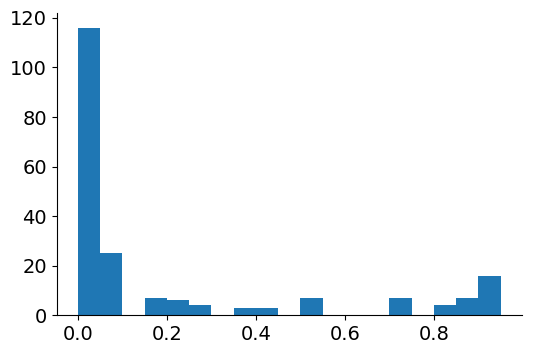

In [612]:
plt.hist(residual_df[((residual_df["predictors"] == "lbi") & (residual_df["frequency_init"] > 0.1))]["frequency"],
        bins=np.arange(0, 1.0, 0.05))

### Observed and predicted growth rates for validation timepoints

In [613]:
validation_correlation_by_predictors_and_timepoint = frequency_df.groupby(["predictors", "validation_timepoint"]).apply(
    lambda records: pearsonr(records["observed_growth_rate"], records["predicted_growth_rate"])[0]
).reset_index().rename(columns={0: "testing_correlation"})

In [614]:
print(validation_correlation_by_predictors_and_timepoint[validation_correlation_by_predictors_and_timepoint["predictors"] == "ep"])

   predictors validation_timepoint  testing_correlation
28         ep           2011-10-01            -0.046119
29         ep           2012-04-01             0.010675
30         ep           2012-10-01             0.038619
31         ep           2013-04-01            -0.353919
32         ep           2013-10-01             0.228119
33         ep           2014-04-01            -0.058964
34         ep           2014-10-01            -0.266037


In [615]:
merged_correlation_by_predictors_and_timepoint = correlation_by_predictors_and_timepoint.merge(
    validation_correlation_by_predictors_and_timepoint,
    on=["predictors", "validation_timepoint"]
)

In [616]:
print(merged_correlation_by_predictors_and_timepoint.loc[
    merged_correlation_by_predictors_and_timepoint["predictors"] == "ep",
    ["validation_timepoint", "training_correlation", "testing_correlation"]
].rename(columns={"validation_timepoint": "test_timepoint"}))

   test_timepoint  training_correlation  testing_correlation
28     2011-10-01             -0.021554            -0.046119
29     2012-04-01              0.008036             0.010675
30     2012-10-01              0.038138             0.038619
31     2013-04-01              0.052188            -0.353919
32     2013-10-01             -0.055193             0.228119
33     2014-04-01             -0.051533            -0.058964
34     2014-10-01             -0.053551            -0.266037


In [617]:
frequency_df[frequency_df["predictors"] == "lbi"].shape

(166, 10)

In [618]:
frequency_df[frequency_df["predictors"] == "lbi"].head()

clade_membership  frequency  timepoint  frequency_hat  frequency_init  \
332          026d21f   0.001468 2011-10-01       0.000340        0.000710   
333          05daa66   0.002323 2011-10-01       0.001362        0.002257   
334          15db5d7   0.000000 2011-10-01       0.006003        0.012943   
335          1e46575   0.000000 2011-10-01       0.009165        0.015778   
336          24fc224   0.000000 2011-10-01       0.001124        0.002445   

     residual  observed_growth_rate  predicted_growth_rate  \
332  0.001128              2.067606               0.478304   
333  0.000961              1.029242               0.603673   
334 -0.006003              0.000000               0.463819   
335 -0.009165              0.000000               0.580856   
336 -0.001124              0.000000               0.459703   

    validation_timepoint predictors  
332           2011-10-01        lbi  
333           2011-10-01        lbi  
334           2011-10-01        lbi  
335           2011-10-01        lbi  
336           2011-10-01        lbi

In [619]:
frequency_df[frequency_df["predictors"] == "lbi"]["clade_membership"].unique().shape

(93,)

In [620]:
# Clades that died.
(frequency_df[frequency_df["predictors"] == "lbi"]["observed_growth_rate"] == 0.0).sum()

107

In [621]:
# Clades that declined but did not die.
((frequency_df[frequency_df["predictors"] == "lbi"]["observed_growth_rate"] > 0.0) &
 (frequency_df[frequency_df["predictors"] == "lbi"]["observed_growth_rate"] < 1.0)).sum()

33

In [622]:
# Clades that did not change frequency.
(frequency_df[frequency_df["predictors"] == "lbi"]["observed_growth_rate"] == 1.0).sum()

0

In [623]:
# Clades that grew.
(frequency_df[frequency_df["predictors"] == "lbi"]["observed_growth_rate"] > 1.0).sum()

26

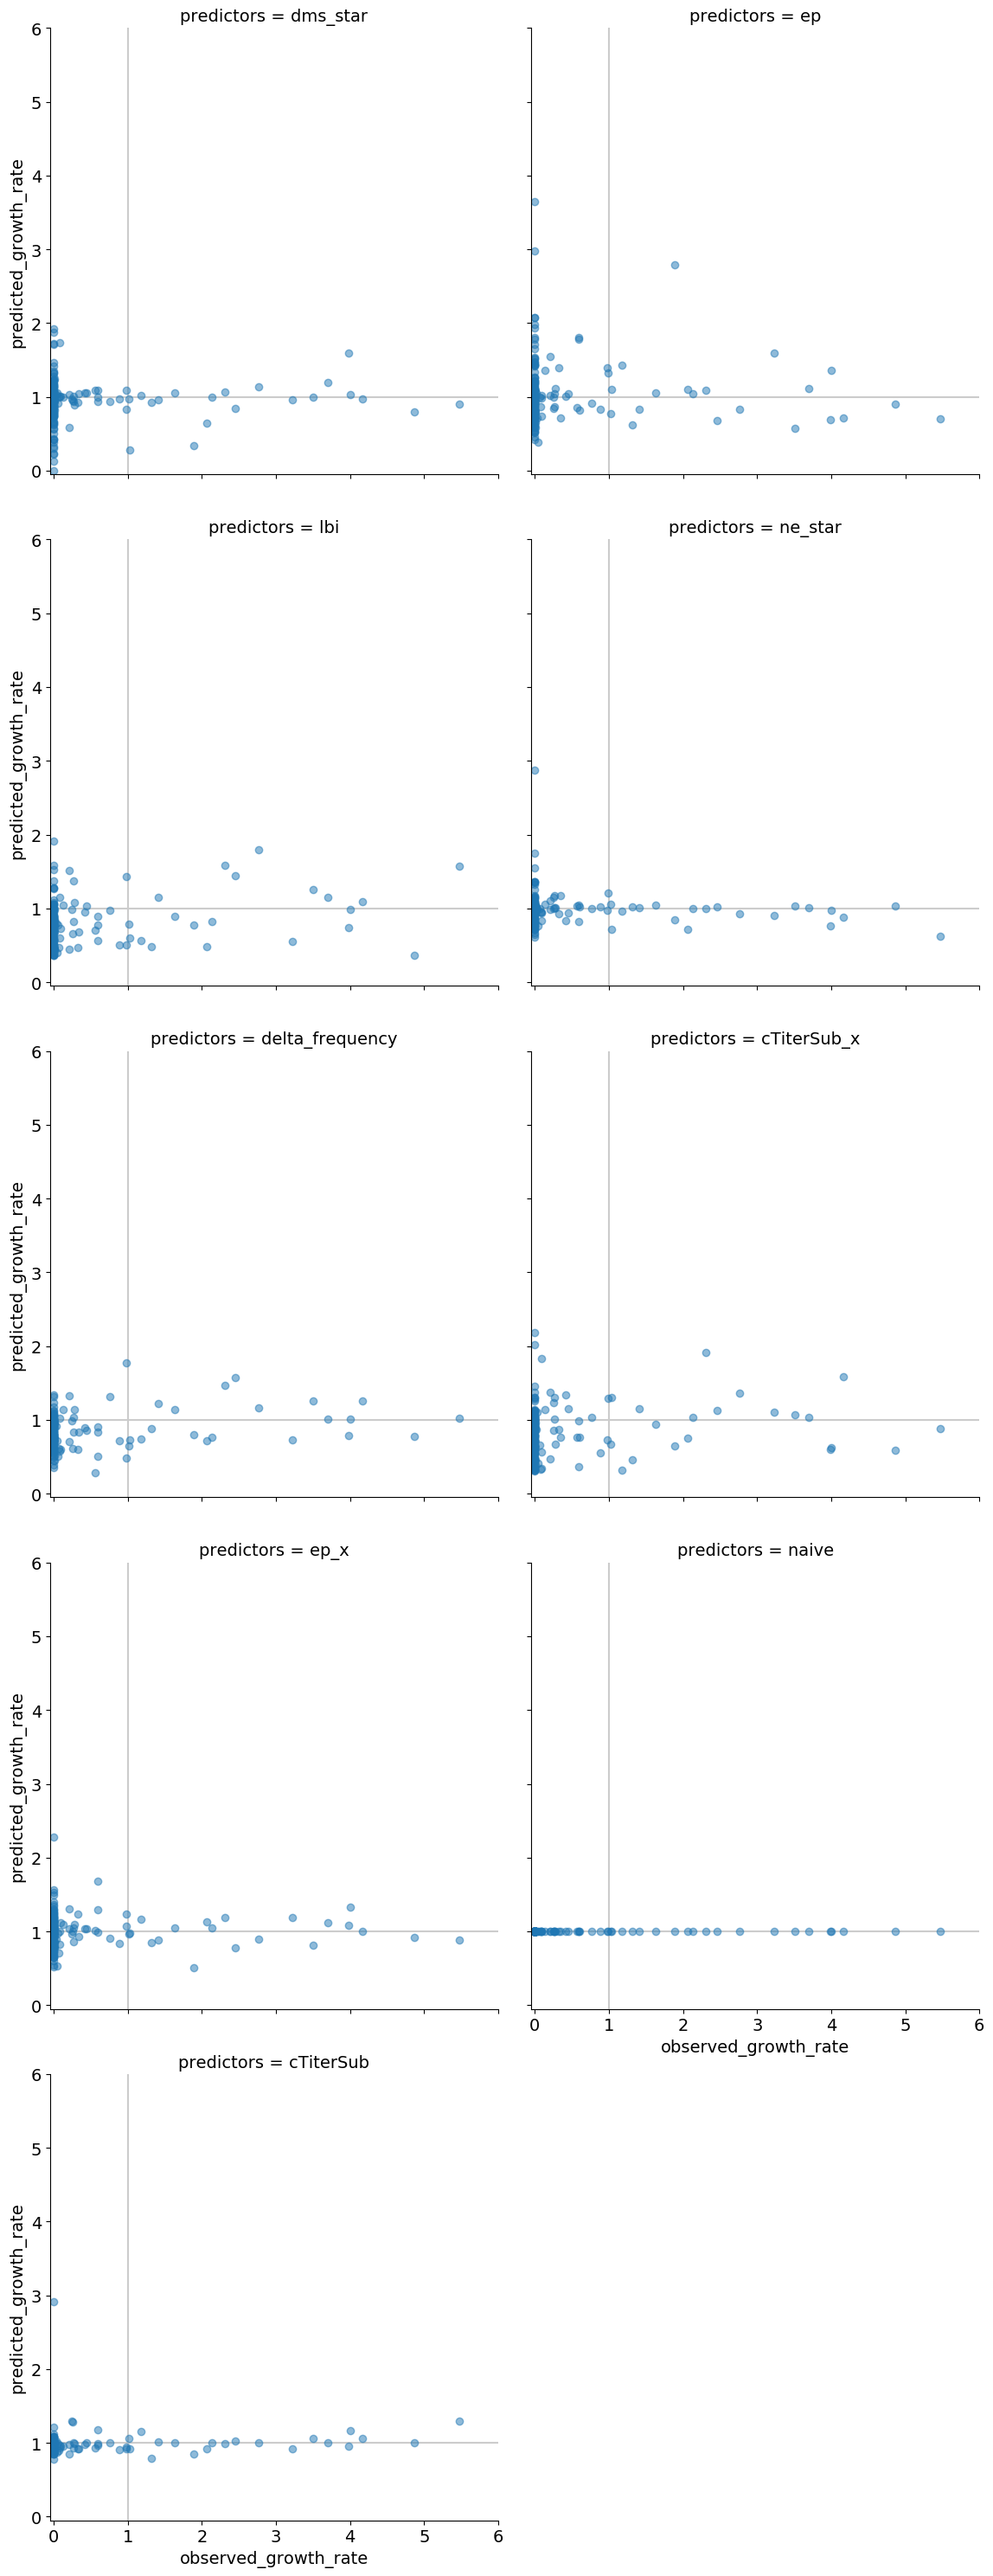

In [624]:
g = sns.FacetGrid(frequency_df, col="predictors", col_wrap=2, height=6, aspect=1.)
g.map(plt.plot, "observed_growth_rate", "predicted_growth_rate", marker="o", linestyle="", alpha=0.5)

for ax in g.axes.flatten():
    ax.axhline(y=1.0, color="#cccccc", zorder=-10)
    ax.axvline(x=1.0, color="#cccccc", zorder=-10)
    ax.set_xlim(-0.05, 6)
    ax.set_ylim(-0.05, 6)

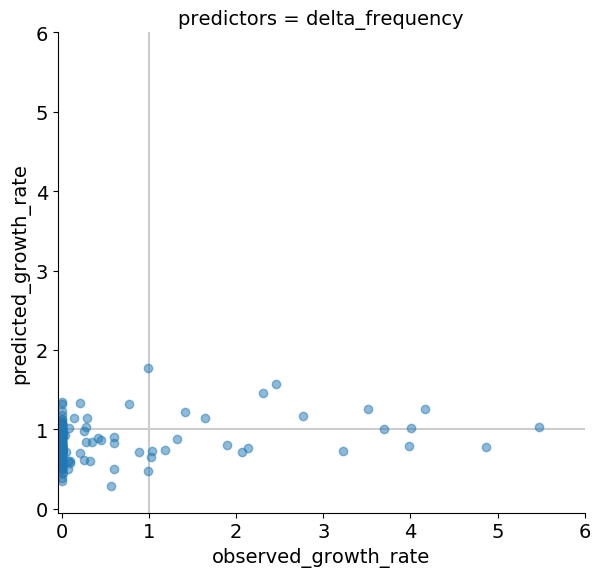

In [625]:
g = sns.FacetGrid(frequency_df[frequency_df["predictors"] == "delta_frequency"], col="predictors", col_wrap=2, height=6, aspect=1.)
g.map(plt.plot, "observed_growth_rate", "predicted_growth_rate", marker="o", linestyle="", alpha=0.5)

for ax in g.axes.flatten():
    ax.axhline(y=1.0, color="#cccccc", zorder=-10)
    ax.axvline(x=1.0, color="#cccccc", zorder=-10)
    ax.set_xlim(-0.05, 6)
    ax.set_ylim(-0.05, 6)

In [626]:
frequency_df.head()

clade_membership  frequency  timepoint  frequency_hat  frequency_init  \
0          026d21f   0.001468 2011-10-01       0.000454        0.000710   
1          05daa66   0.002323 2011-10-01       0.000631        0.002257   
2          15db5d7   0.000000 2011-10-01       0.011897        0.012943   
3          1e46575   0.000000 2011-10-01       0.026933        0.015778   
4          24fc224   0.000000 2011-10-01       0.001591        0.002445   

   residual  observed_growth_rate  predicted_growth_rate validation_timepoint  \
0  0.001014              2.067606               0.639081           2011-10-01   
1  0.001692              1.029242               0.279575           2011-10-01   
2 -0.011897              0.000000               0.919208           2011-10-01   
3 -0.026933              0.000000               1.706970           2011-10-01   
4 -0.001591              0.000000               0.650775           2011-10-01   

  predictors  
0   dms_star  
1   dms_star  
2   dms_star  
3   dms_star  
4   dms_star

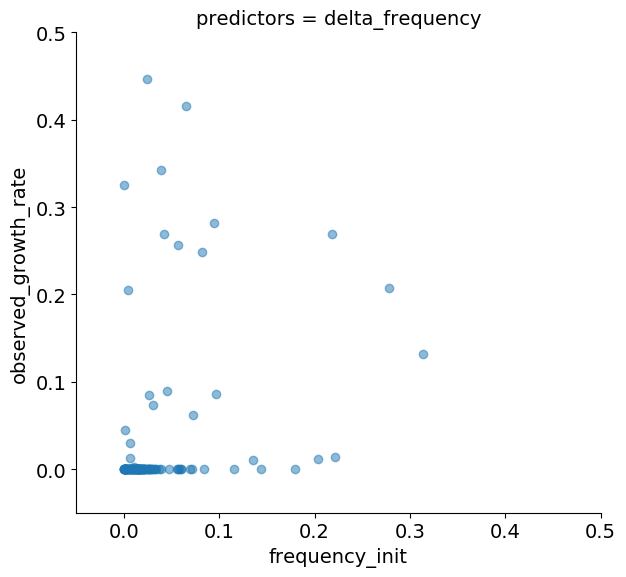

In [627]:
g = sns.FacetGrid(frequency_df[frequency_df["predictors"] == "delta_frequency"], col="predictors", col_wrap=2, height=6, aspect=1.)
g.map(plt.plot, "frequency_init", "observed_growth_rate", marker="o", linestyle="", alpha=0.5)

for ax in g.axes.flatten():
    ax.axhline(y=1.0, color="#cccccc", zorder=-10)
    ax.axvline(x=1.0, color="#cccccc", zorder=-10)
    ax.set_xlim(-0.05, 0.5)
    ax.set_ylim(-0.05, 0.5)

In [628]:
frequency_df.loc[frequency_df["observed_growth_rate"].idxmax()]

clade_membership                     41bb3e2
frequency                           0.008698
timepoint                2012-10-01 00:00:00
frequency_hat                    5.25437e-06
frequency_init                         3e-06
residual                          0.00869275
observed_growth_rate                 2899.33
predicted_growth_rate                1.75146
validation_timepoint     2012-10-01 00:00:00
predictors                          dms_star
Name: 57, dtype: object

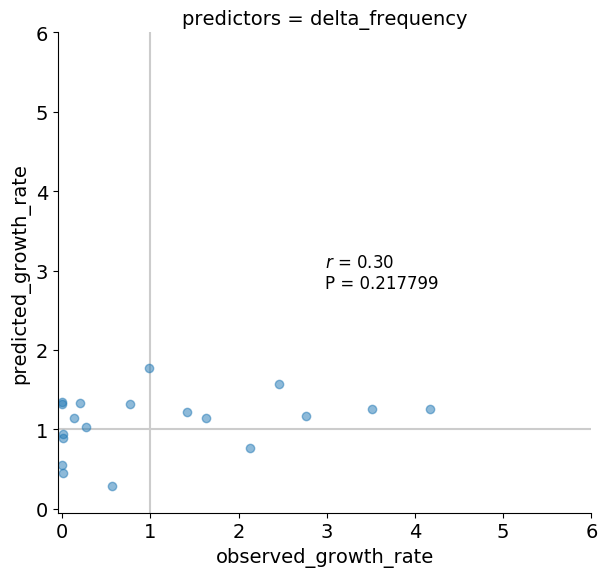

In [629]:
high_frequency_clades = frequency_df[(frequency_df["predictors"] == "delta_frequency") & (frequency_df["frequency_init"] > 0.1)]

correlation, pvalue = pearsonr(high_frequency_clades["observed_growth_rate"], high_frequency_clades["predicted_growth_rate"])

g = sns.FacetGrid(high_frequency_clades, col="predictors", col_wrap=2, height=6, aspect=1.)
g.map(plt.plot, "observed_growth_rate", "predicted_growth_rate", marker="o", linestyle="", alpha=0.5)

for ax in g.axes.flatten():
    ax.axhline(y=1.0, color="#cccccc", zorder=-10)
    ax.axvline(x=1.0, color="#cccccc", zorder=-10)
    ax.set_xlim(-0.05, 6)
    ax.set_ylim(-0.05, 6)
    
    ax.text(
        0.5,
        0.5,
        "$r$ = %.2f\nP = %f" % (correlation, pvalue),
        horizontalalignment="left",
        verticalalignment="center",
        transform=ax.transAxes,
        fontsize=12
    )

## Summarize model forecasting error

## Information gain (negative)

In [403]:
errors_by_time_df.head()

predictors  validation_error  validation_n validation_timepoint
0   dms_star          0.035644            24           2011-10-01
1   dms_star         -0.017430            25           2012-04-01
2   dms_star          0.349120            30           2012-10-01
3   dms_star         -0.056585            19           2013-04-01
4   dms_star         -0.029279            14           2013-10-01

In [404]:
negative_information_gain_df = errors_by_time_df.groupby("predictors")["validation_error"].aggregate([
    "sum",
    "mean",
    "median"
]).sort_values(by="sum").reset_index()

In [405]:
negative_information_gain_df

predictors       sum      mean    median
0            lbi-cTiterSub_x -2.043923 -0.291989 -0.249915
1                cTiterSub_x -1.448510 -0.206930 -0.158535
2                        lbi -1.200378 -0.171483 -0.165069
3        lbi-delta_frequency -0.856323 -0.122332 -0.118980
4            delta_frequency -0.756290 -0.108041 -0.159241
5                  cTiterSub -0.306008 -0.043715 -0.050301
6                   dms_star -0.138529 -0.019790 -0.017430
7           lbi-ep_x-ne_star -0.006015 -0.000859  0.043768
8                      naive -0.000063 -0.000009 -0.000006
9                    ne_star  0.311209  0.044458  0.017553
10                      ep_x  0.445604  0.063658  0.017602
11                        ep  1.509673  0.215668  0.122429
12  lbi-dms_star-cTiterSub_x  8.368722  1.195532 -0.034759

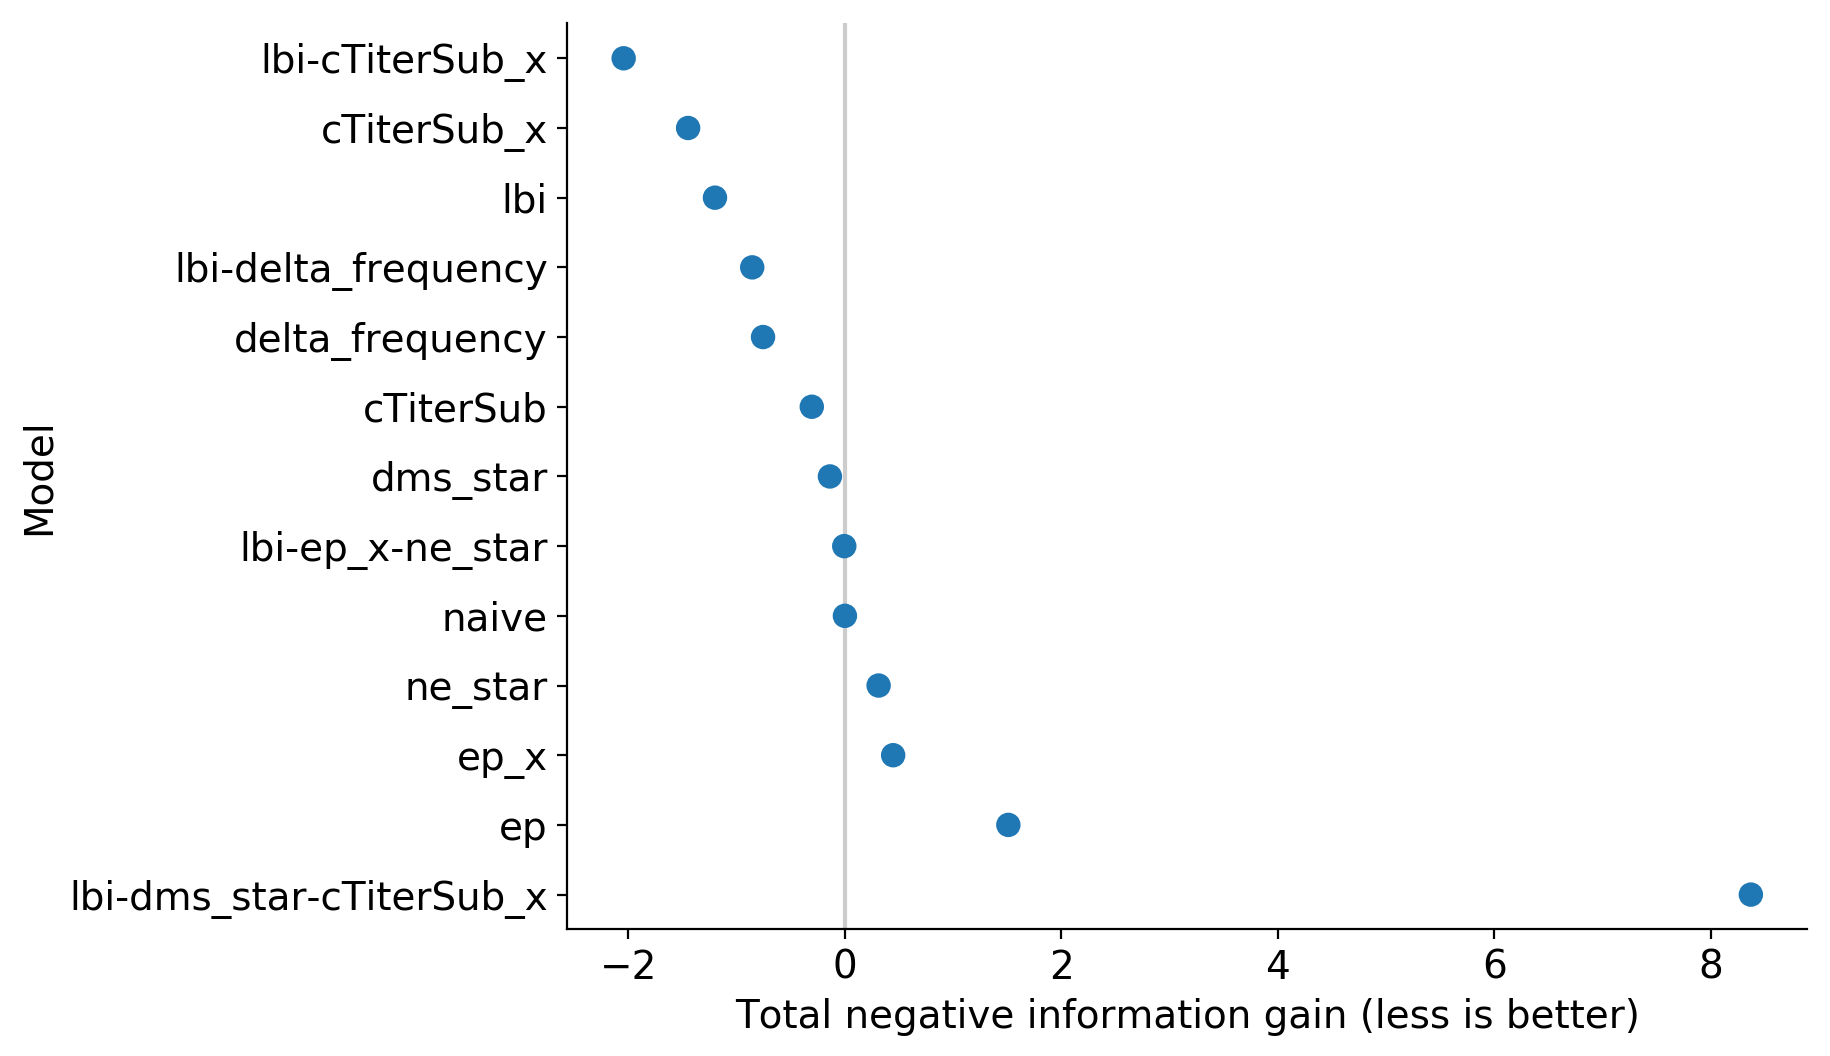

In [406]:
fig, ax = plt.subplots(1, 1, figsize=(8, 6))
sns.pointplot(
    x="sum",
    y="predictors",
    data=negative_information_gain_df,
    join=False,
    ax=ax
)
#ax.set_xlim(left=0)
ax.set_xlabel("Total negative information gain (less is better)")
ax.set_ylabel("Model")
ax.axvline(x=0.0, color="#cccccc", zorder=-10)

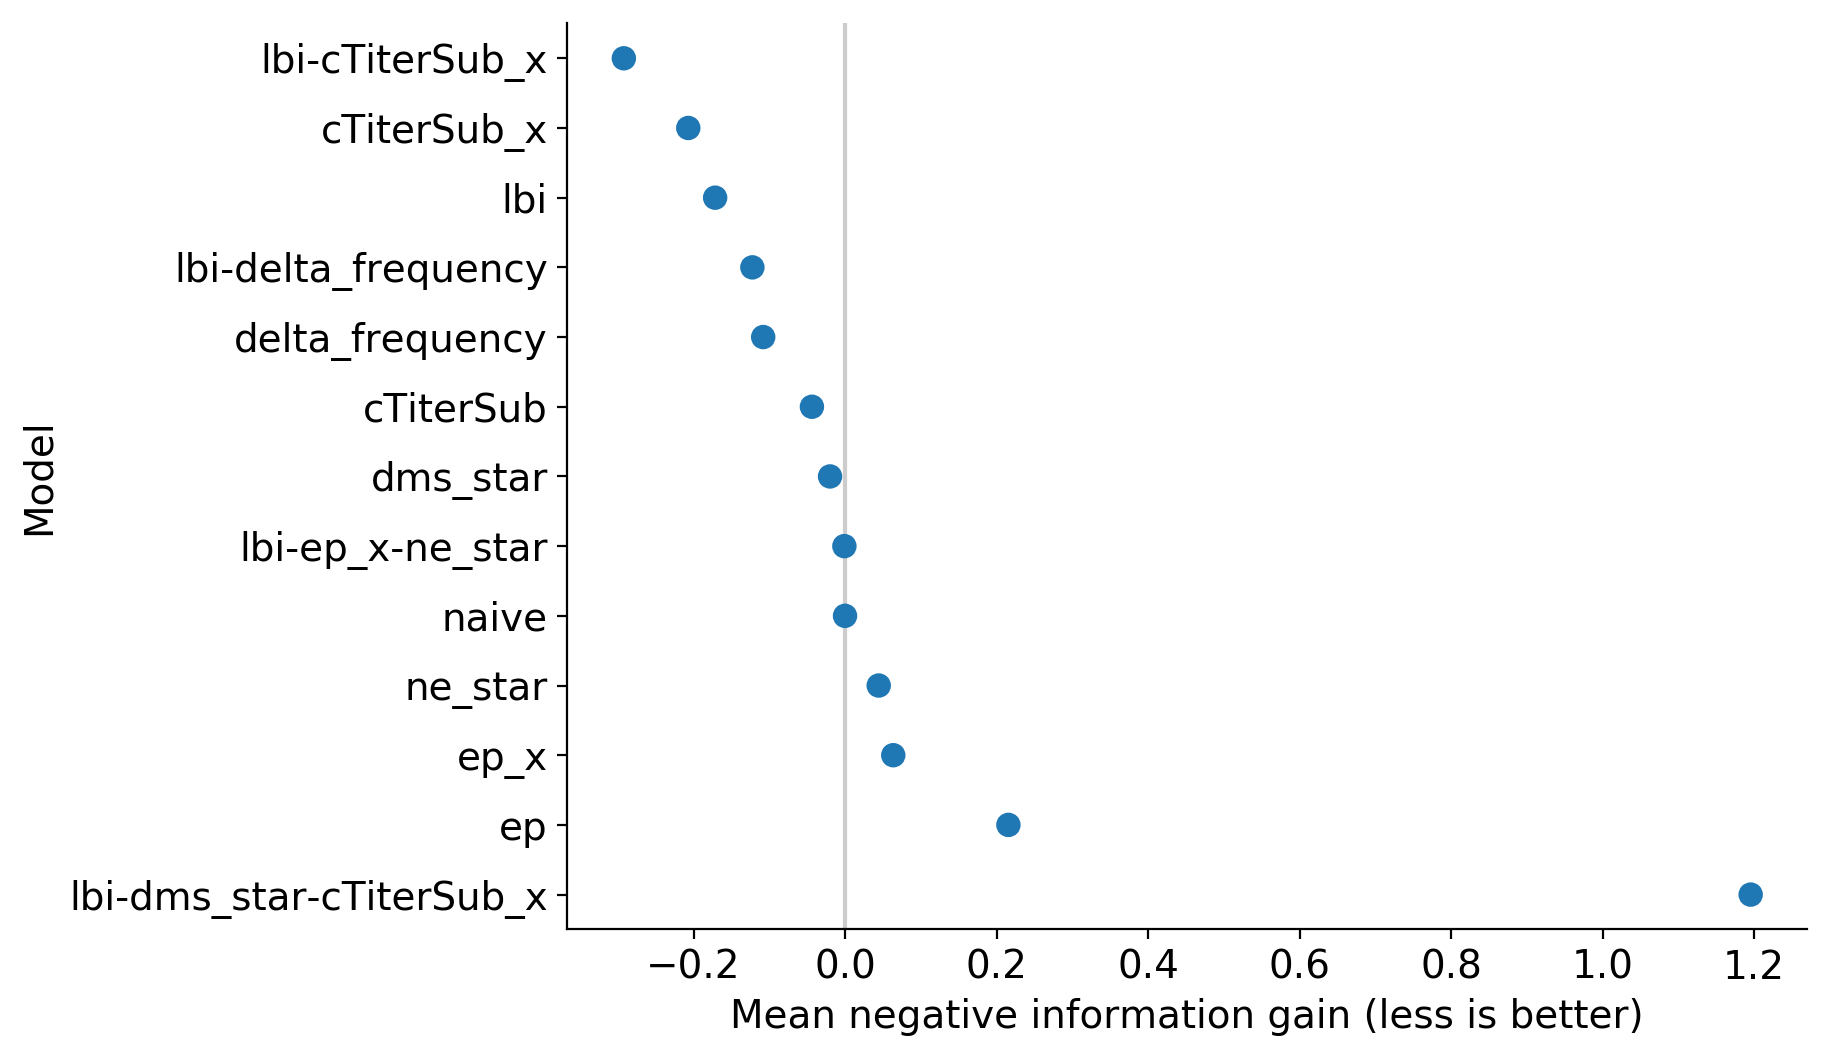

In [407]:
fig, ax = plt.subplots(1, 1, figsize=(8, 6))
sns.pointplot(
    x="mean",
    y="predictors",
    data=negative_information_gain_df,
    join=False,
    ax=ax
)
#ax.set_xlim(left=0)
ax.set_xlabel("Mean negative information gain (less is better)")
ax.set_ylabel("Model")
ax.axvline(x=0.0, color="#cccccc", zorder=-10)

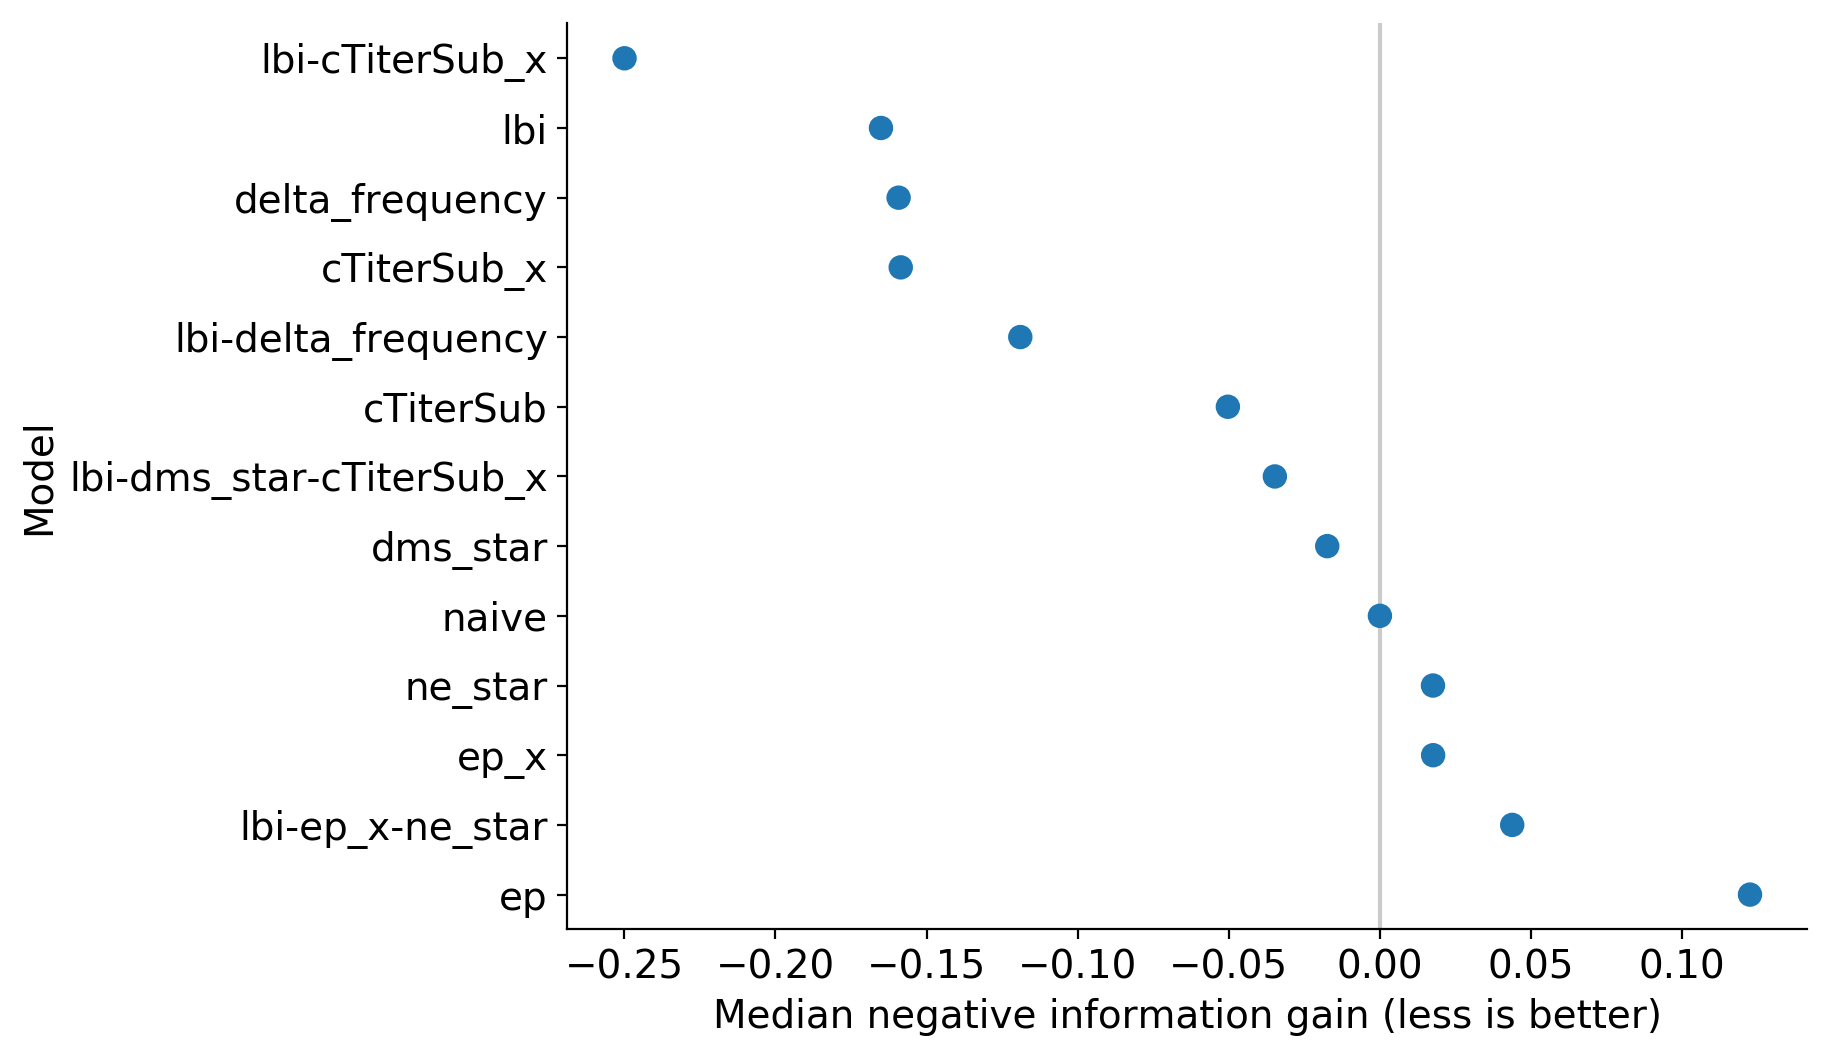

In [408]:
fig, ax = plt.subplots(1, 1, figsize=(8, 6))
sns.pointplot(
    x="median",
    y="predictors",
    data=negative_information_gain_df,
    join=False,
    ax=ax,
    order=negative_information_gain_df.sort_values("median").loc[:, "predictors"]
)
#ax.set_xlim(left=0)
ax.set_xlabel("Median negative information gain (less is better)")
ax.set_ylabel("Model")
ax.axvline(x=0.0, color="#cccccc", zorder=-10)

In [409]:
errors_by_time_df.head()

predictors  validation_error  validation_n validation_timepoint
0   dms_star          0.035644            24           2011-10-01
1   dms_star         -0.017430            25           2012-04-01
2   dms_star          0.349120            30           2012-10-01
3   dms_star         -0.056585            19           2013-04-01
4   dms_star         -0.029279            14           2013-10-01

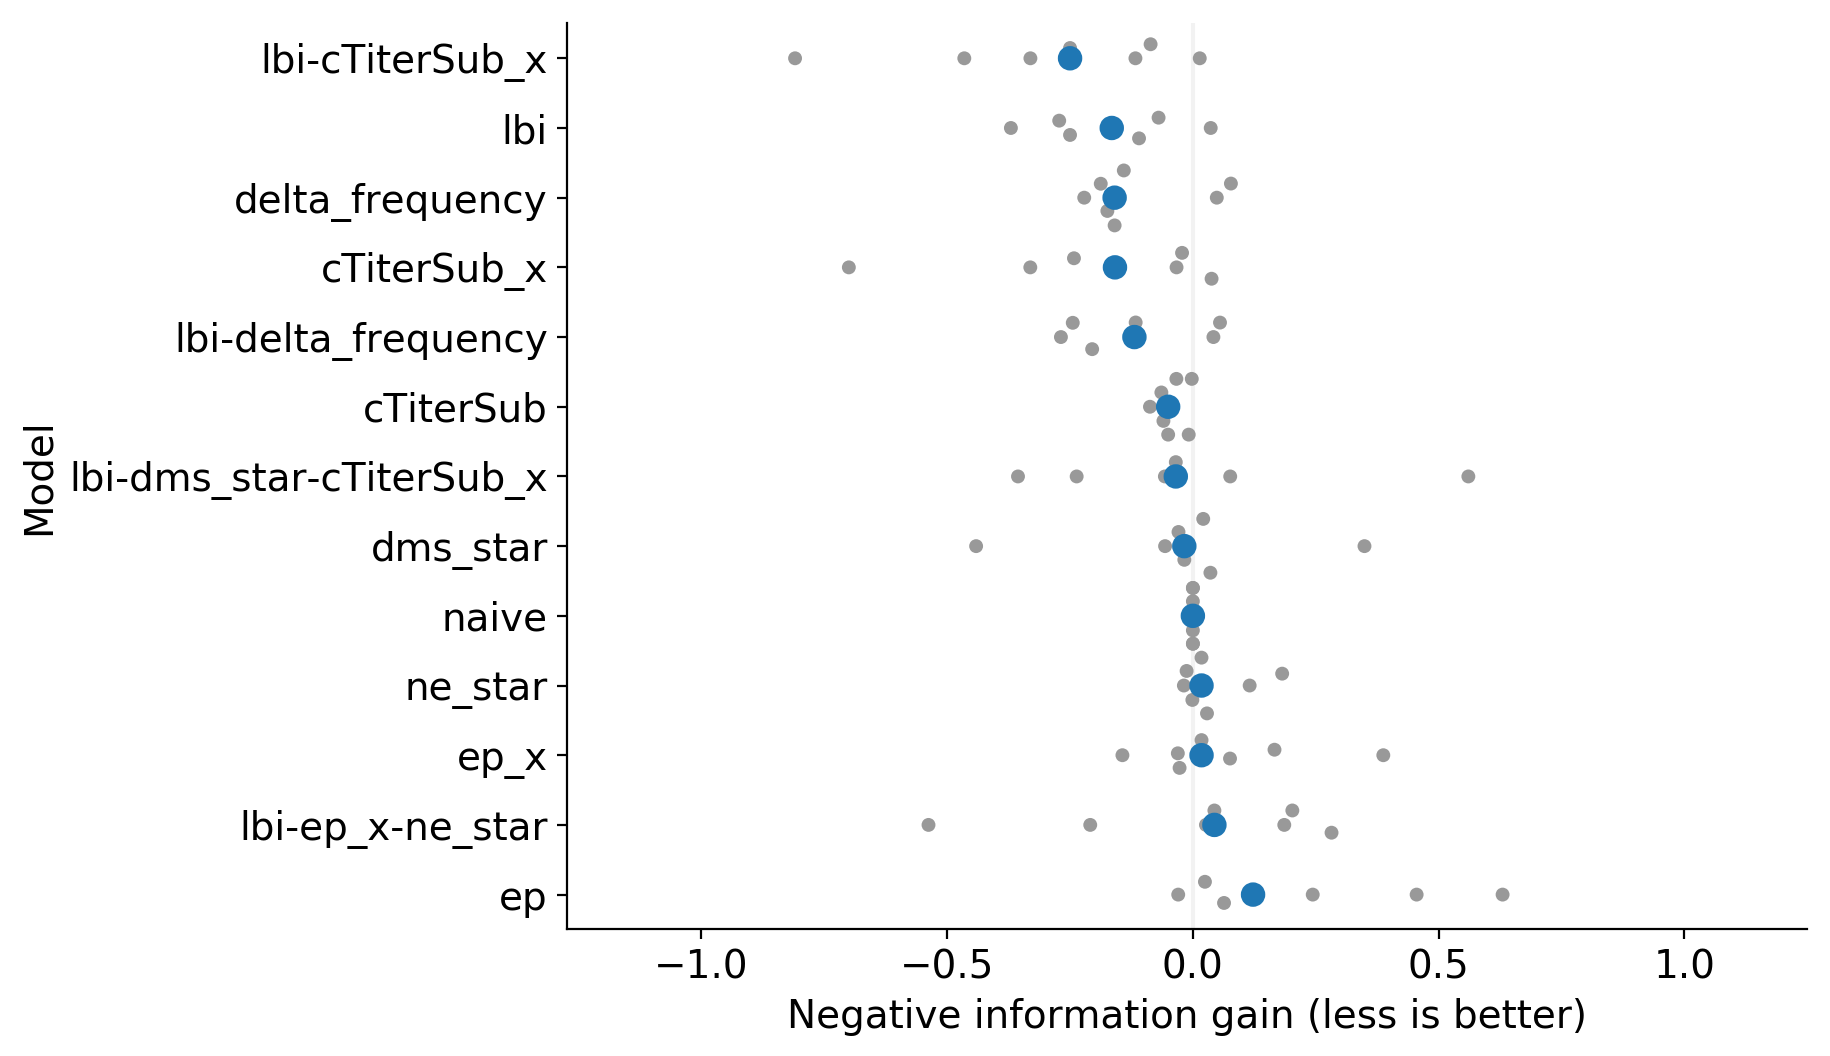

In [410]:
fig, ax = plt.subplots(1, 1, figsize=(8, 6))

sns.swarmplot(
    x="validation_error",
    y="predictors",
    data=errors_by_time_df,
    ax=ax,
    order=negative_information_gain_df.sort_values("median").loc[:, "predictors"],
    color="#999999",
    zorder=-10
)

sns.pointplot(
    x="median",
    y="predictors",
    data=negative_information_gain_df,
    join=False,
    ax=ax,
    order=negative_information_gain_df.sort_values("median").loc[:, "predictors"]
)

ax.set_xlim(right=1.25)
ax.set_xlabel("Negative information gain (less is better)")
ax.set_ylabel("Model")
ax.axvline(x=0.0, color="#cccccc", zorder=-20, alpha=0.25)

In [411]:
predictor_type_order = [
    "naive",
    "ep",
    "cTiterSub",
    "ep_x",
    "cTiterSub_x",
    "ne_star",
    "dms_star",
    "lbi",
    "delta_frequency"
]

In [412]:
predictor_names = [
    "null",
    "epitope mutations",
    "HI phenotypes",
    "epitope cross-immunity",
    "HI cross-immunity",
    "non-epitope mutations",
    "DMS mutation effects",
    "LBI",
    "delta frequency"
]

In [413]:
predictor_name_by_id = dict(zip(predictor_type_order, predictor_names))

In [414]:
predictor_name_by_id

{'naive': 'null',
 'ep': 'epitope mutations',
 'cTiterSub': 'HI phenotypes',
 'ep_x': 'epitope cross-immunity',
 'cTiterSub_x': 'HI cross-immunity',
 'ne_star': 'non-epitope mutations',
 'dms_star': 'DMS mutation effects',
 'lbi': 'LBI',
 'delta_frequency': 'delta frequency'}

In [415]:
errors_by_time_df["predictors_name"] = errors_by_time_df["predictors"].map(predictor_name_by_id)

In [416]:
errors_by_time_df[errors_by_time_df["predictors"] == "naive"]

predictors  validation_error  validation_n validation_timepoint  \
70      naive         -0.000019            24           2011-10-01   
71      naive          0.000019            25           2012-04-01   
72      naive         -0.000029            30           2012-10-01   
73      naive         -0.000006            19           2013-04-01   
74      naive         -0.000005            14           2013-10-01   
75      naive          0.000038            25           2014-04-01   
76      naive         -0.000061            29           2014-10-01   

   predictors_name  
70            null  
71            null  
72            null  
73            null  
74            null  
75            null  
76            null

In [ ]:
fig, ax = plt.subplots(1, 1, figsize=(8, 4))

ax = sns.swarmplot(
    x="validation_error",
    y="predictors",
    data=errors_by_time_df,
    ax=ax,
    color="#999999",
    order=composite_predictors_order
)

ax.plot(
    median_errors,
    composite_predictors_order,
    marker="|",
    markersize=20,
    linestyle=""
)

ax.set_xlim(-1.25, 1.25)
ax.set_yticklabels(composite_predictor_names)

#labels = ax.get_yticklabels()
#output = plt.setp(labels, rotation=30)

ax.set_xlabel("Negative information gain (less is better)")
ax.set_ylabel("Model")
ax.axvline(x=0.0, color="#cccccc", zorder=-20, alpha=0.25)

plt.tight_layout()

In [532]:
individual_median_errors = []
for predictor in predictor_type_order:
    individual_median_errors.append(
        negative_information_gain_df.loc[negative_information_gain_df["predictors"] == predictor, "median"].values[0]
    )

In [533]:
individual_median_errors

[-6.000246000773425e-06,
 0.12242910318725624,
 -0.050301067159538956,
 0.01760191515309369,
 -0.15853530185410444,
 0.017552546338784145,
 -0.017429740696382267,
 -0.16506855237729673,
 -0.15924074619497083]

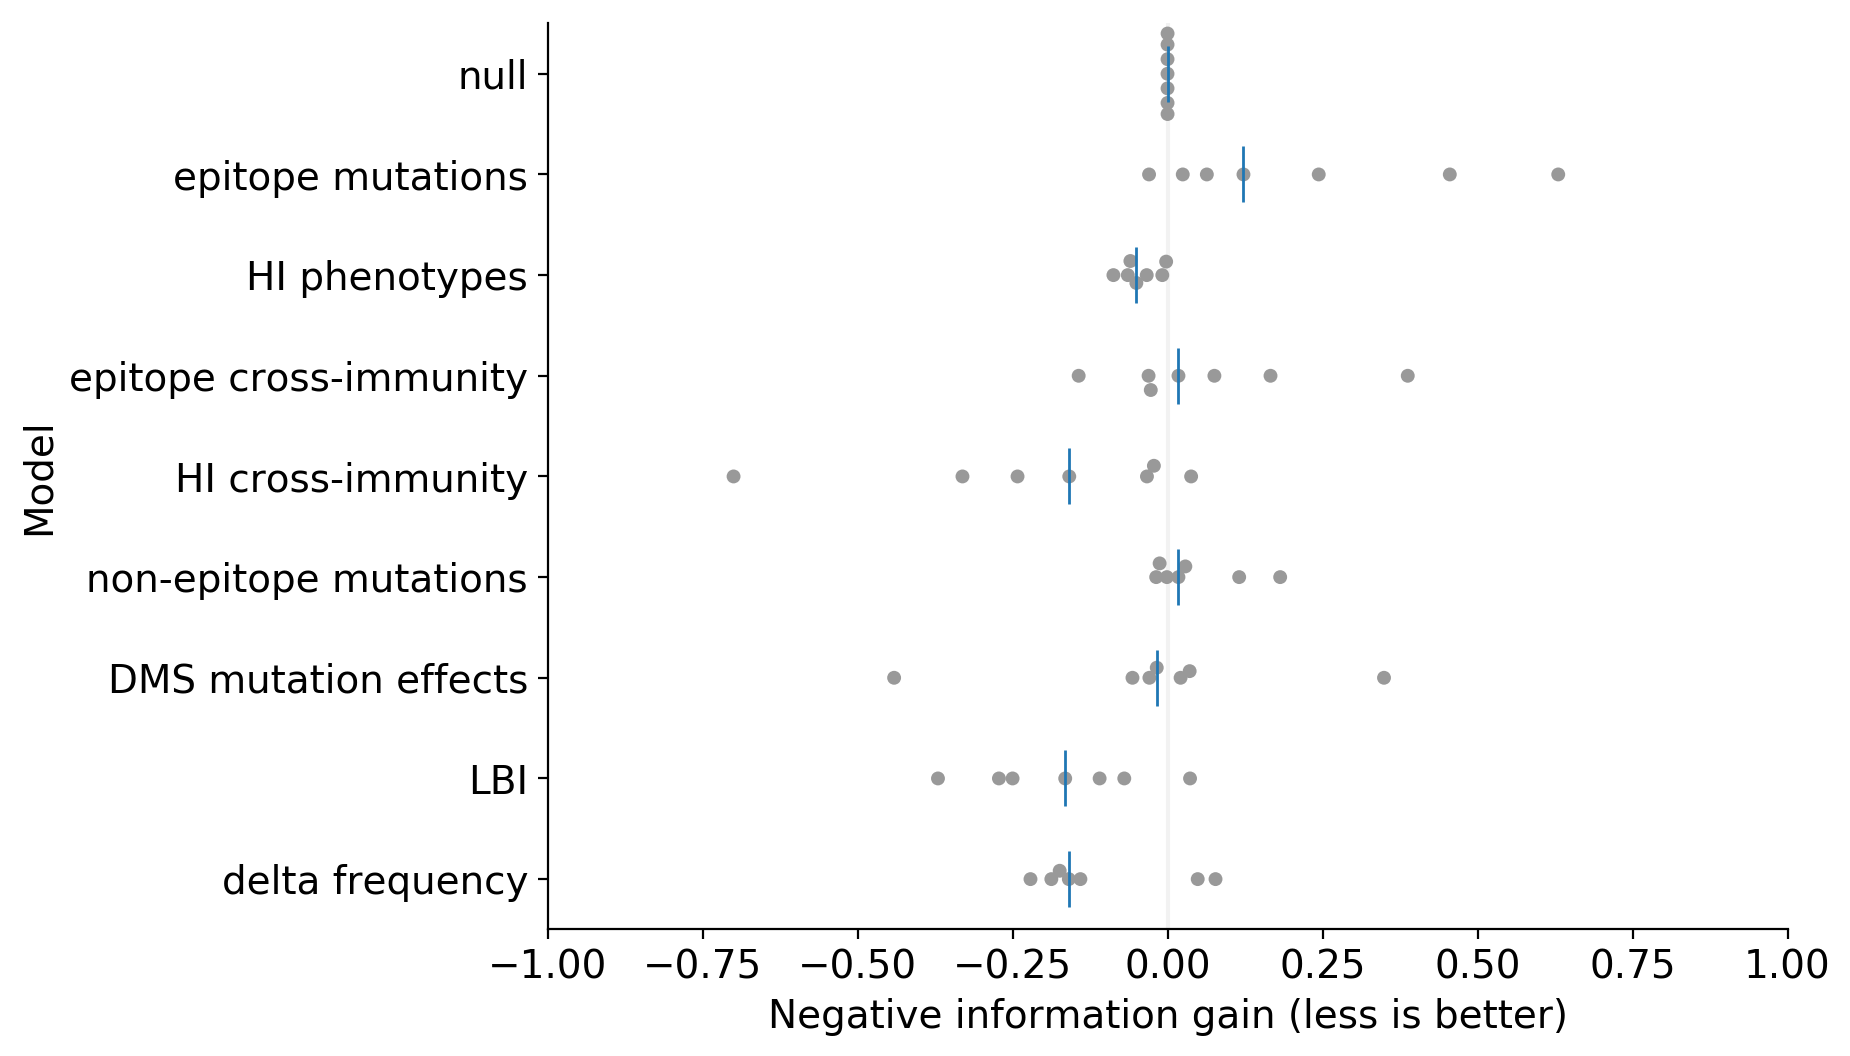

In [537]:
fig, ax = plt.subplots(1, 1, figsize=(8, 6))

ax = sns.swarmplot(
    x="validation_error",
    y="predictors",
    data=errors_by_time_df,
    ax=ax,
    order=predictor_type_order,
    color="#999999",
    zorder=-10
)

ax.plot(
    individual_median_errors,
    predictor_type_order,
    marker="|",
    markersize=20,
    linestyle=""
)

ax.set_xlim(-1, 1)
ax.set_yticklabels(predictor_names)

ax.set_xlabel("Negative information gain (less is better)")
ax.set_ylabel("Model")
ax.axvline(x=0.0, color="#cccccc", zorder=-20, alpha=0.25)

In [445]:
errors_by_time_df[errors_by_time_df["predictors"].str.contains("-")]["predictors"].unique()

array(['lbi-ep_x-ne_star', 'lbi-cTiterSub_x', 'lbi-delta_frequency',
       'lbi-dms_star-cTiterSub_x'], dtype=object)

In [452]:
composite_predictors_order = [
    "lbi",
    "delta_frequency",
    "cTiterSub_x",
    "lbi-delta_frequency",
    "lbi-cTiterSub_x",
    "lbi-dms_star-cTiterSub_x",
    "lbi-ep_x-ne_star"
]

In [500]:
composite_predictor_names = [
    "LBI",
    "delta frequency",
    "HI cross.",
    "LBI, delta frequency",
    "LBI, HI cross.",
    "LBI, DMS, HI cross.",
    "Luksza and Lassig"
]

In [501]:
median_errors = []
for predictor in composite_predictors_order:
    median_errors.append(negative_information_gain_df.loc[negative_information_gain_df["predictors"] == predictor, "median"].values[0])

In [502]:
median_errors

[-0.16506855237729673,
 -0.15924074619497083,
 -0.15853530185410444,
 -0.11898042476648953,
 -0.24991481682649808,
 -0.0347586939378452,
 0.04376848640274728]

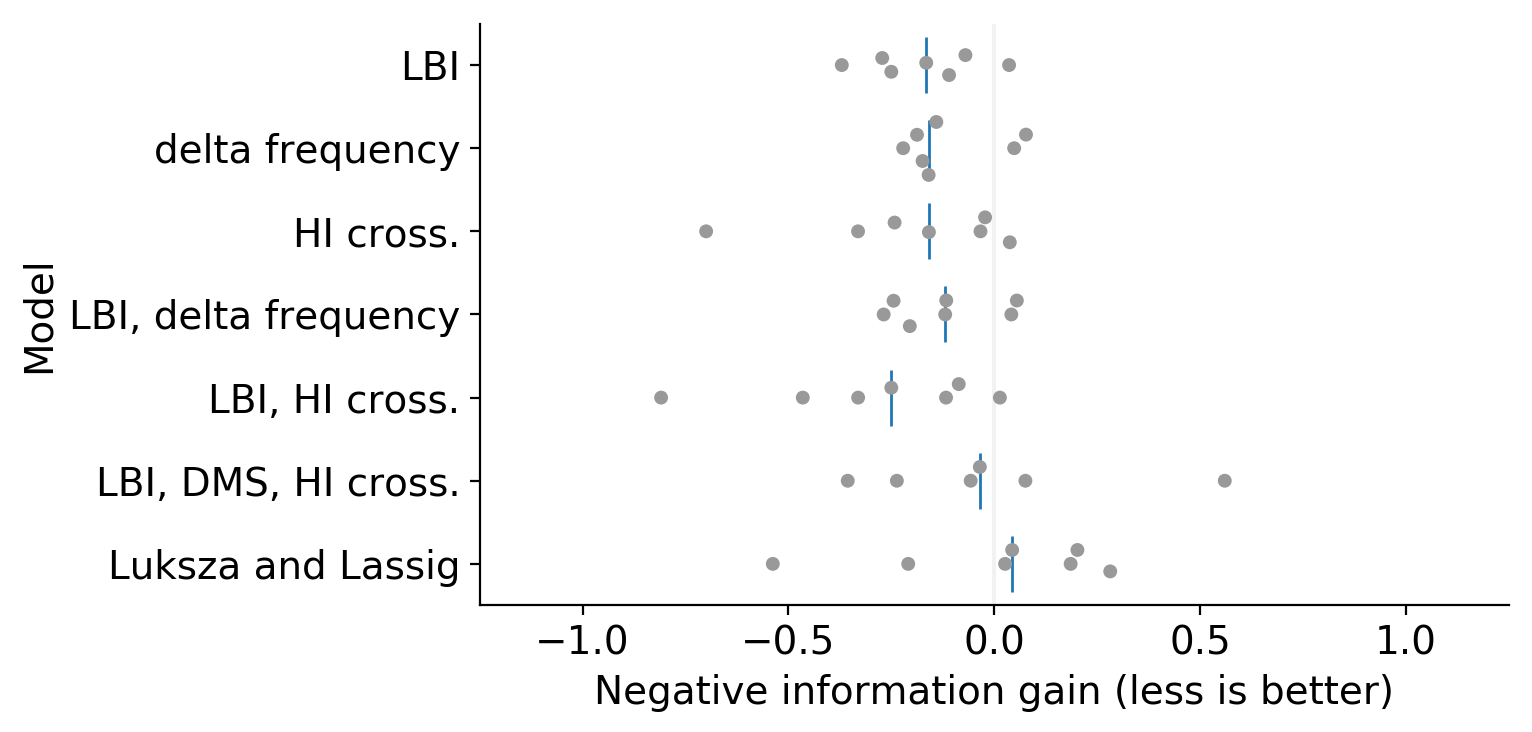

In [506]:
fig, ax = plt.subplots(1, 1, figsize=(8, 4))

ax = sns.swarmplot(
    x="validation_error",
    y="predictors",
    data=errors_by_time_df,
    ax=ax,
    color="#999999",
    order=composite_predictors_order
)

ax.plot(
    median_errors,
    composite_predictors_order,
    marker="|",
    markersize=20,
    linestyle=""
)

ax.set_xlim(-1.25, 1.25)
ax.set_yticklabels(composite_predictor_names)

#labels = ax.get_yticklabels()
#output = plt.setp(labels, rotation=30)

ax.set_xlabel("Negative information gain (less is better)")
ax.set_ylabel("Model")
ax.axvline(x=0.0, color="#cccccc", zorder=-20, alpha=0.25)

plt.tight_layout()

In [504]:
facet_time_plot??

Signature:
facet_time_plot(
    data,
    value,
    value_label,
    timepoint_column='timepoint',
    predictors_column='predictors',
    hue=None,
    height=4,
    aspect=1,
    col_order=None,
    col_wrap=4,
)
Docstring: <no docstring>
Source:   
def facet_time_plot(data, value, value_label, timepoint_column="timepoint", predictors_column="predictors", hue=None,
                    height=4, aspect=1, col_order=None, col_wrap=4):
    g = sns.FacetGrid(data, col=predictors_column, col_order=col_order, col_wrap=col_wrap, hue=hue, height=height, aspect=aspect)
    g.map_dataframe(sns.lineplot, x=timepoint_column, y=value, estimator="mean", ci="sd", markers=True, dashes=False,
                   style=predictors_column, markersize=15)
    g.set_axis_labels("Date", value_label)

    for ax in g.axes.flatten():
        ax.axhline(y=0, color="#cccccc", zorder=-10)

        #start, end = [int(value) for value in ax.get_xlim()]
        #end = end + 1
        #stepsize = 2.0
        #ax.xa

In [419]:
errors_by_time_df.loc[pd.isnull(errors_by_time_df["predictors_name"]), "predictors_name"] = errors_by_time_df.loc[
    pd.isnull(errors_by_time_df["predictors_name"]), "predictors"
]

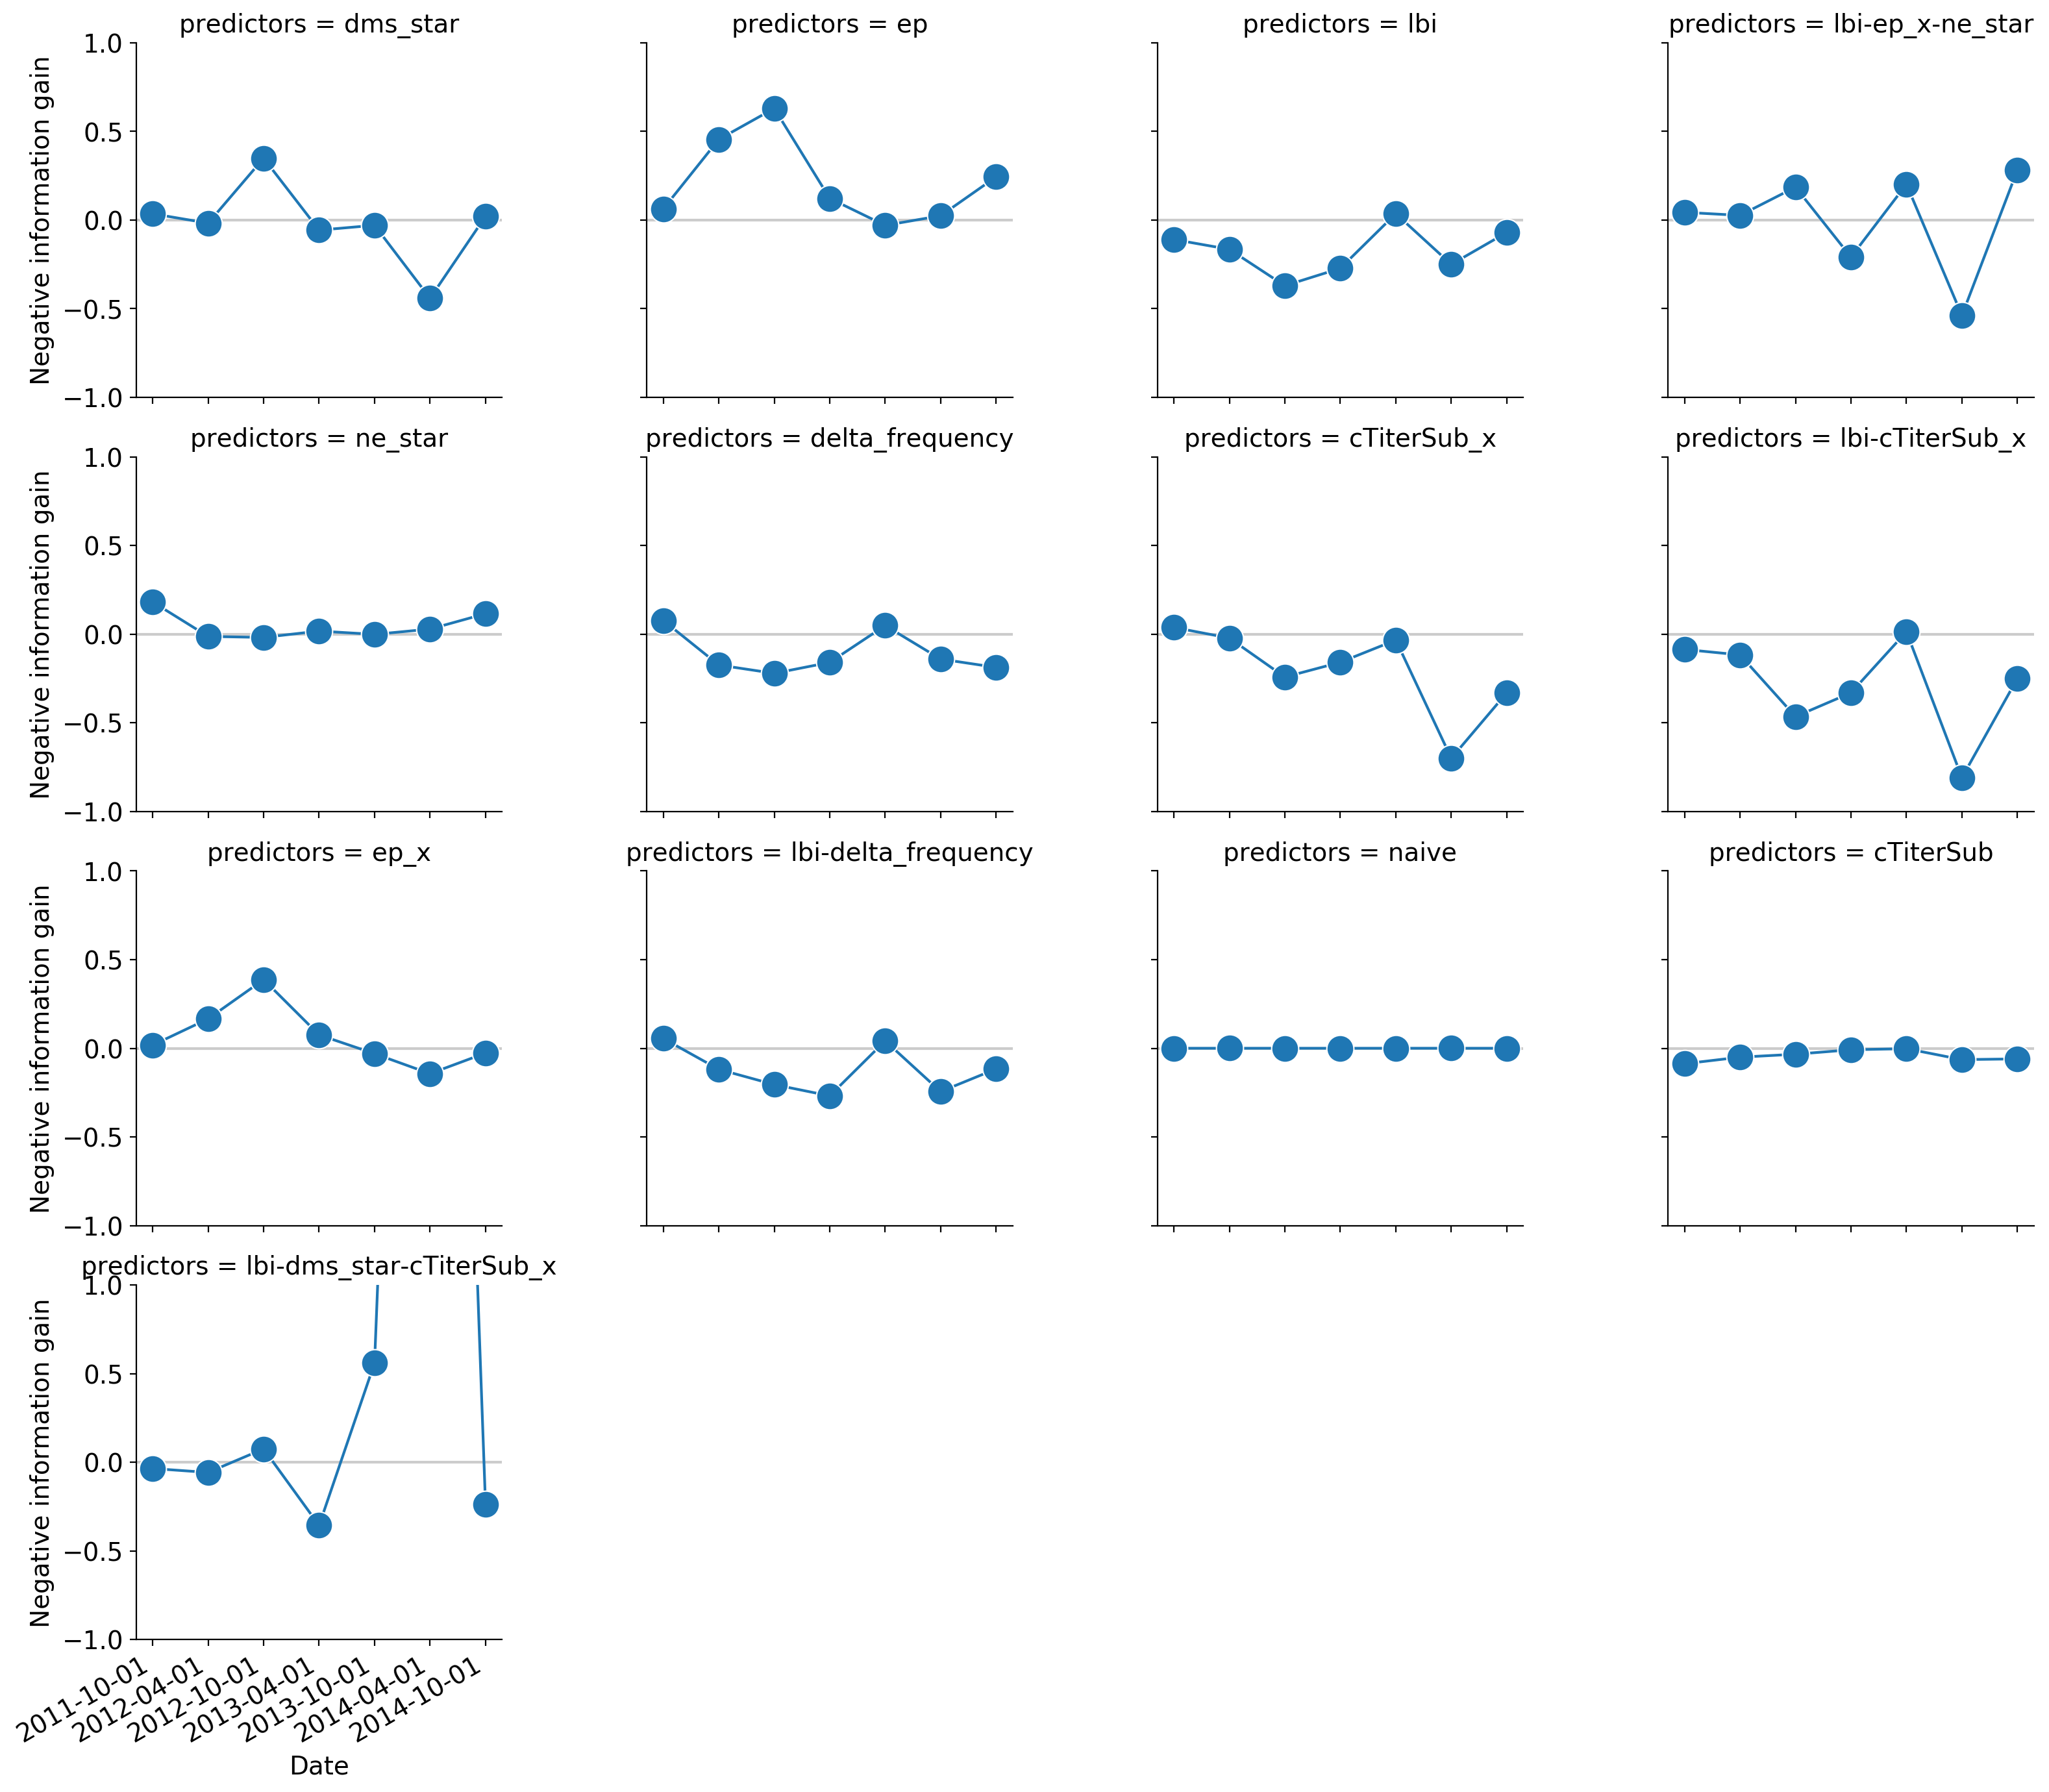

In [420]:
g = facet_time_plot(errors_by_time_df, "validation_error", "Negative information gain", timepoint_column="validation_timepoint")
for ax in g.axes.flatten():
    ax.set_ylim(-1, 1)

In [421]:
min_error = errors_by_time_df["validation_error"].min()

In [422]:
max_error = errors_by_time_df["validation_error"].max()

In [423]:
error_buffer = errors_by_time_df["validation_error"].std() / 3

In [431]:
min_error = errors_by_time_df["validation_error"].std() * -1.5

In [432]:
max_error = errors_by_time_df["validation_error"].std() * 1.5

In [433]:
error_buffer = 0.0

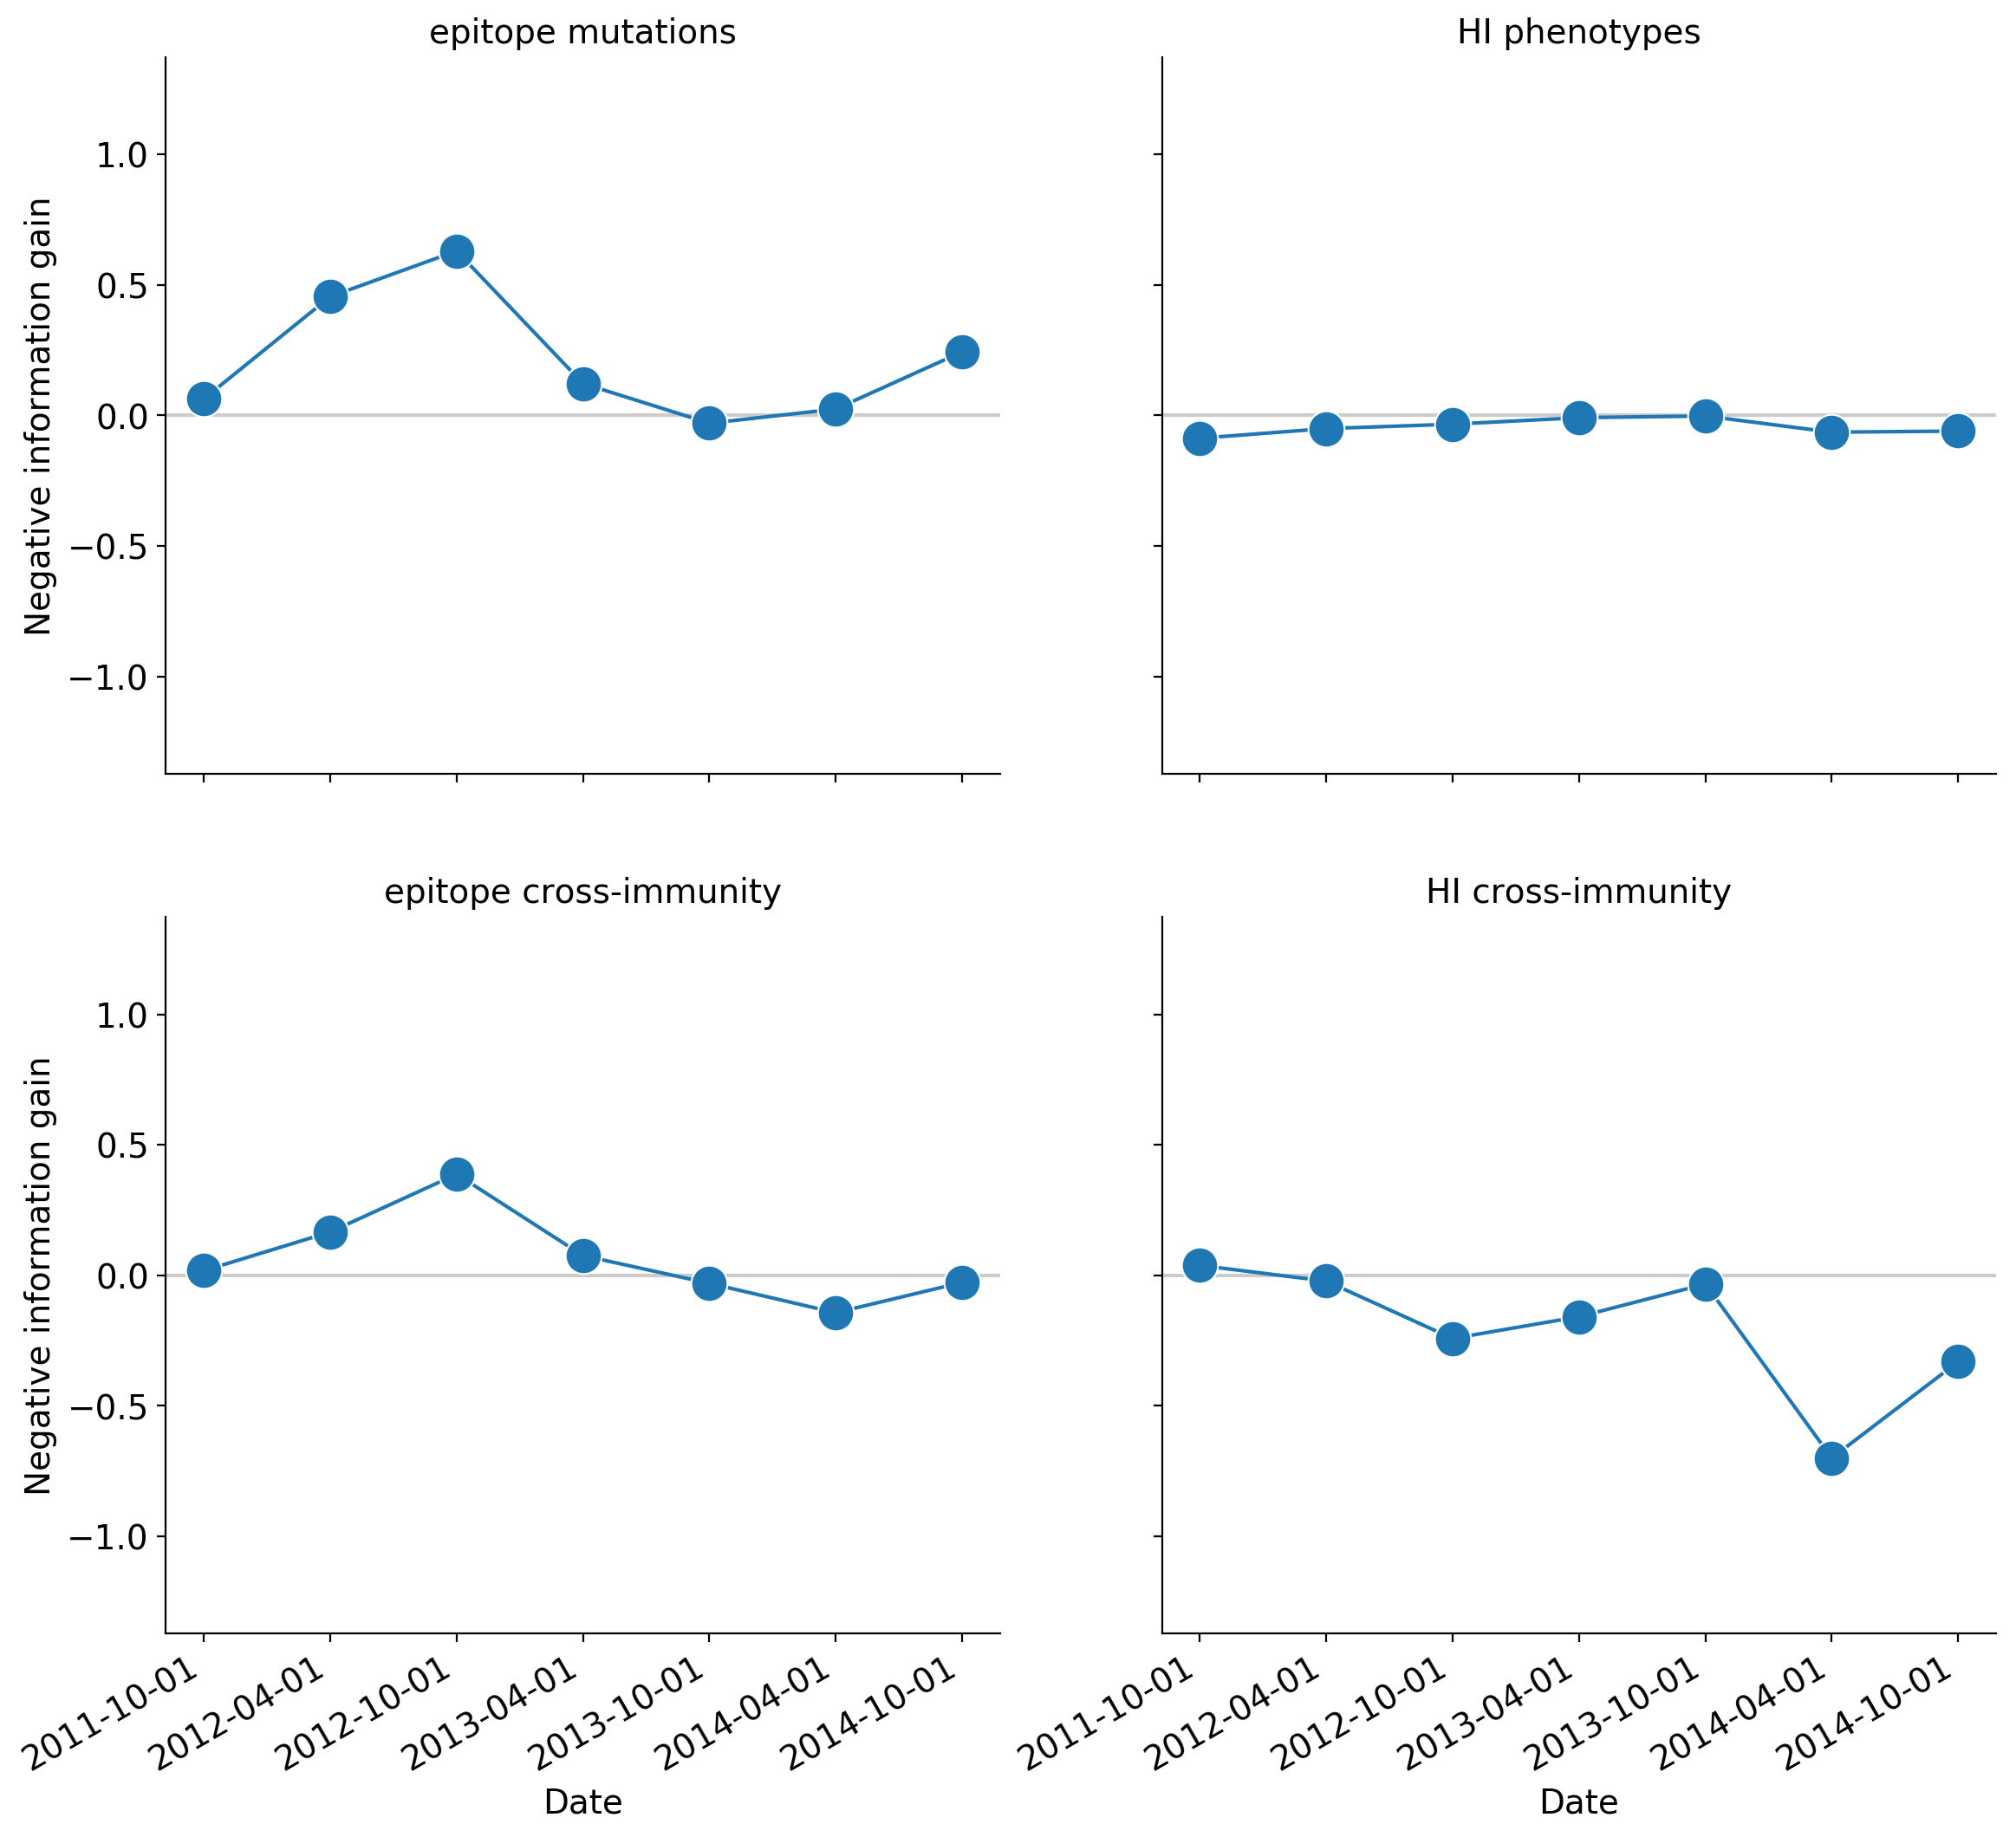

In [434]:
antigenic_predictors = predictor_type_order[1:5]
g = facet_time_plot(
    errors_by_time_df[errors_by_time_df["predictors"].isin(antigenic_predictors)],
    "validation_error",
    "Negative information gain",
    timepoint_column="validation_timepoint",
    predictors_column="predictors_name",
    col_wrap=2,
    height=6,
    aspect=1.,
    col_order=[predictor_name_by_id[predictor] for predictor in antigenic_predictors]
)
g.set_titles("{col_name}")
g.fig.subplots_adjust(hspace=0.2)

for ax in g.axes.flatten():
    ax.set_ylim(min_error - error_buffer, max_error + error_buffer)

In [435]:
predictor_type_order

['naive',
 'ep',
 'cTiterSub',
 'ep_x',
 'cTiterSub_x',
 'ne_star',
 'dms_star',
 'lbi',
 'delta_frequency']

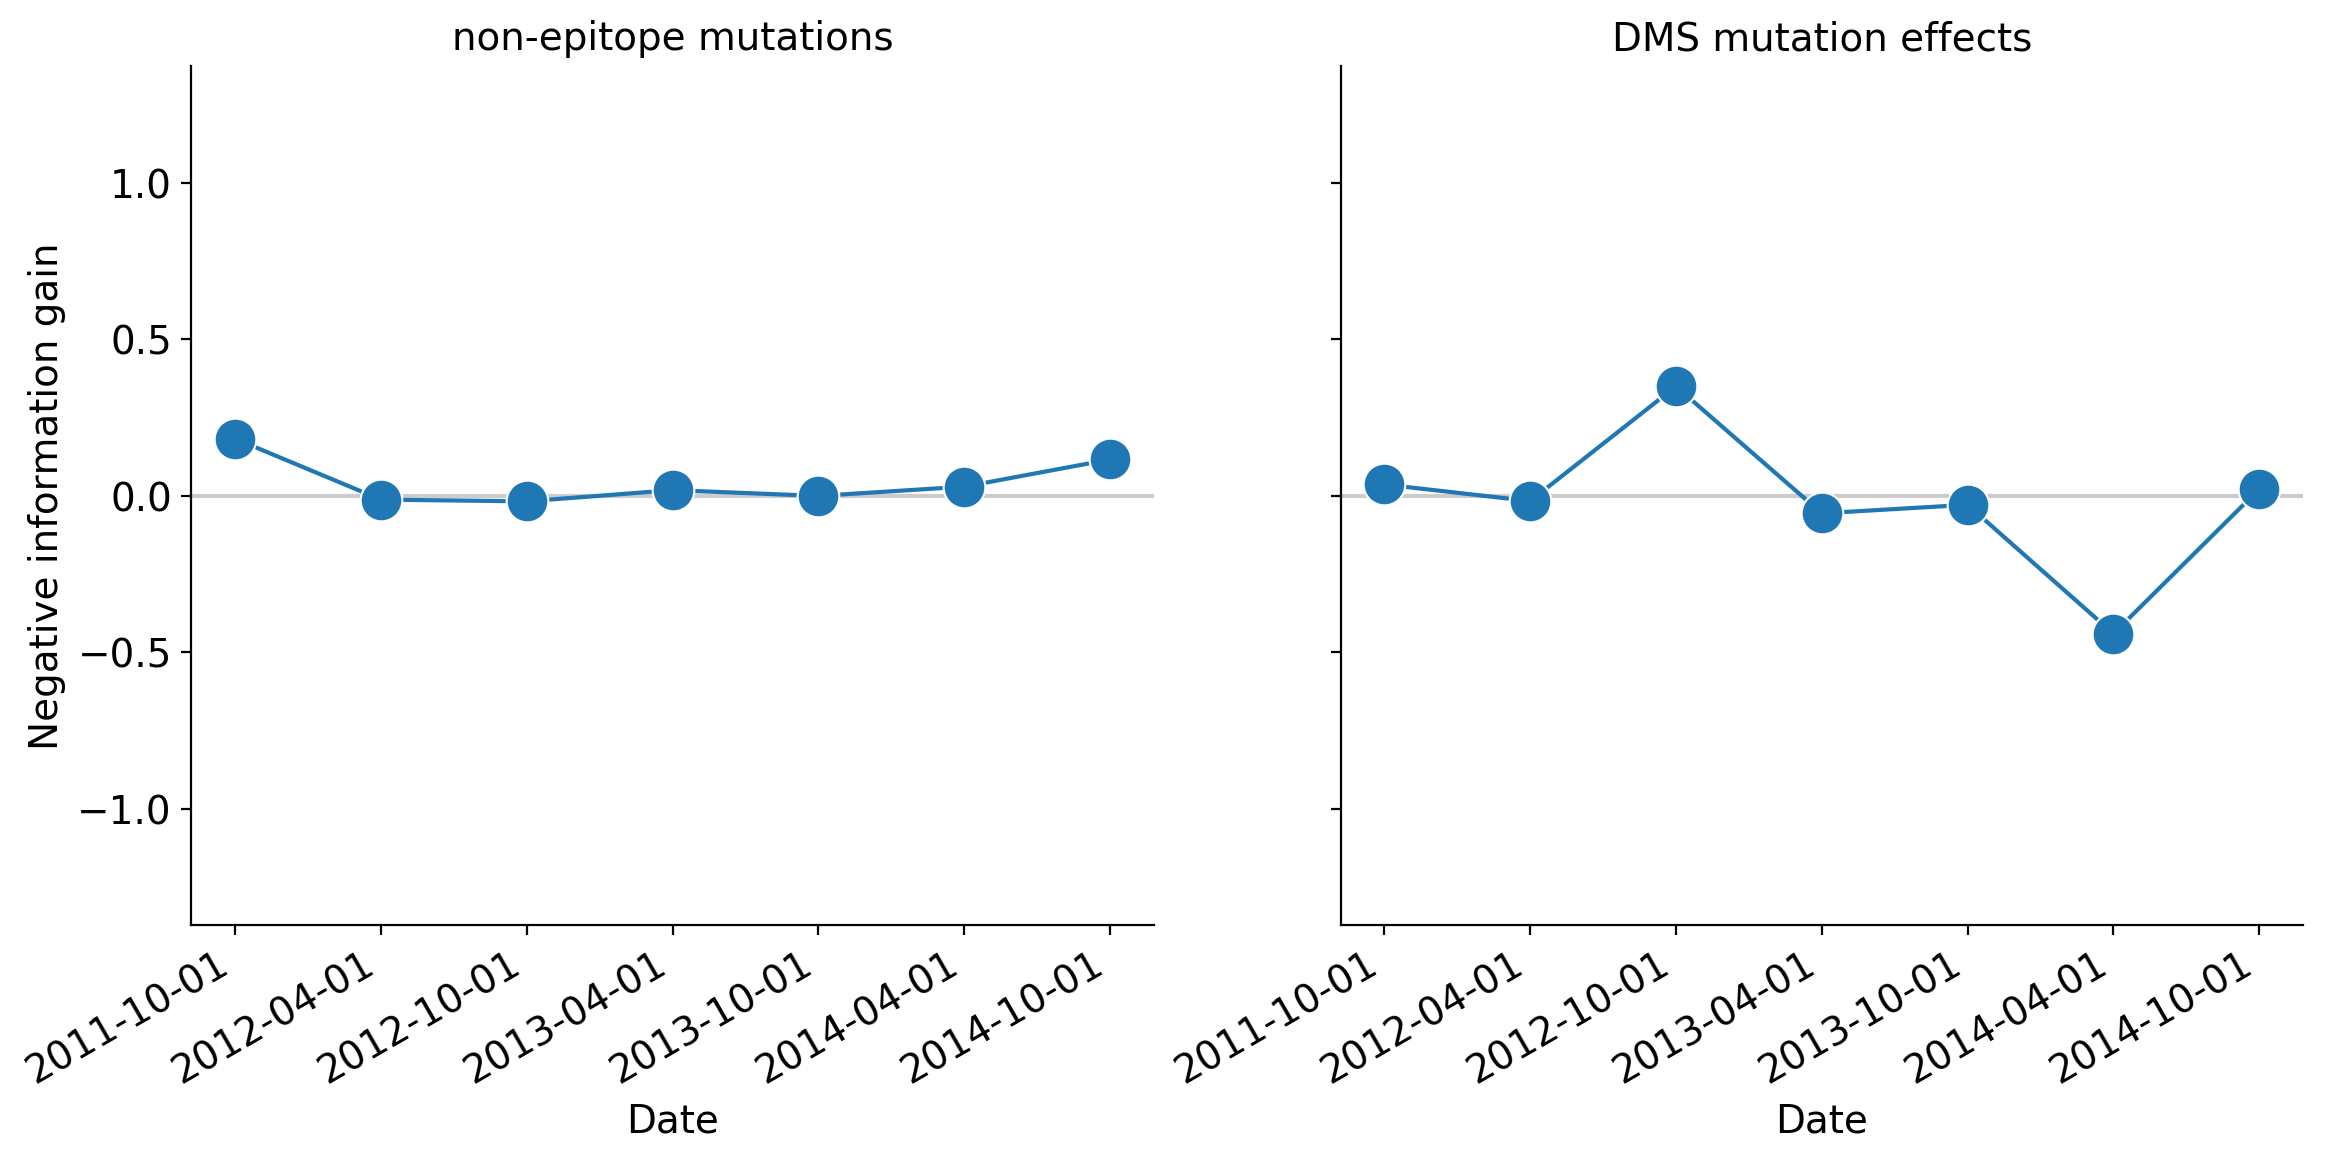

In [436]:
functional_predictors = predictor_type_order[5:7]
g = facet_time_plot(
    errors_by_time_df[errors_by_time_df["predictors"].isin(functional_predictors)],
    "validation_error",
    "Negative information gain",
    timepoint_column="validation_timepoint",
    predictors_column="predictors_name",
    col_wrap=2,
    height=6,
    aspect=1.,
    col_order=[predictor_name_by_id[predictor] for predictor in functional_predictors]
)
g.set_titles("{col_name}")
g.fig.subplots_adjust(hspace=0.2)

for ax in g.axes.flatten():
    ax.set_ylim(min_error - error_buffer, max_error + error_buffer)

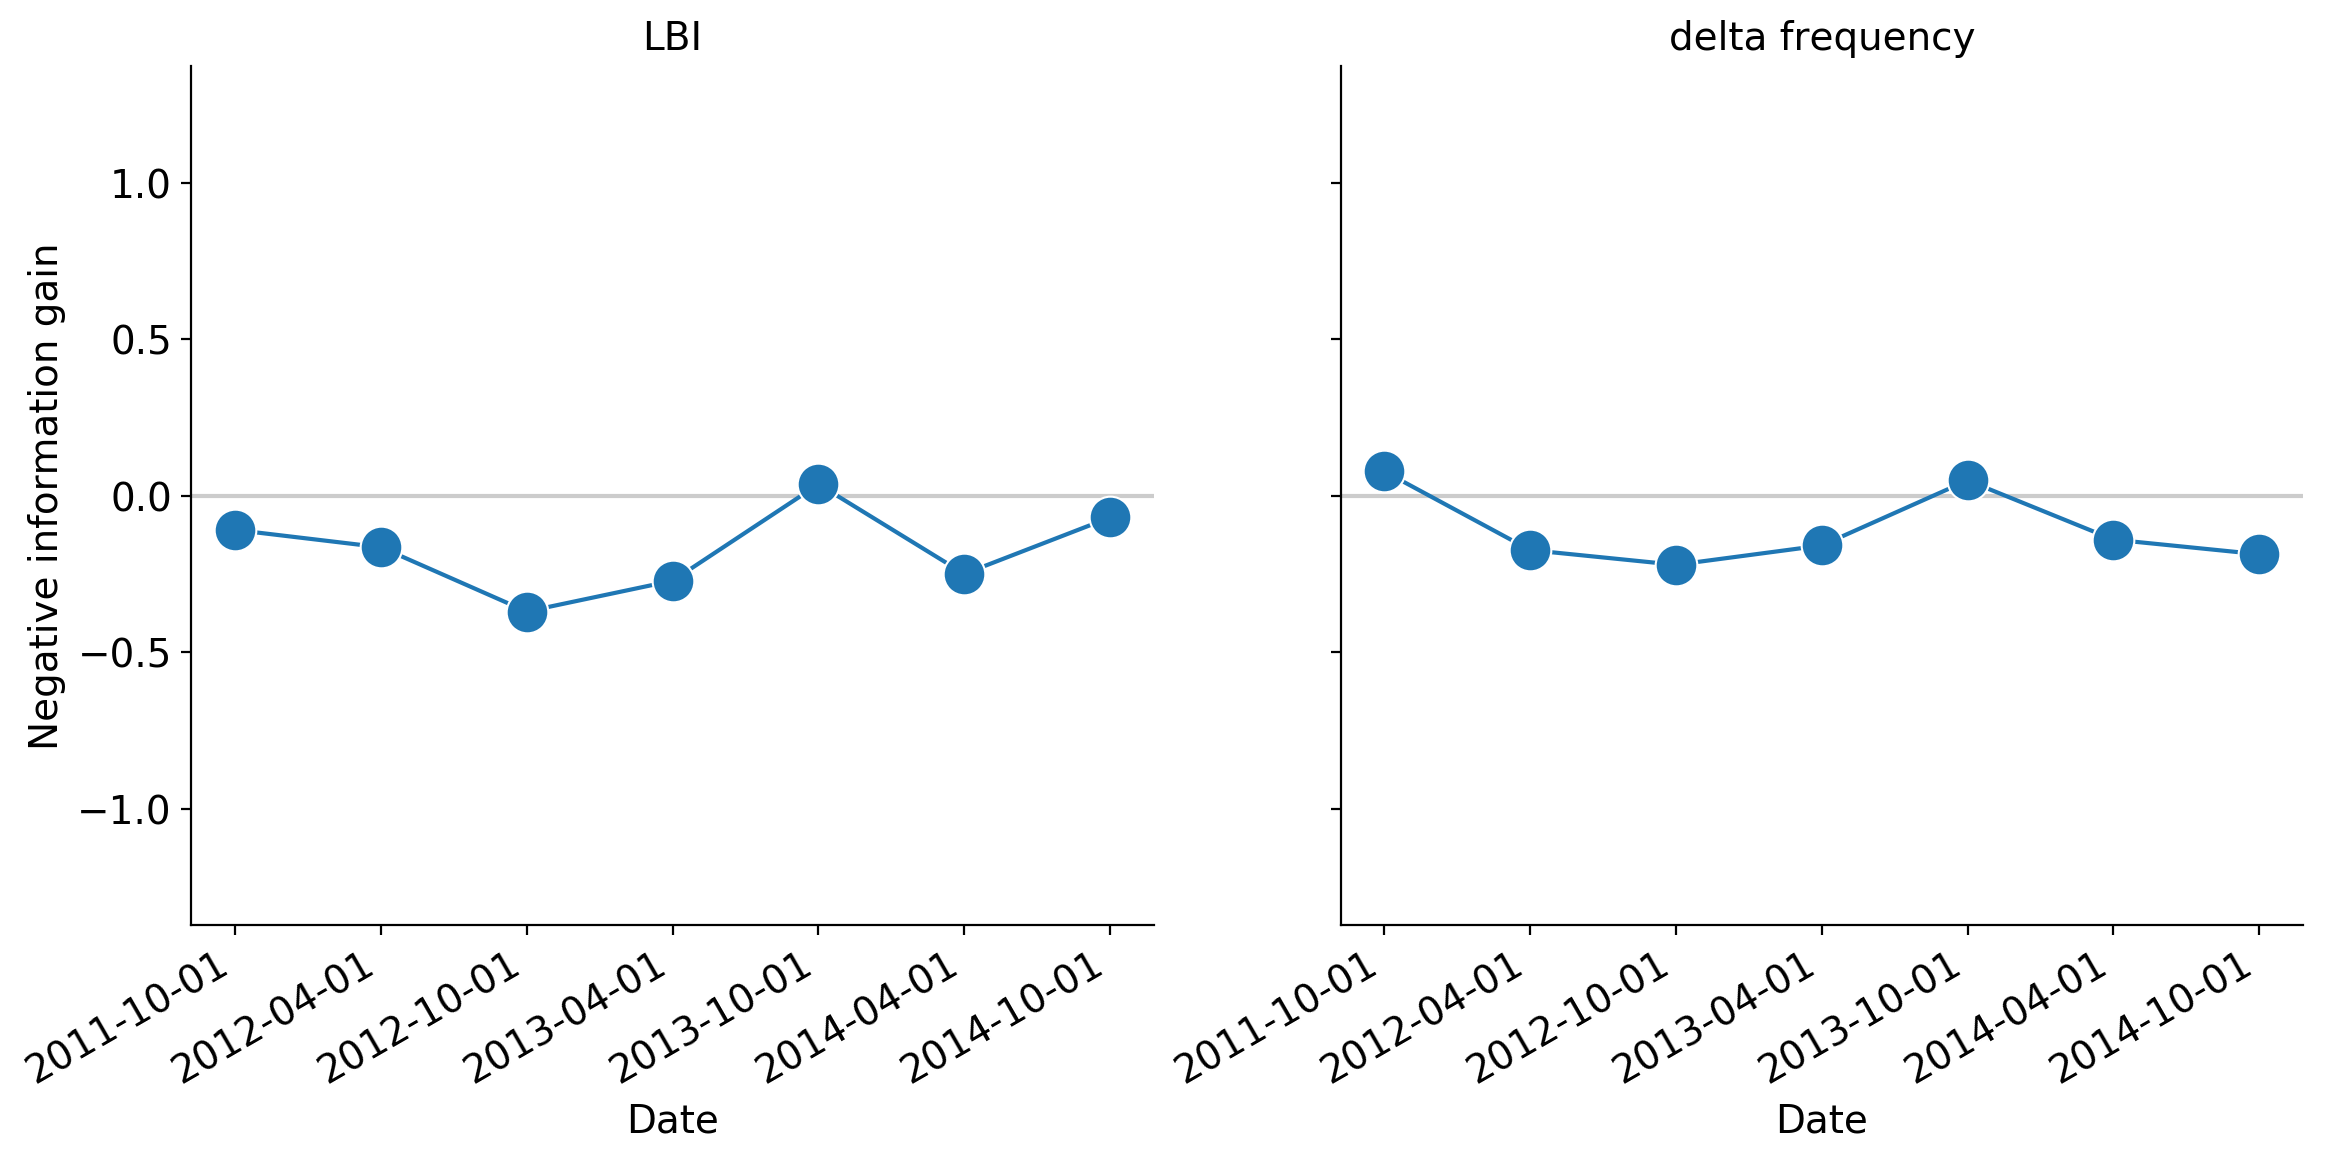

In [437]:
growth_predictors = predictor_type_order[7:]
g = facet_time_plot(
    errors_by_time_df[errors_by_time_df["predictors"].isin(growth_predictors)],
    "validation_error",
    "Negative information gain",
    timepoint_column="validation_timepoint",
    predictors_column="predictors_name",
    col_wrap=2,
    height=6,
    aspect=1.,
    col_order=[predictor_name_by_id[predictor] for predictor in growth_predictors]
)
g.set_titles("{col_name}")
g.fig.subplots_adjust(hspace=0.2)

for ax in g.axes.flatten():
    ax.set_ylim(min_error - error_buffer, max_error + error_buffer)

In [438]:
errors_by_time_df["predictors"].unique()

array(['dms_star', 'ep', 'lbi', 'lbi-ep_x-ne_star', 'ne_star',
       'delta_frequency', 'cTiterSub_x', 'lbi-cTiterSub_x', 'ep_x',
       'lbi-delta_frequency', 'naive', 'cTiterSub',
       'lbi-dms_star-cTiterSub_x'], dtype=object)

In [439]:
errors_by_time_df[errors_by_time_df["predictors"] == "naive"]

predictors  validation_error  validation_n validation_timepoint  \
70      naive         -0.000019            24           2011-10-01   
71      naive          0.000019            25           2012-04-01   
72      naive         -0.000029            30           2012-10-01   
73      naive         -0.000006            19           2013-04-01   
74      naive         -0.000005            14           2013-10-01   
75      naive          0.000038            25           2014-04-01   
76      naive         -0.000061            29           2014-10-01   

   predictors_name  
70            null  
71            null  
72            null  
73            null  
74            null  
75            null  
76            null

(-0.7, 0.7)

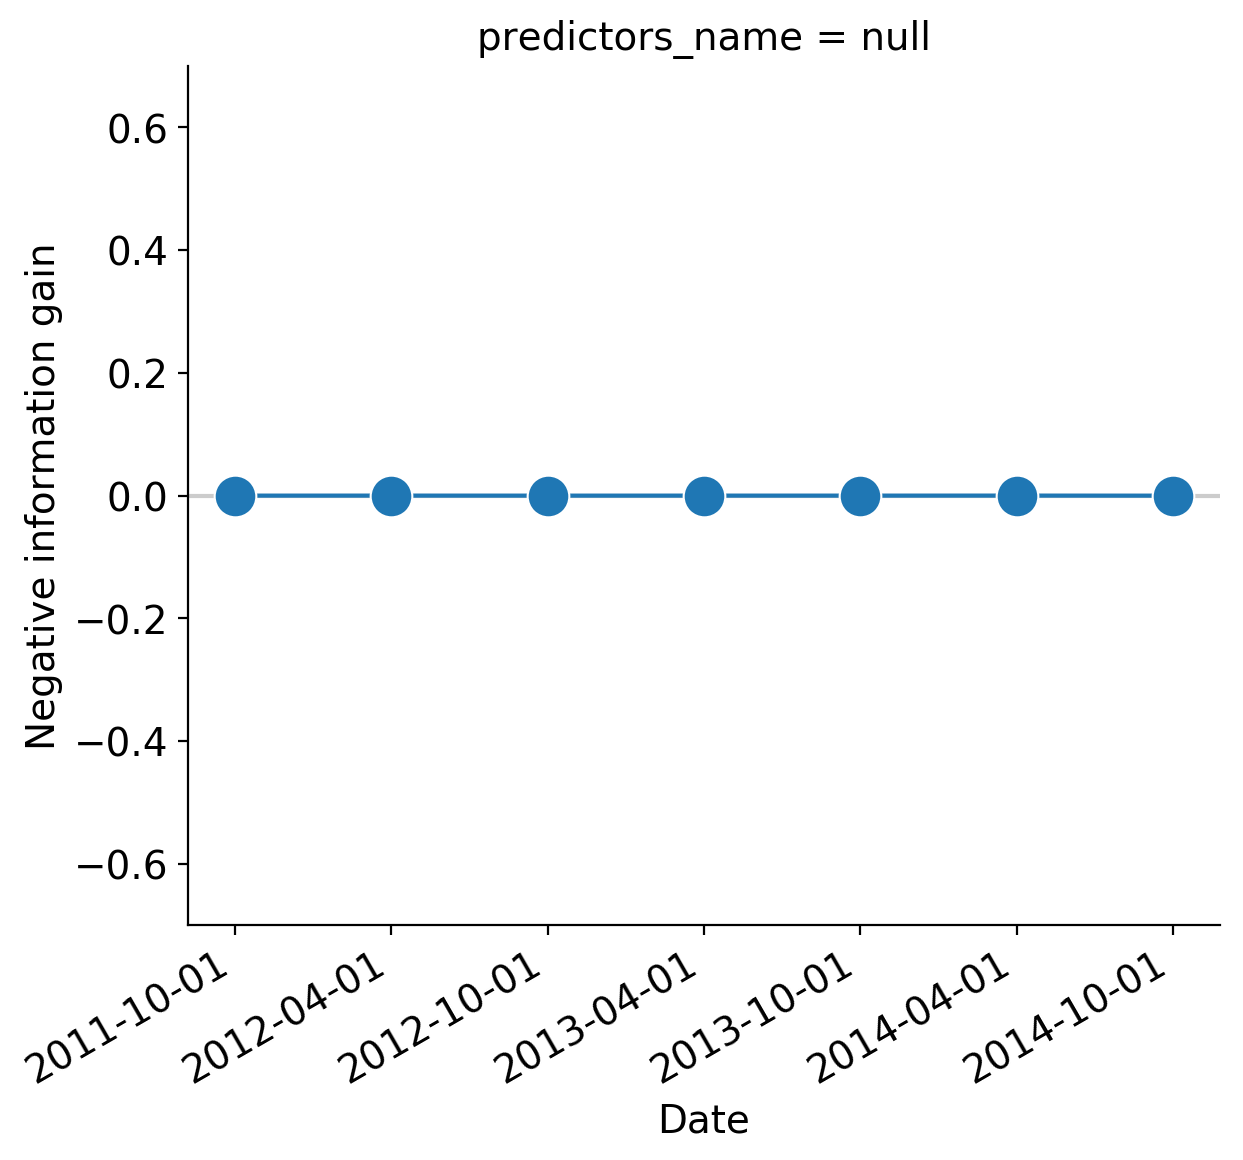

In [440]:
g = facet_time_plot(
    errors_by_time_df[errors_by_time_df["predictors"] == "naive"],
    "validation_error",
    "Negative information gain",
    timepoint_column="validation_timepoint",
    predictors_column="predictors_name",
    height=6,
    aspect=1
)
#g.set_titles("{col_name}")
#g.fig.subplots_adjust(hspace=0.2)
g.axes[0].set_ylim(-0.7, 0.7)

### Mean absolute error (MAE)

In [637]:
mae_df = frequency_df.groupby("predictors").apply(
    lambda group_df: mean_absolute_error(group_df["frequency"], group_df["frequency_hat"])
).reset_index().rename(columns={0: "mae"})

In [638]:
mae_df.sort_values("mae")

predictors       mae
6              lbi  0.046977
1      cTiterSub_x  0.047054
2  delta_frequency  0.048486
0        cTiterSub  0.050388
3         dms_star  0.050817
7            naive  0.051100
8          ne_star  0.051811
5             ep_x  0.052049
4               ep  0.054121

In [639]:
mae_by_timepoint_df = frequency_df.groupby(["predictors", "validation_timepoint"]).apply(
    lambda group_df: mean_absolute_error(group_df["frequency"], group_df["frequency_hat"])
).reset_index().rename(columns={0: "mae"})

In [640]:
mae_by_timepoint_df.head()

predictors validation_timepoint       mae
0  cTiterSub           2011-10-01  0.037384
1  cTiterSub           2012-04-01  0.050808
2  cTiterSub           2012-10-01  0.053378
3  cTiterSub           2013-04-01  0.048865
4  cTiterSub           2013-10-01  0.059428

In [641]:
naive_mae = mae_by_timepoint_df[mae_by_timepoint_df["predictors"] == "naive"]["mae"].values
for predictor in mae_by_timepoint_df["predictors"].drop_duplicates().values:
    mae_by_timepoint_df.loc[mae_by_timepoint_df["predictors"] == predictor, "adjusted_mae"] =  mae_by_timepoint_df.loc[mae_by_timepoint_df["predictors"] == predictor, "mae"] - naive_mae

In [642]:
mae_df["adjusted_mae"] = mae_df["mae"] - mae_df[mae_df["predictors"] == "naive"]["mae"].iloc[0]

In [643]:
mae_df.head()

predictors       mae  adjusted_mae
0        cTiterSub  0.050388     -0.000712
1      cTiterSub_x  0.047054     -0.004046
2  delta_frequency  0.048486     -0.002613
3         dms_star  0.050817     -0.000282
4               ep  0.054121      0.003022

In [644]:
mae_df.sort_values("mae")["predictors"].values

array(['lbi', 'cTiterSub_x', 'delta_frequency', 'cTiterSub', 'dms_star',
       'naive', 'ne_star', 'ep_x', 'ep'], dtype=object)

In [645]:
mae_df.loc[mae_df["predictors"] == "naive", "mae"].values[0]

0.05109963675145031

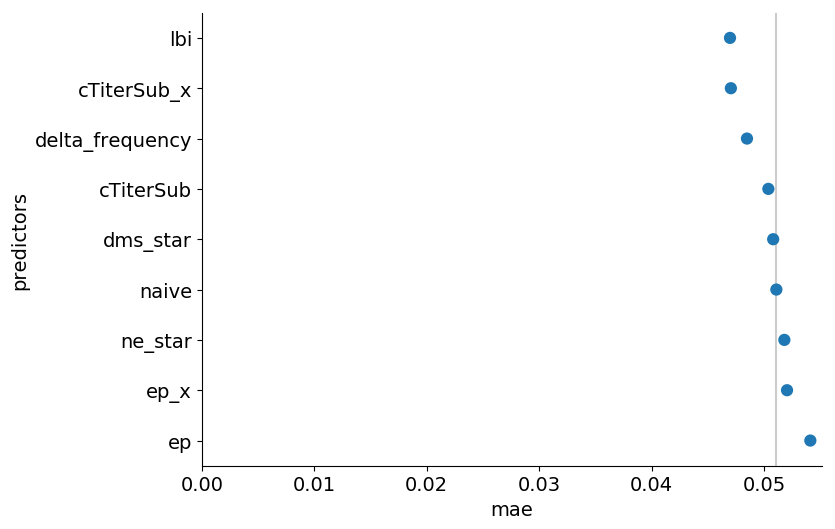

In [646]:
fig, ax = plt.subplots(1, 1, figsize=(8, 6))
sns.pointplot(
    x="mae",
    y="predictors",
    data=mae_df,
    join=False,
    order=mae_df.sort_values("mae")["predictors"].values,
    ax=ax
)
ax.set_xlim(left=0)
ax.axvline(x=mae_df.loc[mae_df["predictors"] == "naive", "mae"].values[0], color="#cccccc", zorder=-10)

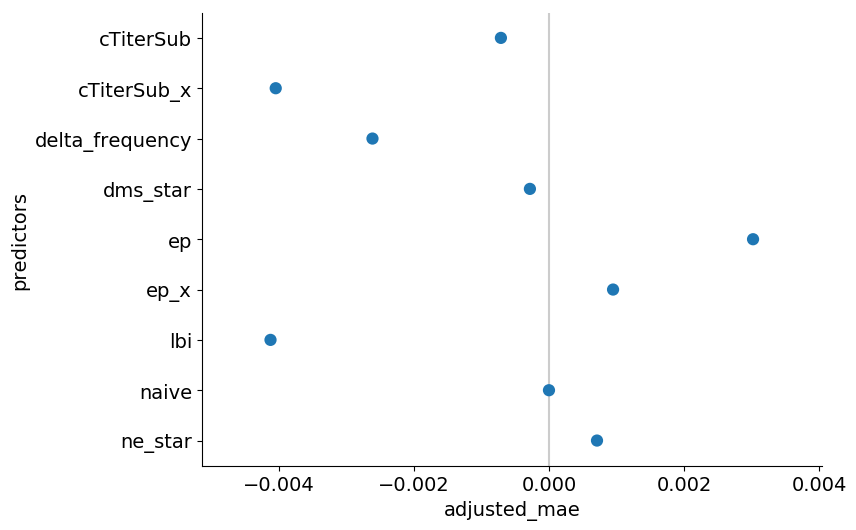

In [647]:
fig, ax = plt.subplots(1, 1, figsize=(8, 6))
sns.pointplot(
    x="adjusted_mae",
    y="predictors",
    data=mae_df,
    join=False,
#    order=predictor_names_order,
    ax=ax
)
ax.axvline(x=0.0, color="#cccccc", zorder=-10)
#ax.set_xlim(left=0)

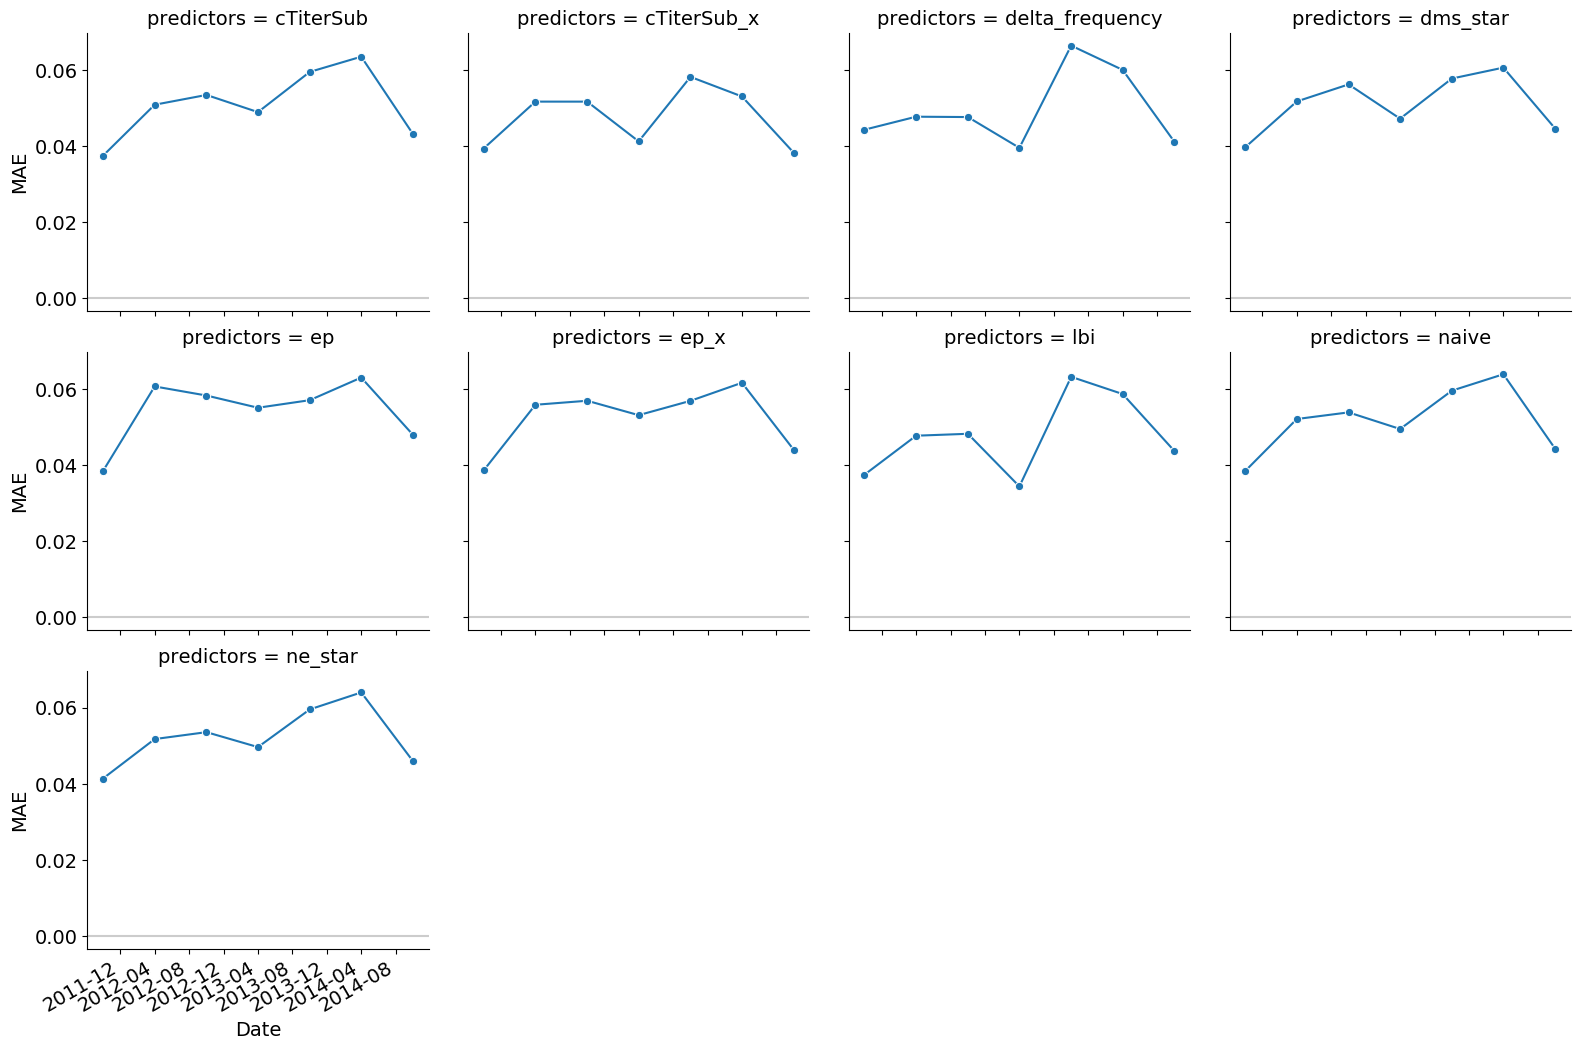

In [648]:
g = facet_time_plot(mae_by_timepoint_df, "mae", "MAE", timepoint_column="validation_timepoint")

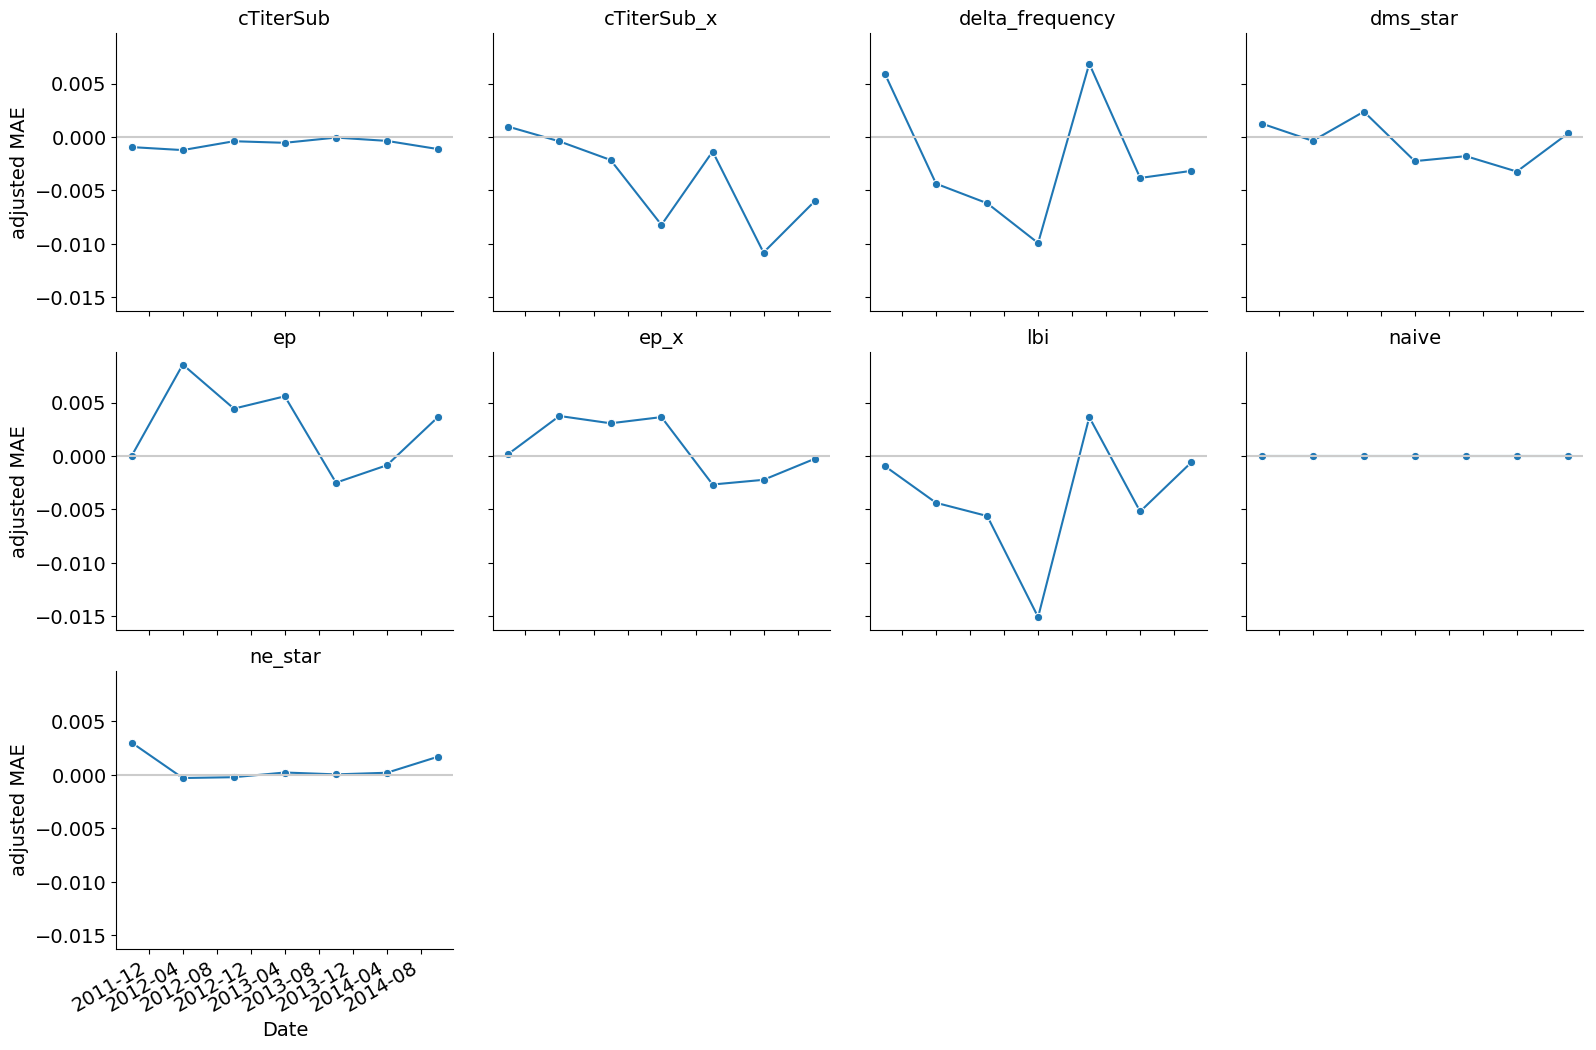

In [649]:
g = facet_time_plot(mae_by_timepoint_df, "adjusted_mae", "adjusted MAE", timepoint_column="validation_timepoint")
g.set_titles("{col_name}")

### Root mean square error (RMSE)

In [650]:
rmse_df = frequency_df.groupby("predictors").apply(
    lambda group_df: root_mean_square_error(group_df["frequency"], group_df["frequency_hat"])
).reset_index().rename(columns={0: "rmse"})

In [651]:
rmse_df.sort_values("rmse")

predictors      rmse
1      cTiterSub_x  0.110713
6              lbi  0.112752
2  delta_frequency  0.114123
0        cTiterSub  0.114911
7            naive  0.116823
3         dms_star  0.116834
8          ne_star  0.118642
5             ep_x  0.119819
4               ep  0.126746

In [652]:
rmse_by_timepoint_df = frequency_df.groupby(["predictors", "validation_timepoint"]).apply(
    lambda group_df: root_mean_square_error(group_df["frequency"], group_df["frequency_hat"])
).reset_index().rename(columns={0: "rmse"})

In [653]:
naive_rmse = rmse_by_timepoint_df[rmse_by_timepoint_df["predictors"] == "naive"]["rmse"].values
for predictor in rmse_by_timepoint_df["predictors"].drop_duplicates().values:
    rmse_by_timepoint_df.loc[rmse_by_timepoint_df["predictors"] == predictor, "adjusted_rmse"] =  rmse_by_timepoint_df.loc[rmse_by_timepoint_df["predictors"] == predictor, "rmse"] - naive_rmse

In [654]:
rmse_df["adjusted_rmse"] = rmse_df["rmse"] - rmse_df[rmse_df["predictors"] == "naive"]["rmse"].iloc[0]

(0, 0.12093512332893866)

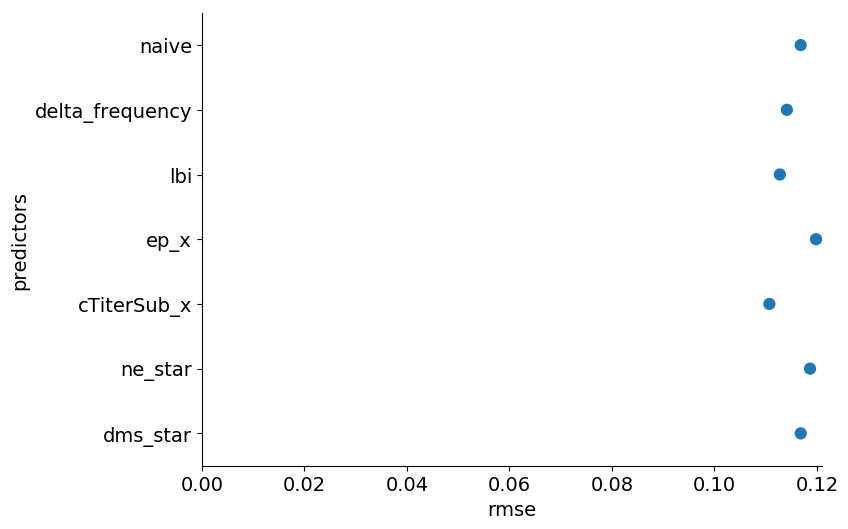

In [655]:
fig, ax = plt.subplots(1, 1, figsize=(8, 6))
sns.pointplot(
    x="rmse",
    y="predictors",
    data=rmse_df,
    join=False,
    order=predictor_names_order,
    ax=ax
)
ax.set_xlim(left=0)

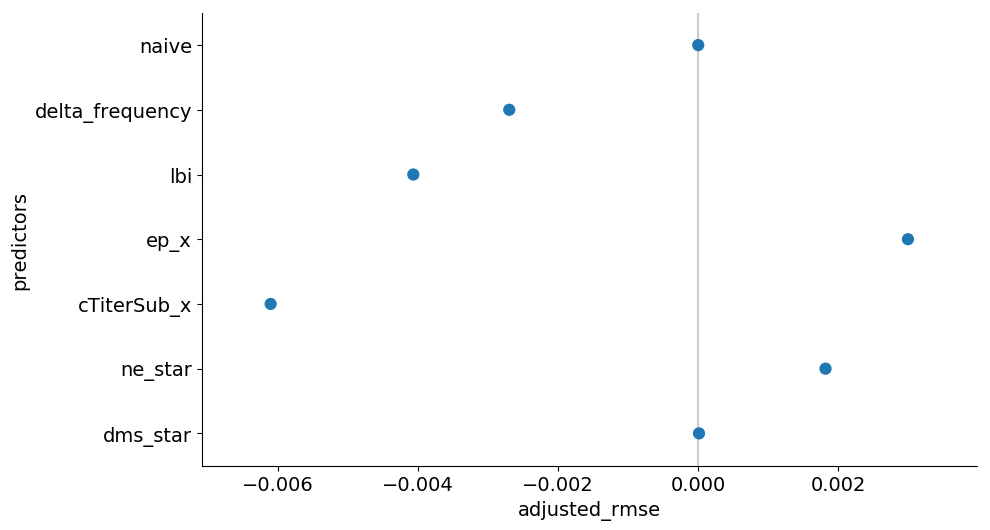

In [656]:
fig, ax = plt.subplots(1, 1, figsize=(10, 6))
sns.pointplot(
    x="adjusted_rmse",
    y="predictors",
    data=rmse_df,
    join=False,
    order=predictor_names_order,
    ax=ax
)
ax.axvline(x=0.0, color="#cccccc", zorder=-10)
#ax.set_xlim(left=0)

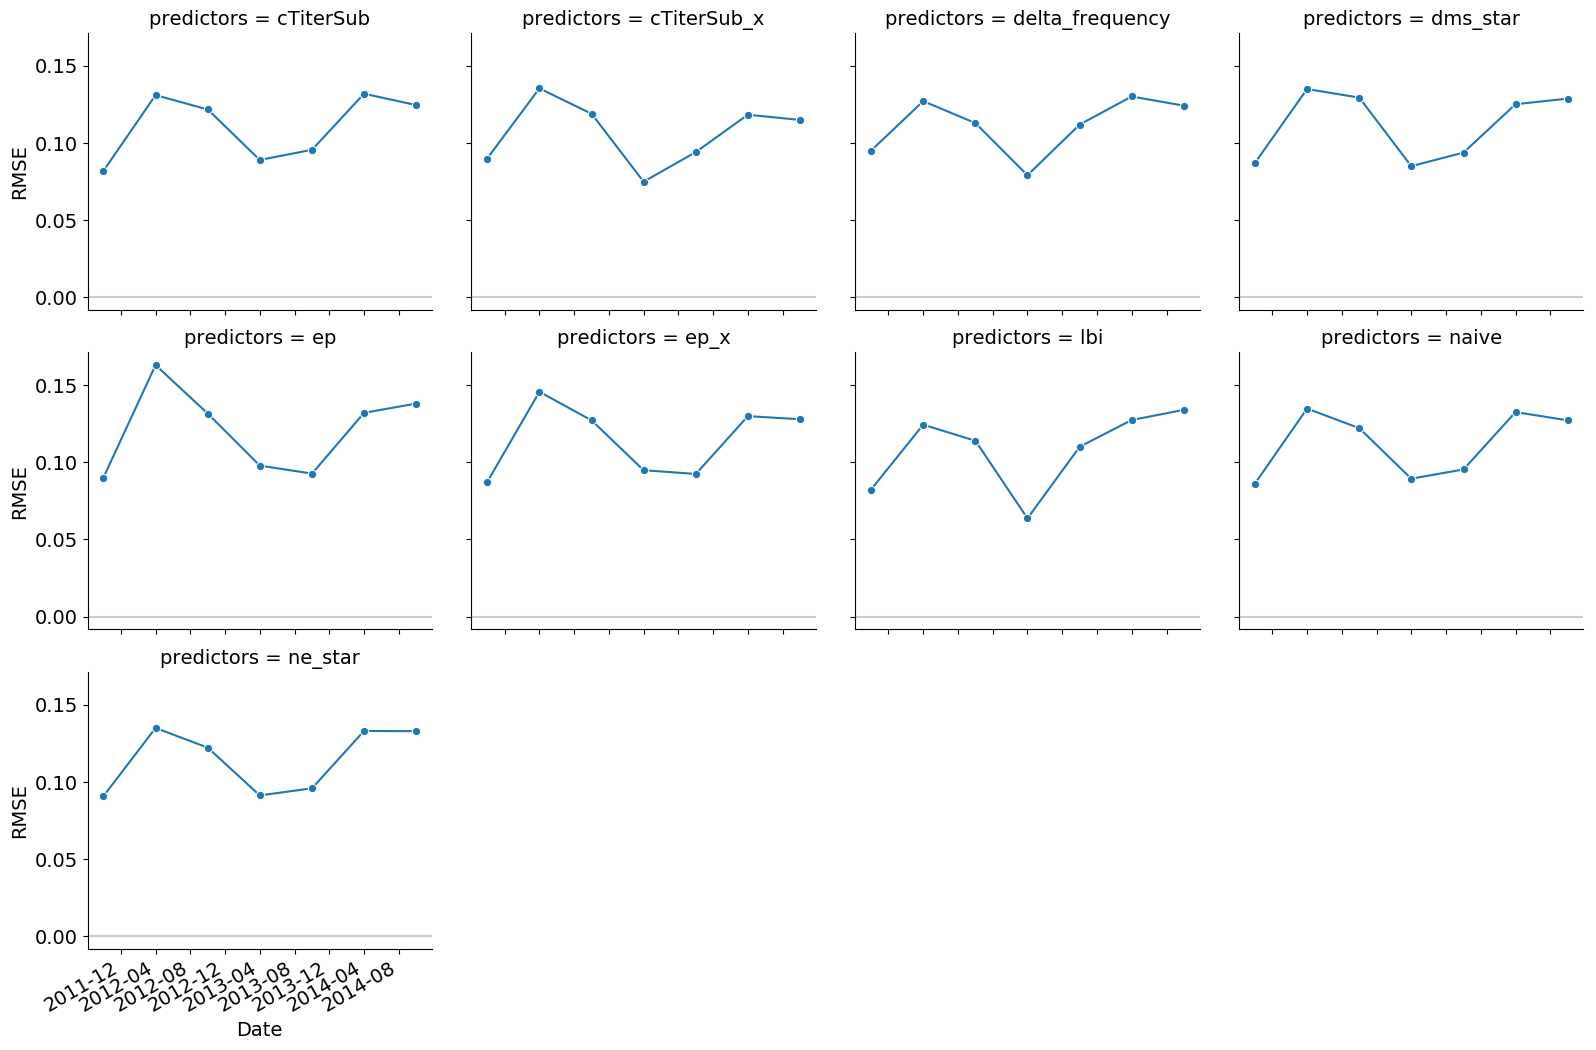

In [657]:
g = facet_time_plot(rmse_by_timepoint_df, "rmse", "RMSE", timepoint_column="validation_timepoint")

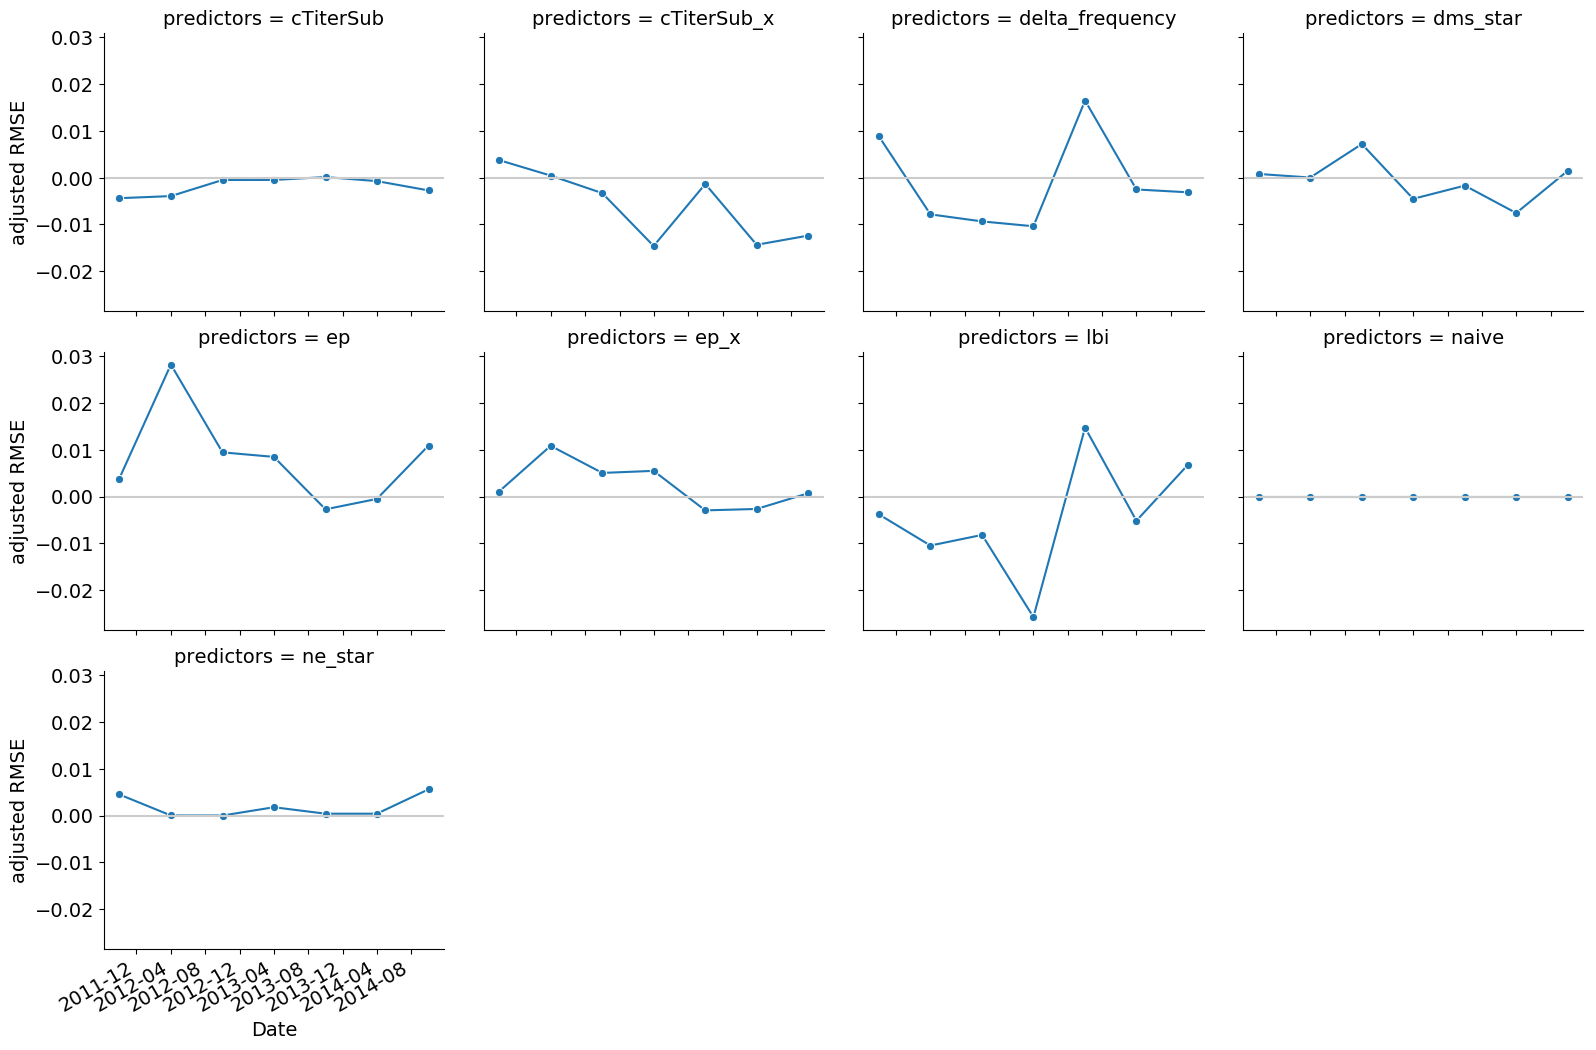

In [658]:
g = facet_time_plot(rmse_by_timepoint_df, "adjusted_rmse", "adjusted RMSE", timepoint_column="validation_timepoint")

### Mean squared error (MSE)

In [659]:
mse_df = frequency_df.groupby("predictors").apply(
    lambda group_df: mean_square_error(group_df["frequency"], group_df["frequency_hat"])
).reset_index().rename(columns={0: "mse"})

In [660]:
mse_by_timepoint_df = frequency_df.groupby(["predictors", "validation_timepoint"]).apply(
    lambda group_df: mean_square_error(group_df["frequency"], group_df["frequency_hat"])
).reset_index().rename(columns={0: "mse"})

In [661]:
naive_mse = mse_by_timepoint_df[mse_by_timepoint_df["predictors"] == "naive"]["mse"].values
for predictor in mse_by_timepoint_df["predictors"].drop_duplicates().values:
    mse_by_timepoint_df.loc[mse_by_timepoint_df["predictors"] == predictor, "adjusted_mse"] =  mse_by_timepoint_df.loc[mse_by_timepoint_df["predictors"] == predictor, "mse"] - naive_mse

(0, 0.015122067779907527)

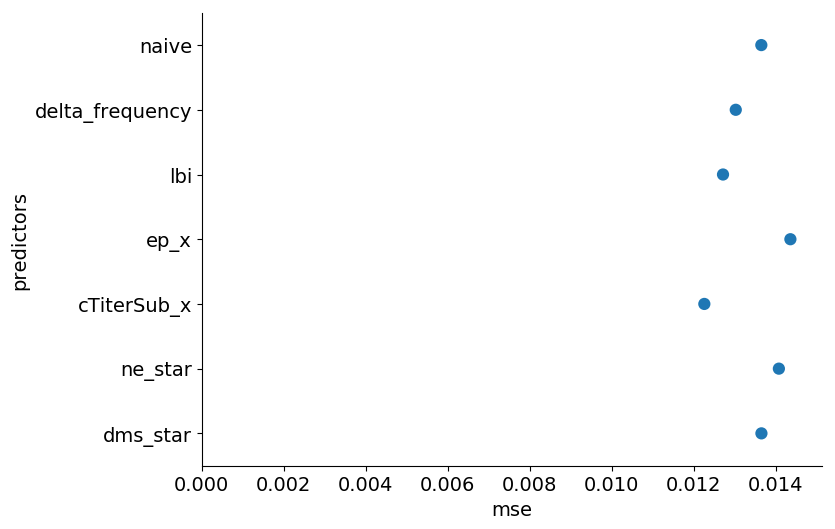

In [662]:
fig, ax = plt.subplots(1, 1, figsize=(8, 6))
sns.pointplot(
    x="mse",
    y="predictors",
    data=mse_df,
    join=False,
    order=predictor_names_order,
    ax=ax
)
ax.set_xlim(left=0)

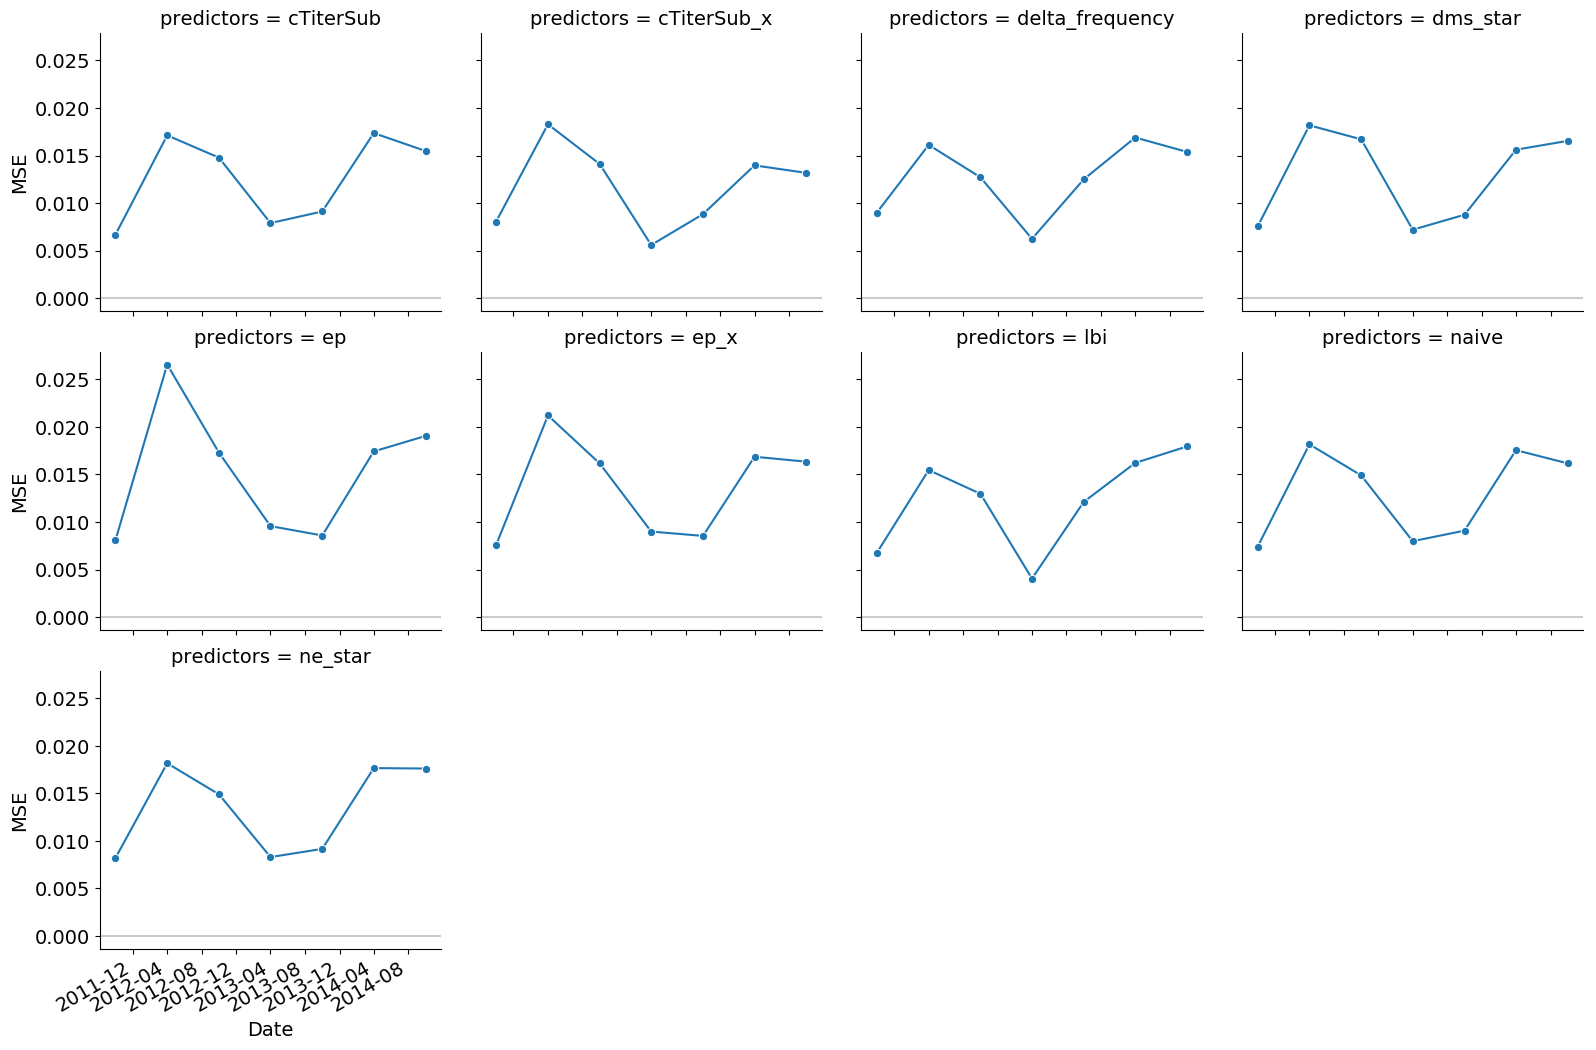

In [663]:
g = facet_time_plot(mse_by_timepoint_df, "mse", "MSE", timepoint_column="validation_timepoint")

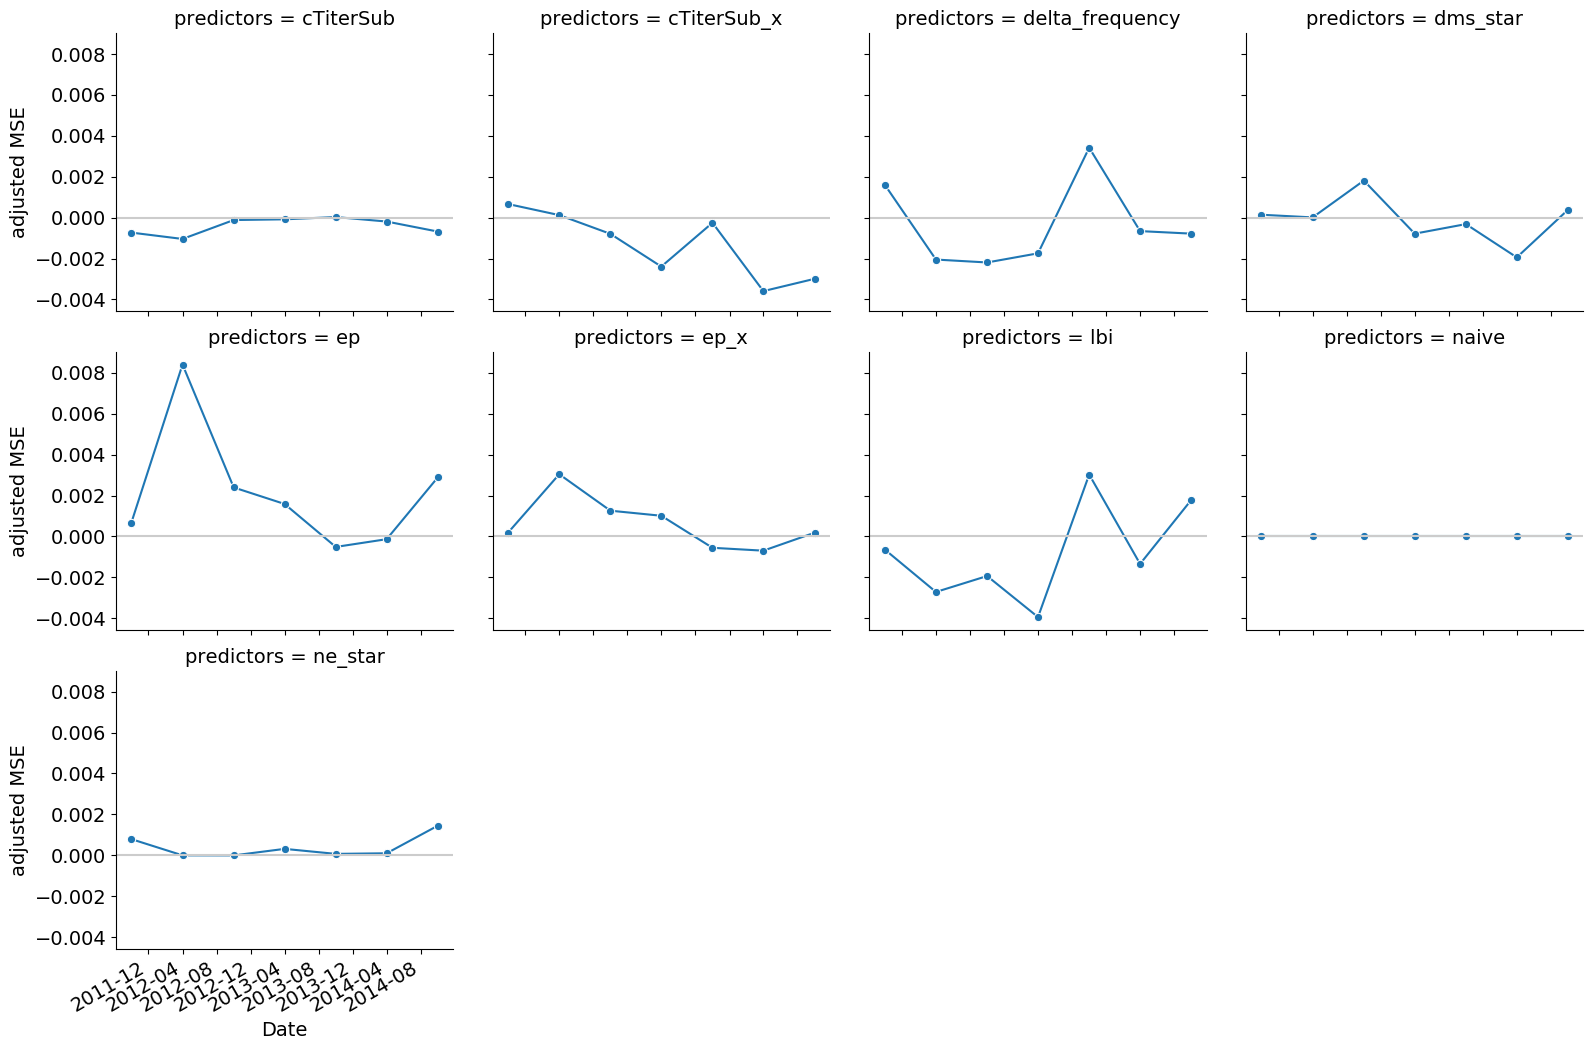

In [664]:
g = facet_time_plot(mse_by_timepoint_df, "adjusted_mse", "adjusted MSE", timepoint_column="validation_timepoint")

(0.0, 0.027835735190949402)

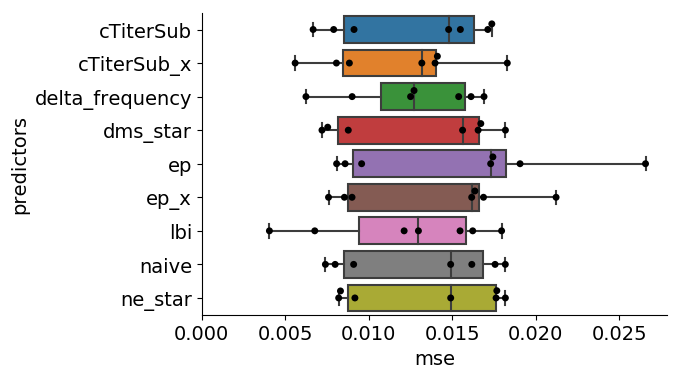

In [665]:
ax = sns.boxplot(
    "mse",
    "predictors",
    data=mse_by_timepoint_df
)
ax = sns.swarmplot(
    "mse",
    "predictors",
    data=mse_by_timepoint_df,
    color="black",
    ax=ax
)
ax.set_xlim(left=0.0)

## Summarize model coefficients

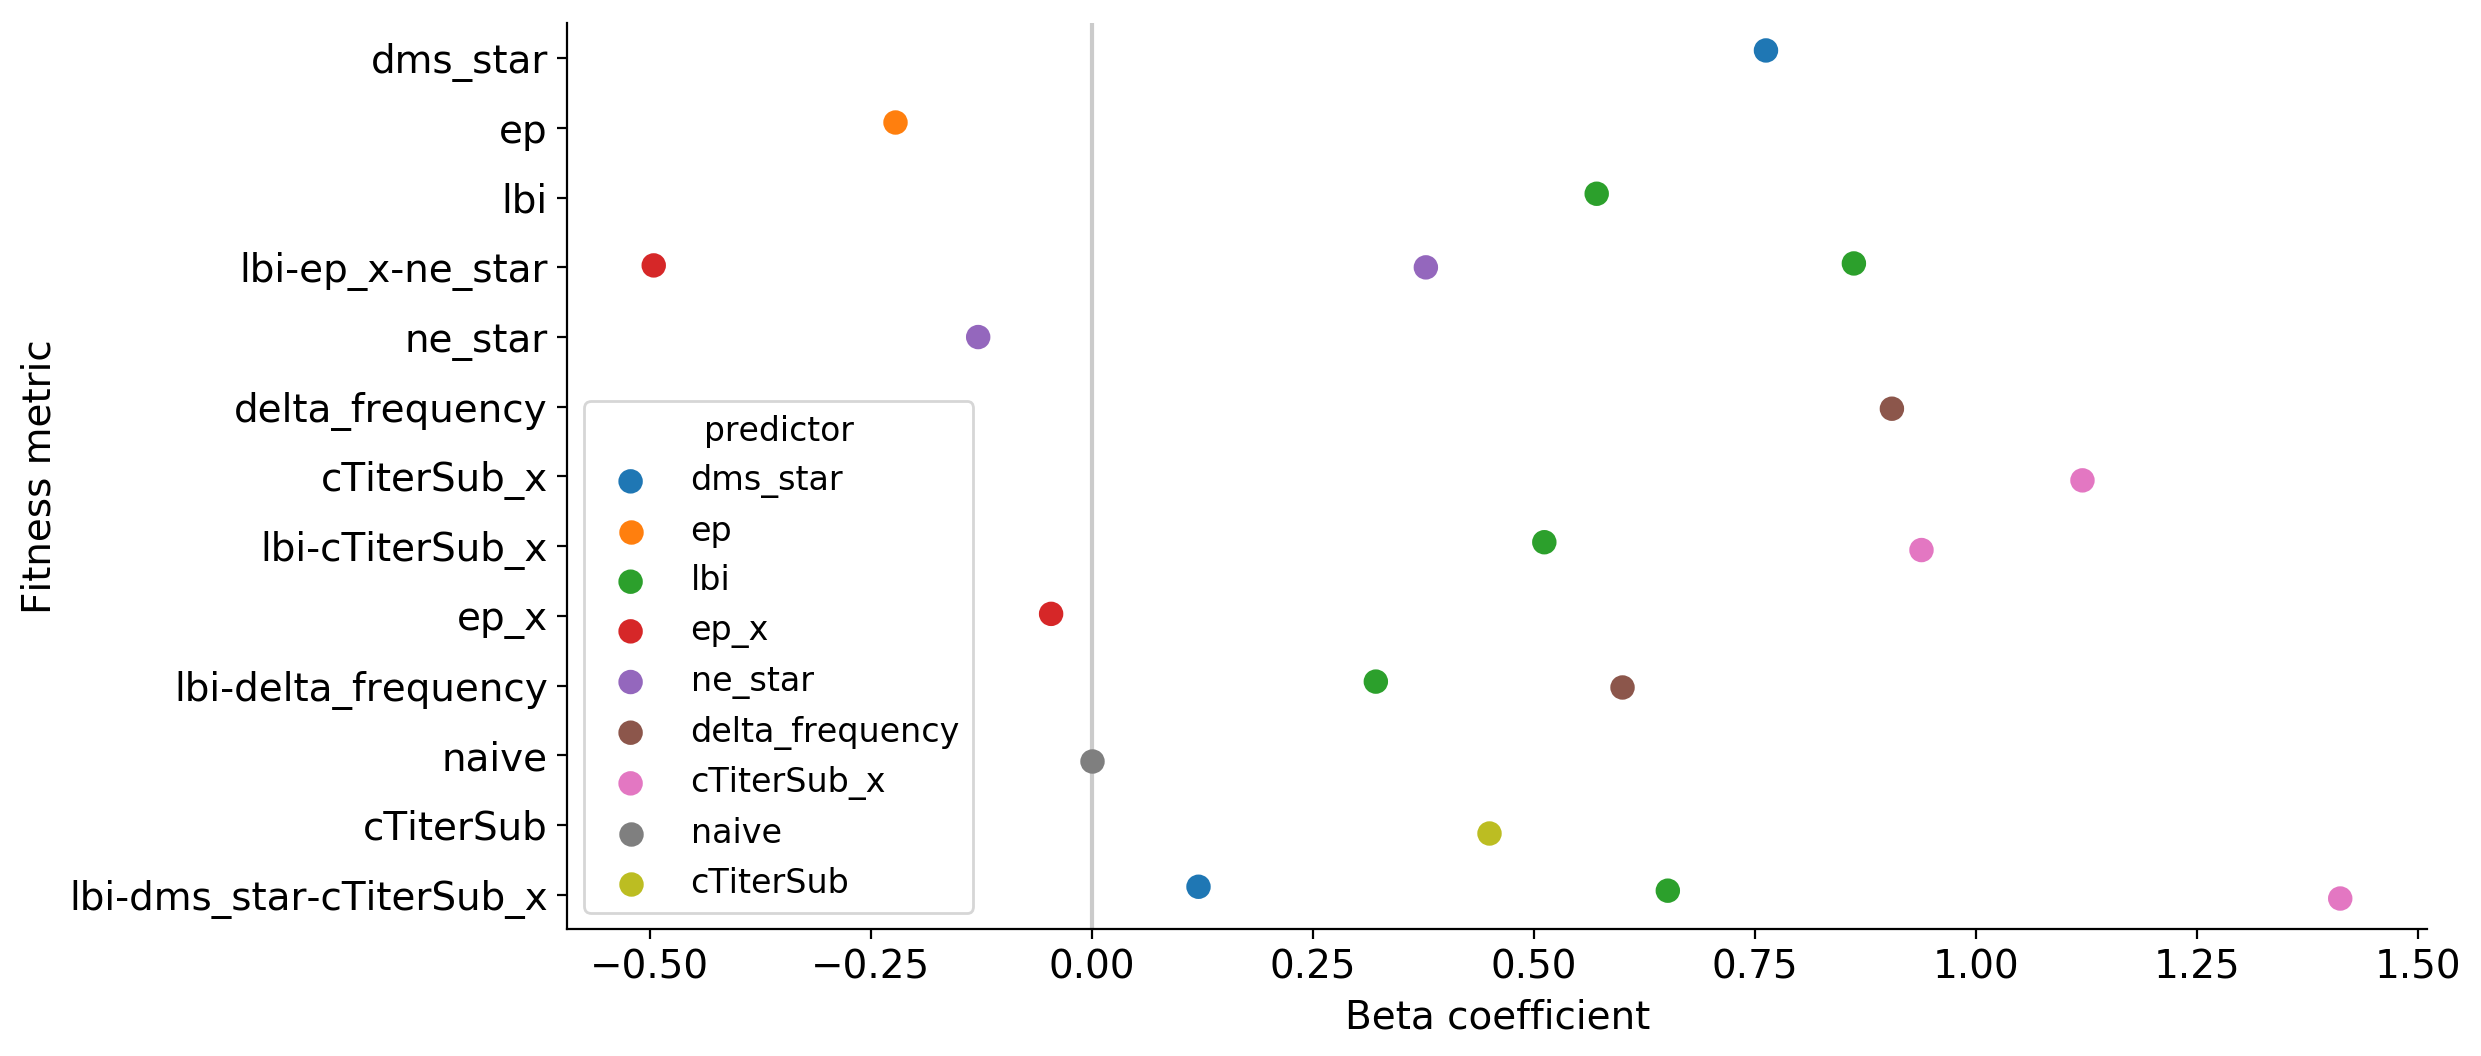

In [507]:
fig, ax = plt.subplots(1, 1, figsize=(12, 6))
sns.pointplot(
    y="predictors",
    x="mean",
    hue="predictor",
    data=overall_coefficients_df,
    ax=ax,
    dodge=True,
    join=False
    #order=predictor_names_order
)

ax.axvline(0, color="#999999", alpha=0.5, zorder=-10)
ax.set_xlabel("Beta coefficient")
ax.set_ylabel("Fitness metric")

sns.despine()

In [508]:
overall_coefficients_df

mean        predictor                predictors       std
0   0.762246         dms_star                  dms_star  0.238348
1  -0.222770               ep                        ep  0.532541
2   0.570822              lbi                       lbi  0.209874
3   0.861663              lbi          lbi-ep_x-ne_star  0.266605
4  -0.495507             ep_x          lbi-ep_x-ne_star  0.253063
5   0.377642          ne_star          lbi-ep_x-ne_star  0.336858
6  -0.128612          ne_star                   ne_star  0.250961
7   0.904648  delta_frequency           delta_frequency  0.149292
8   1.120144      cTiterSub_x               cTiterSub_x  0.355225
9   0.511590              lbi           lbi-cTiterSub_x  0.214261
10  0.938091      cTiterSub_x           lbi-cTiterSub_x  0.429937
11 -0.046149             ep_x                      ep_x  0.302305
12  0.321070              lbi       lbi-delta_frequency  0.297400
13  0.600031  delta_frequency       lbi-delta_frequency  0.273658
14  0.000000            naive                     naive  0.000000
15  0.448785        cTiterSub                 cTiterSub  0.134406
16  0.651253              lbi  lbi-dms_star-cTiterSub_x  0.506003
17  0.120531         dms_star  lbi-dms_star-cTiterSub_x  0.801584
18  1.411619      cTiterSub_x  lbi-dms_star-cTiterSub_x  0.768499

In [509]:
coefficients_by_time_df.head()

coefficient predictor predictors validation_timepoint
0     1.185877  dms_star   dms_star           2011-10-01
1     0.823009  dms_star   dms_star           2012-04-01
2     0.876235  dms_star   dms_star           2012-10-01
3     0.847411  dms_star   dms_star           2013-04-01
4     0.573546  dms_star   dms_star           2013-10-01

In [510]:
coefficients_by_time_df.tail()

coefficient    predictor                predictors validation_timepoint
128    -0.752445     dms_star  lbi-dms_star-cTiterSub_x           2014-04-01
129     2.109063  cTiterSub_x  lbi-dms_star-cTiterSub_x           2014-04-01
130     0.618269          lbi  lbi-dms_star-cTiterSub_x           2014-10-01
131     0.293581     dms_star  lbi-dms_star-cTiterSub_x           2014-10-01
132     1.430710  cTiterSub_x  lbi-dms_star-cTiterSub_x           2014-10-01

In [511]:
coefficients_by_time_df["predictors_name"] = coefficients_by_time_df["predictors"].map(predictor_name_by_id)

In [512]:
coefficients_by_time_df.loc[pd.isnull(coefficients_by_time_df["predictors_name"]), "predictors_name"] = coefficients_by_time_df.loc[
    pd.isnull(coefficients_by_time_df["predictors_name"]), "predictors"
]

In [513]:
coefficients_by_time_df["predictors_name"].unique().shape

(13,)

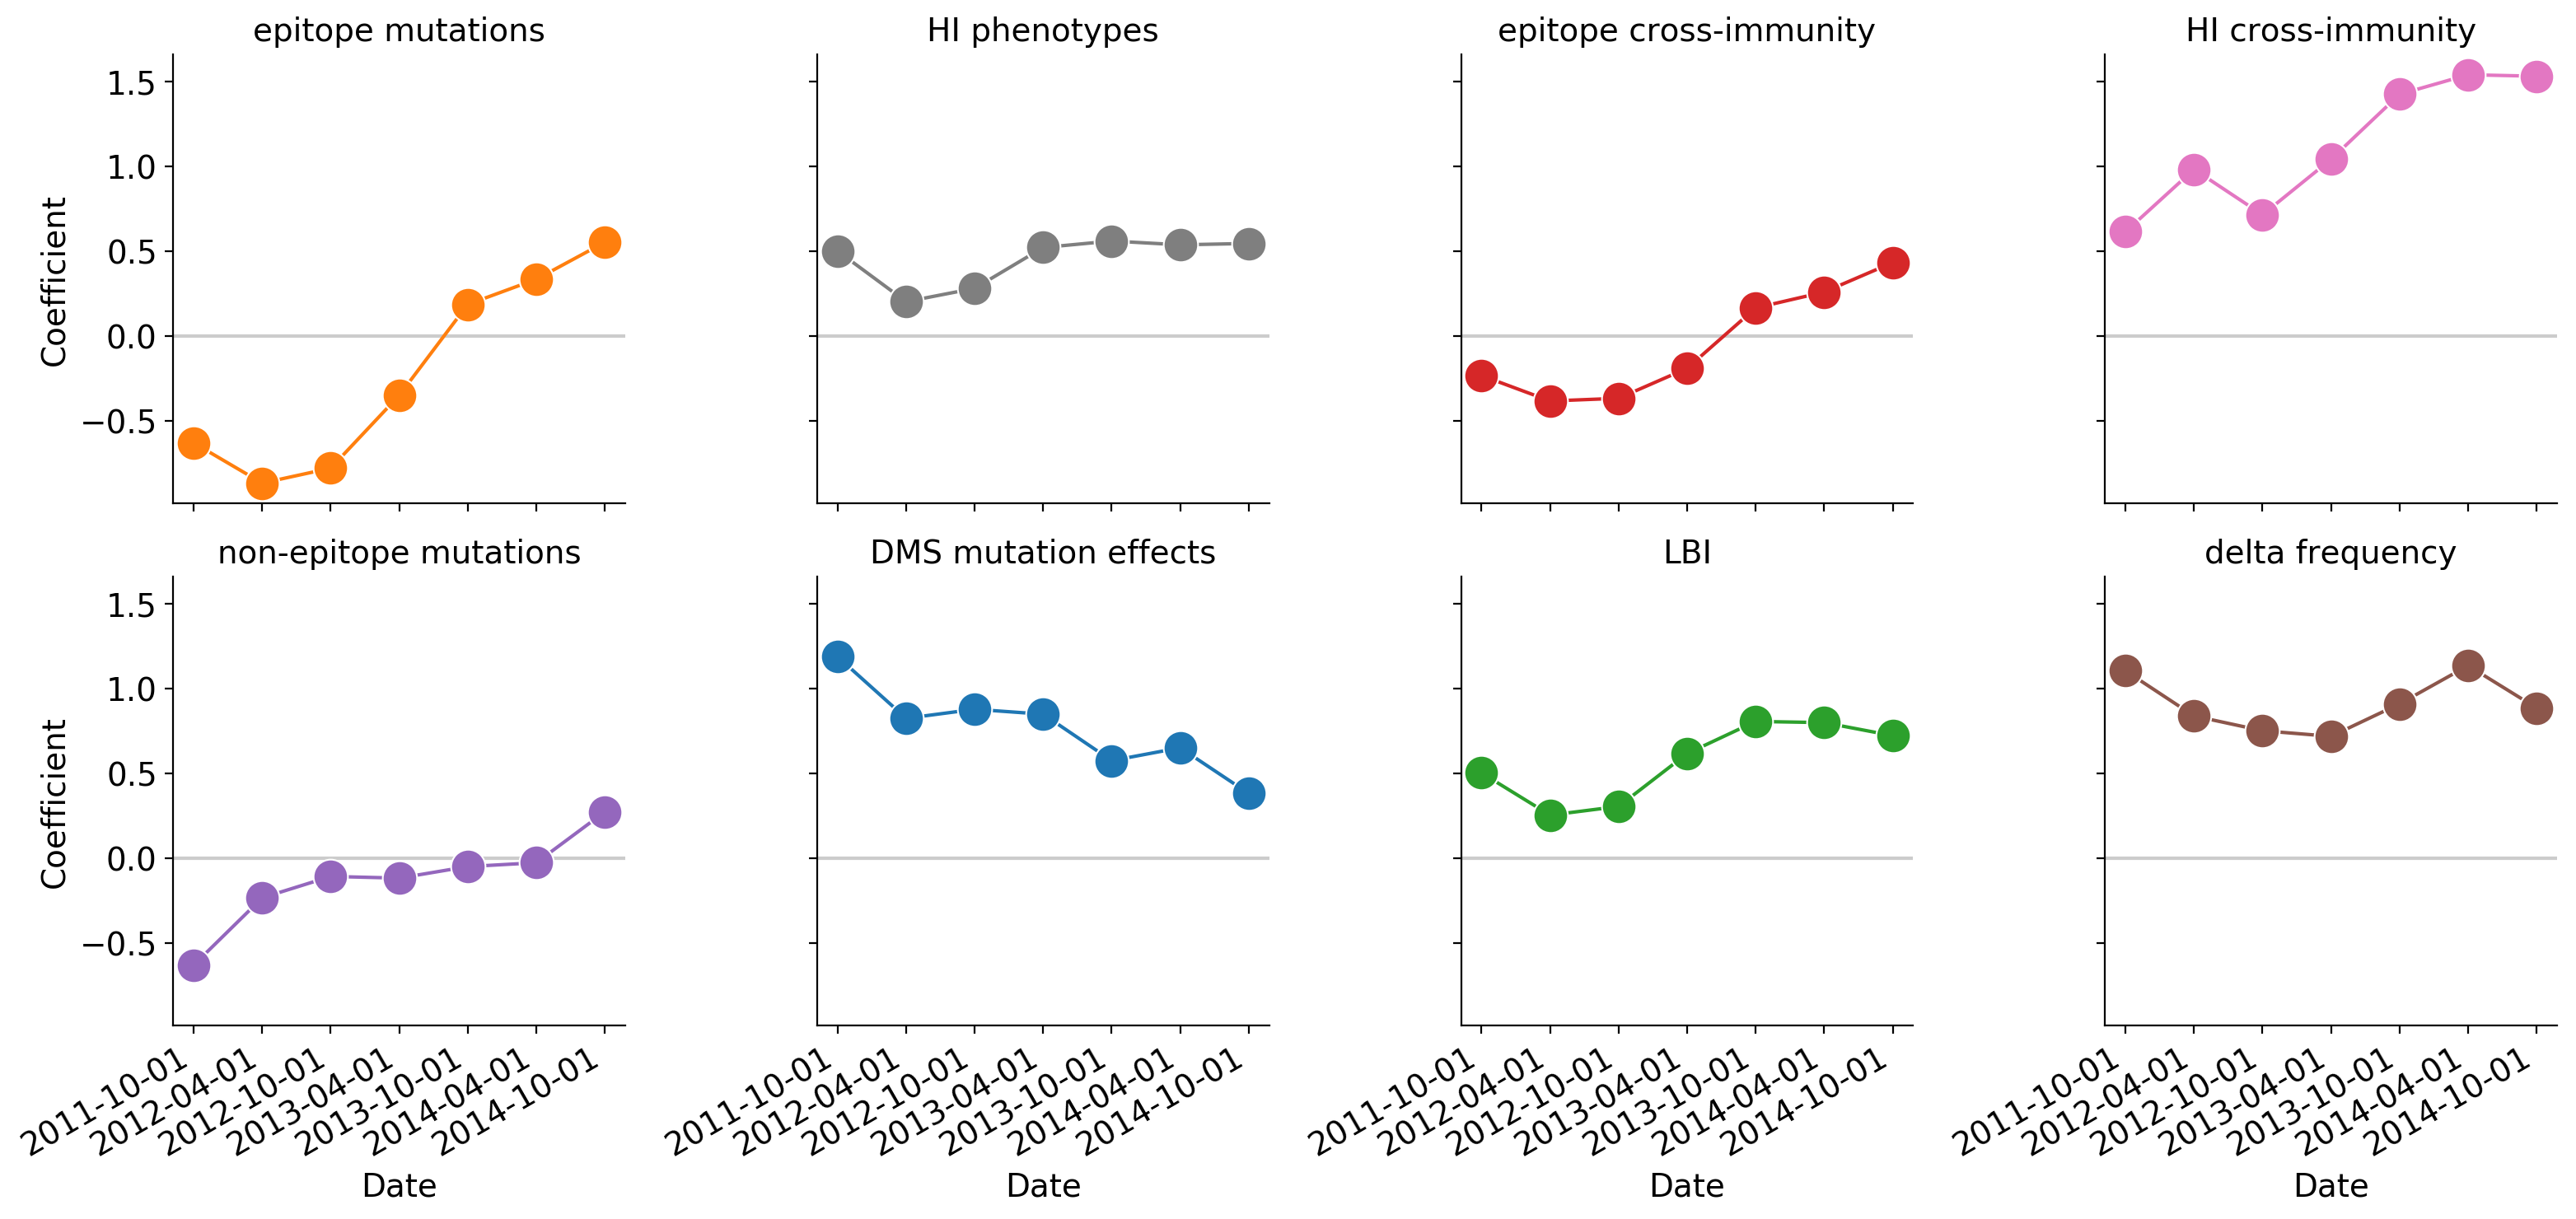

In [514]:
g = facet_time_plot(
    coefficients_by_time_df[coefficients_by_time_df["predictors"] != "naive"],
    "coefficient",
    "Coefficient",
    timepoint_column="validation_timepoint",
    predictors_column="predictors_name",
    col_order=[predictor_name_by_id[predictor] for predictor in predictor_type_order[1:]],
    hue="predictor"
)
g.set_titles("{col_name}")

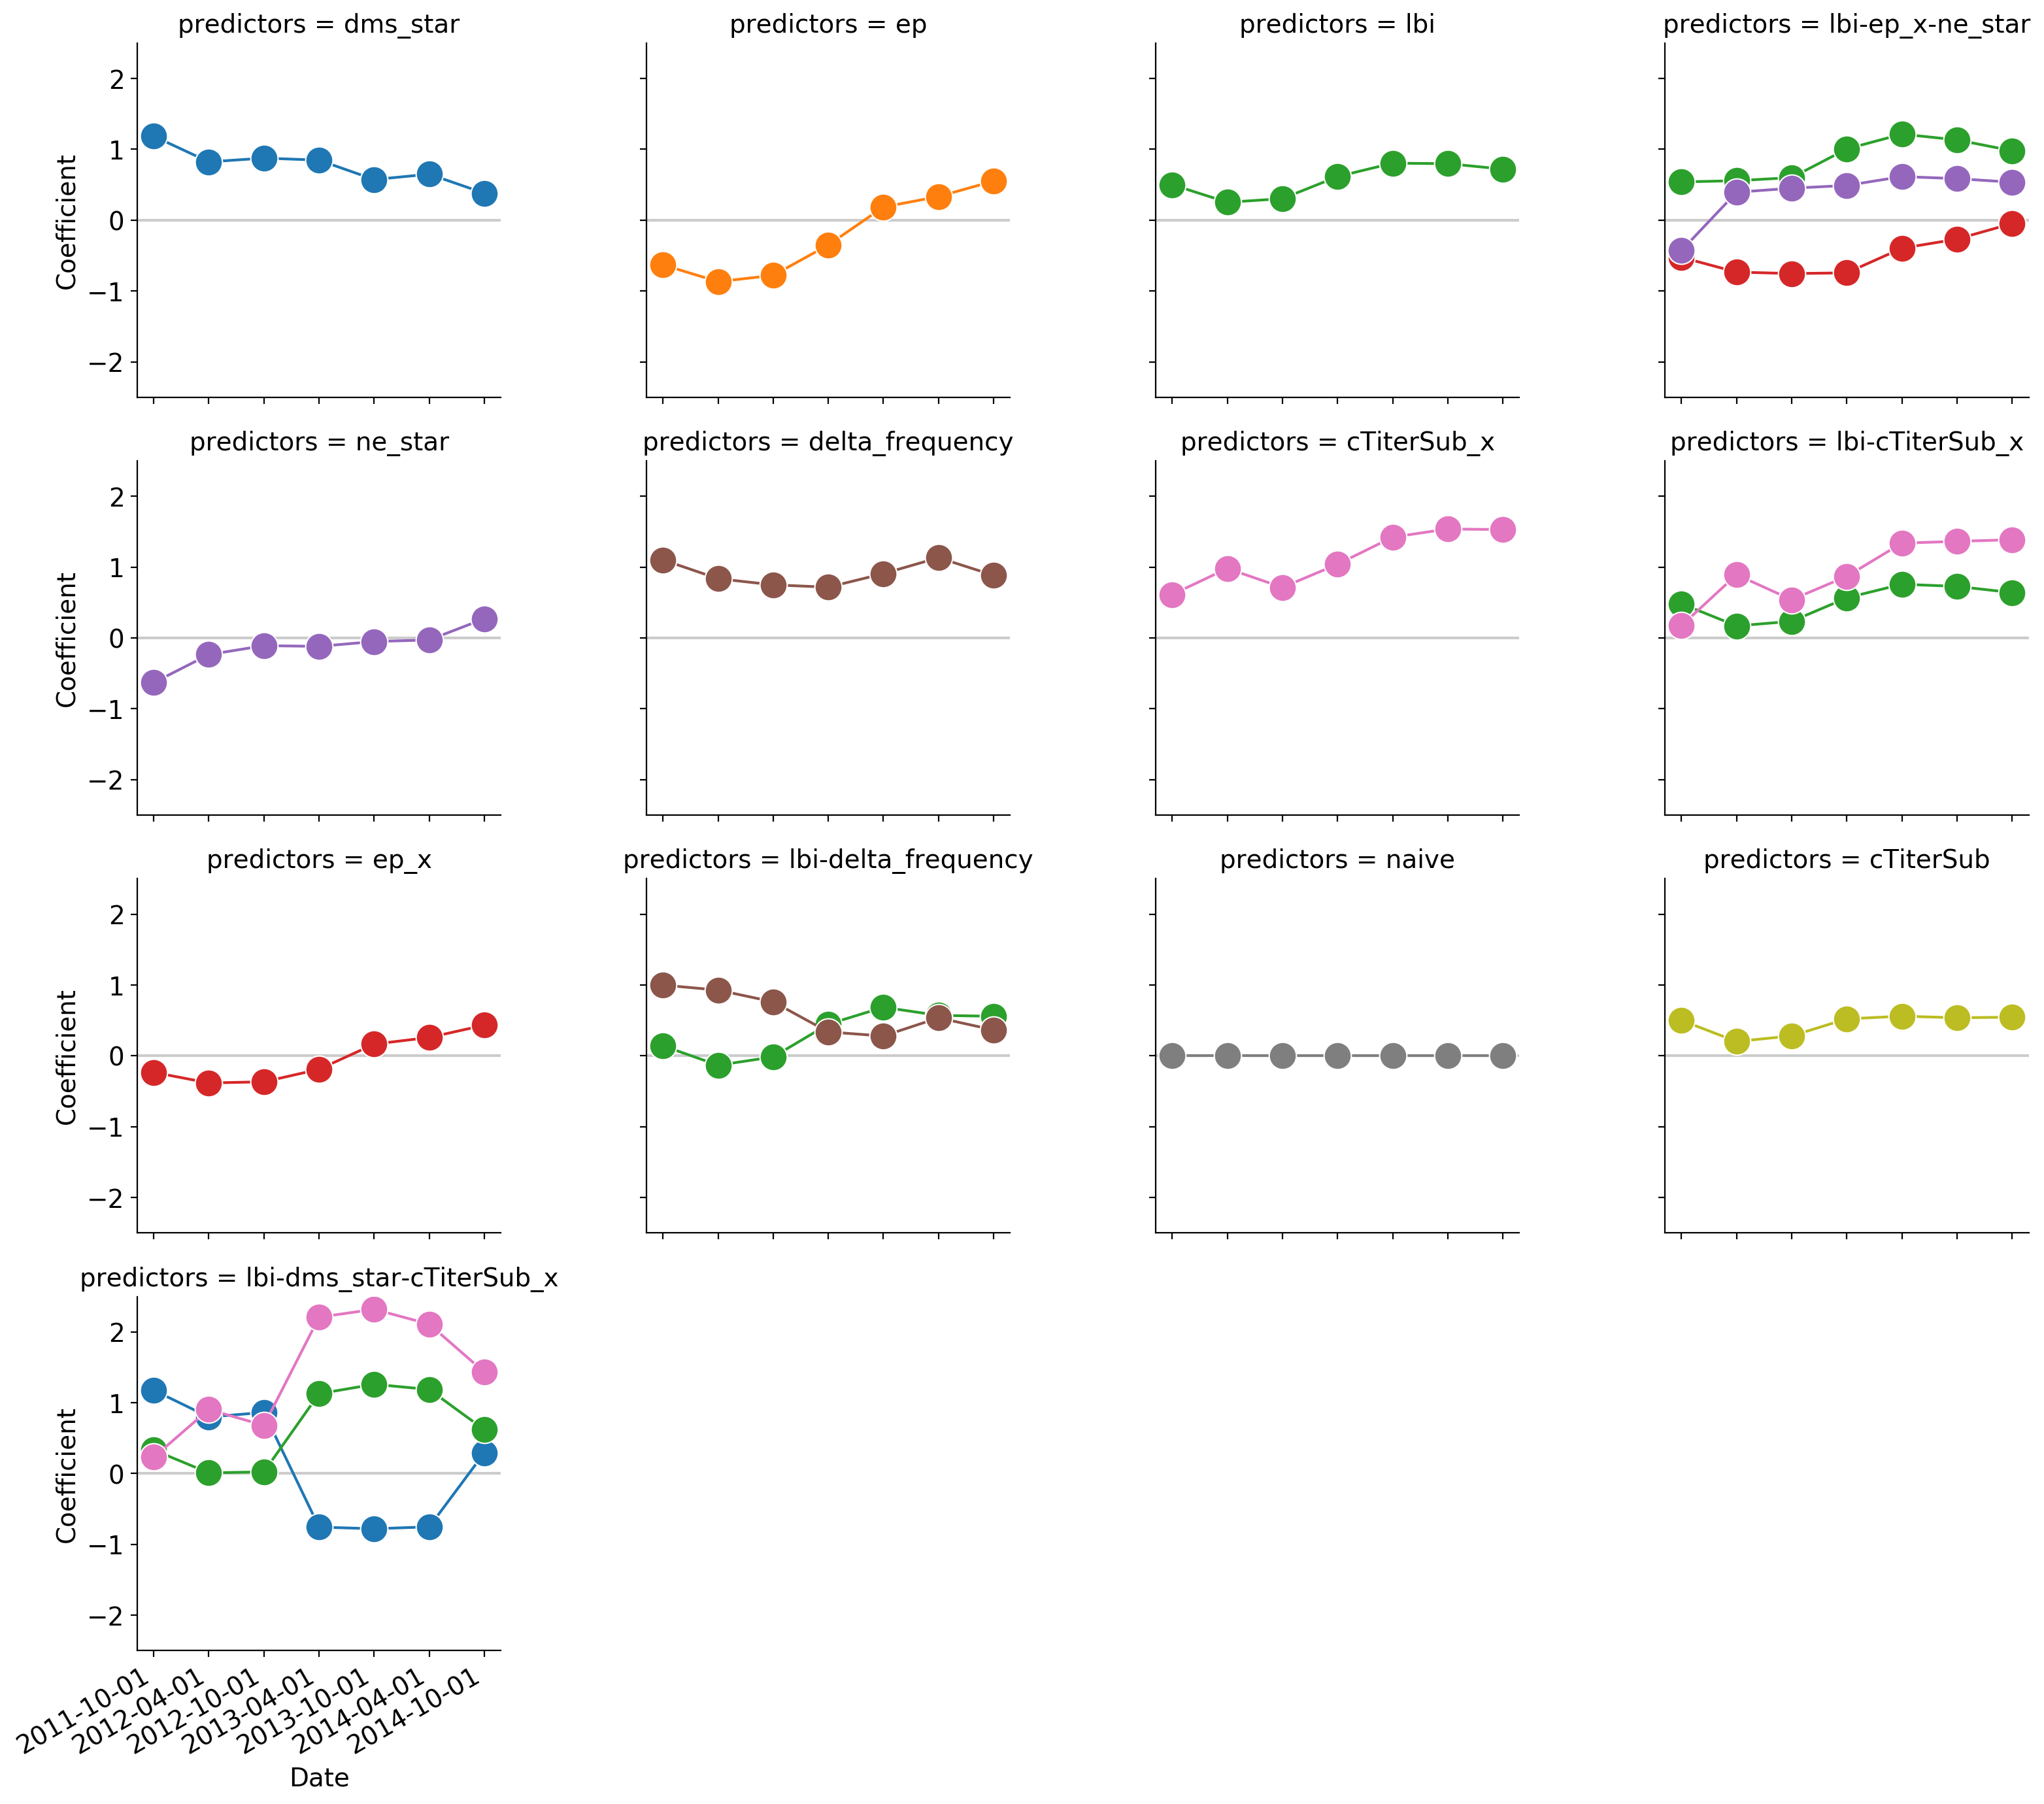

In [515]:
g = facet_time_plot(coefficients_by_time_df, "coefficient", "Coefficient", timepoint_column="validation_timepoint", hue="predictor")

for ax in g.axes.flatten():
    ax.set_ylim(-2.5, 2.5)

In [516]:
print(coefficients_by_time_df.loc[coefficients_by_time_df["predictors"] == "ep", ["validation_timepoint", "coefficient"]])

   validation_timepoint  coefficient
7            2011-10-01    -0.631072
8            2012-04-01    -0.868061
9            2012-10-01    -0.779862
10           2013-04-01    -0.350565
11           2013-10-01     0.185089
12           2014-04-01     0.333486
13           2014-10-01     0.551594


In [519]:
composite_predictors_order

['lbi',
 'delta_frequency',
 'cTiterSub_x',
 'lbi-delta_frequency',
 'lbi-cTiterSub_x',
 'lbi-dms_star-cTiterSub_x',
 'lbi-ep_x-ne_star']

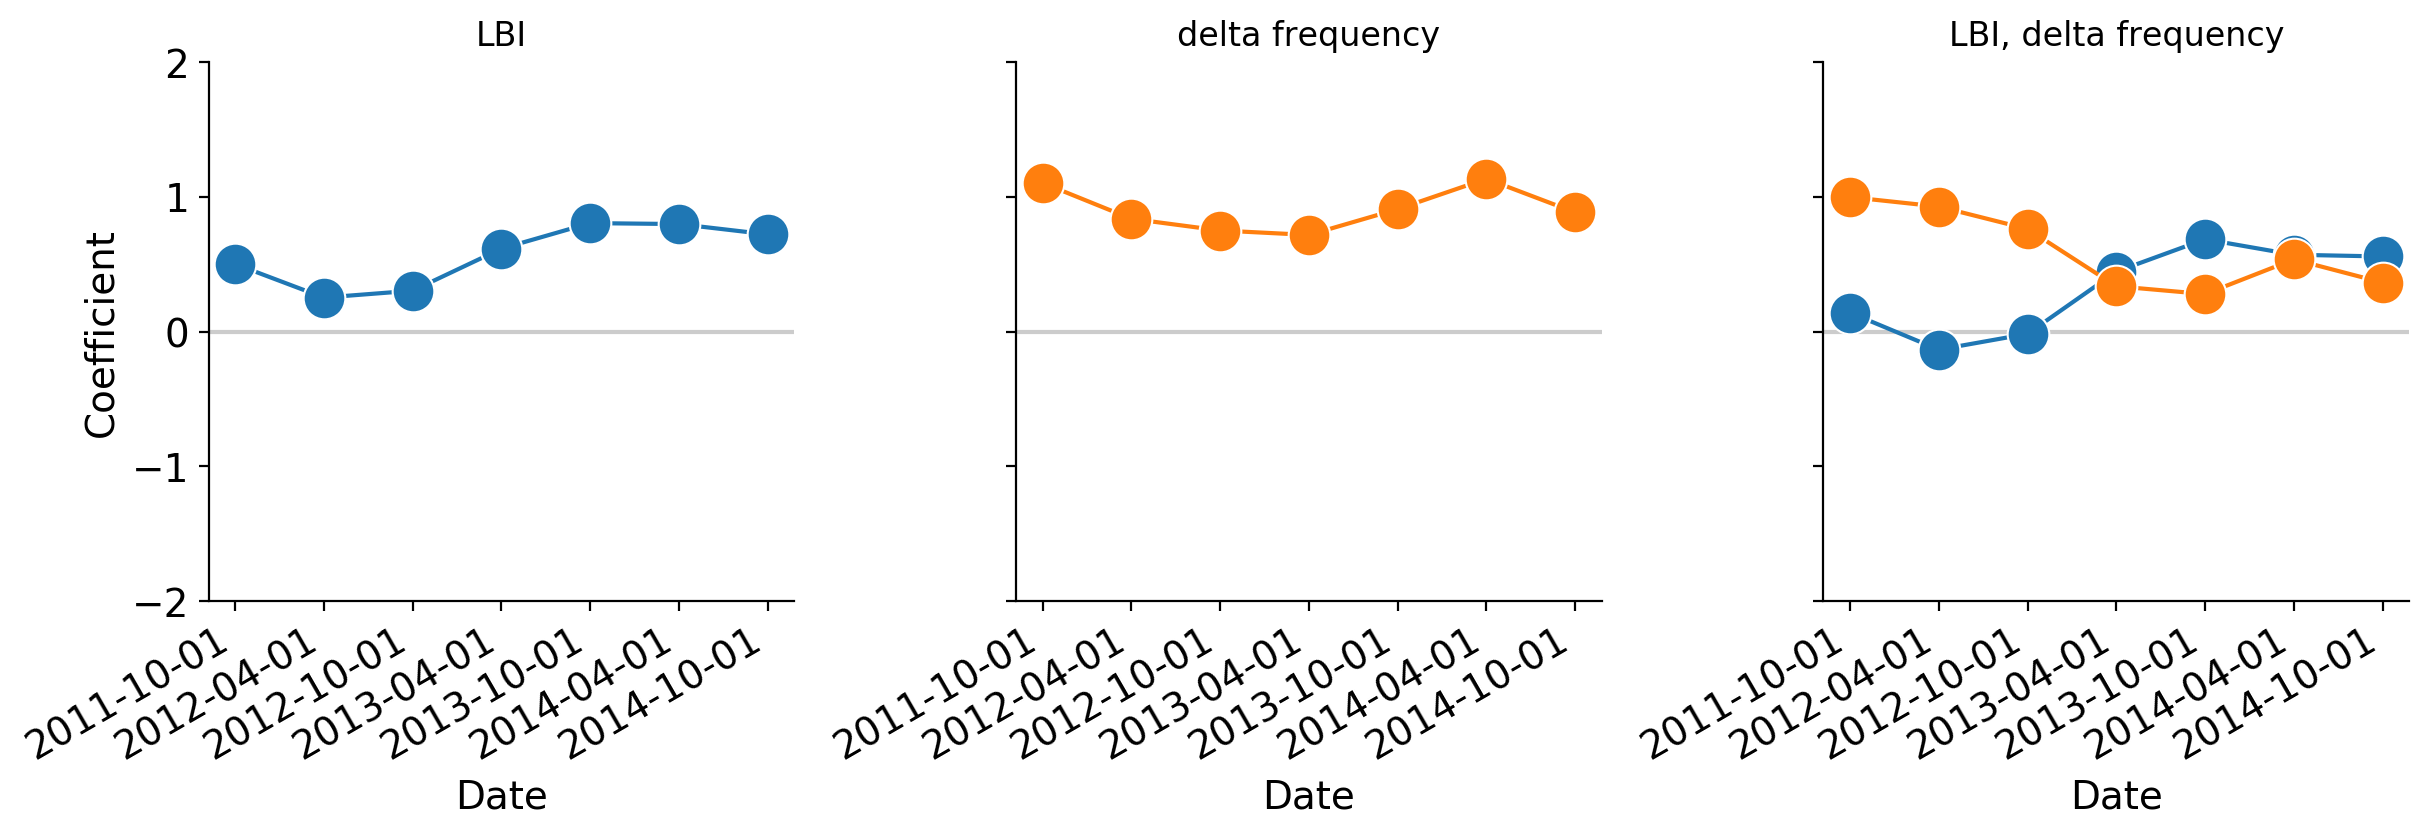

In [530]:
lbi_dfreq_order = ["lbi", "delta_frequency", "lbi-delta_frequency"]
lbi_dfreq_names = ["LBI", "delta frequency", "LBI, delta frequency"]
g = facet_time_plot(
    coefficients_by_time_df[coefficients_by_time_df["predictors"].isin(lbi_dfreq_order)],
    "coefficient",
    "Coefficient",
    timepoint_column="validation_timepoint",
    hue="predictor",
    col_order=lbi_dfreq_order
)

#g.set_titles("{col_name}")

for ci, ax in enumerate(g.axes.flatten()):
    ax.set_title(lbi_dfreq_names[ci], fontsize=12)
    ax.set_ylim(-2., 2.)

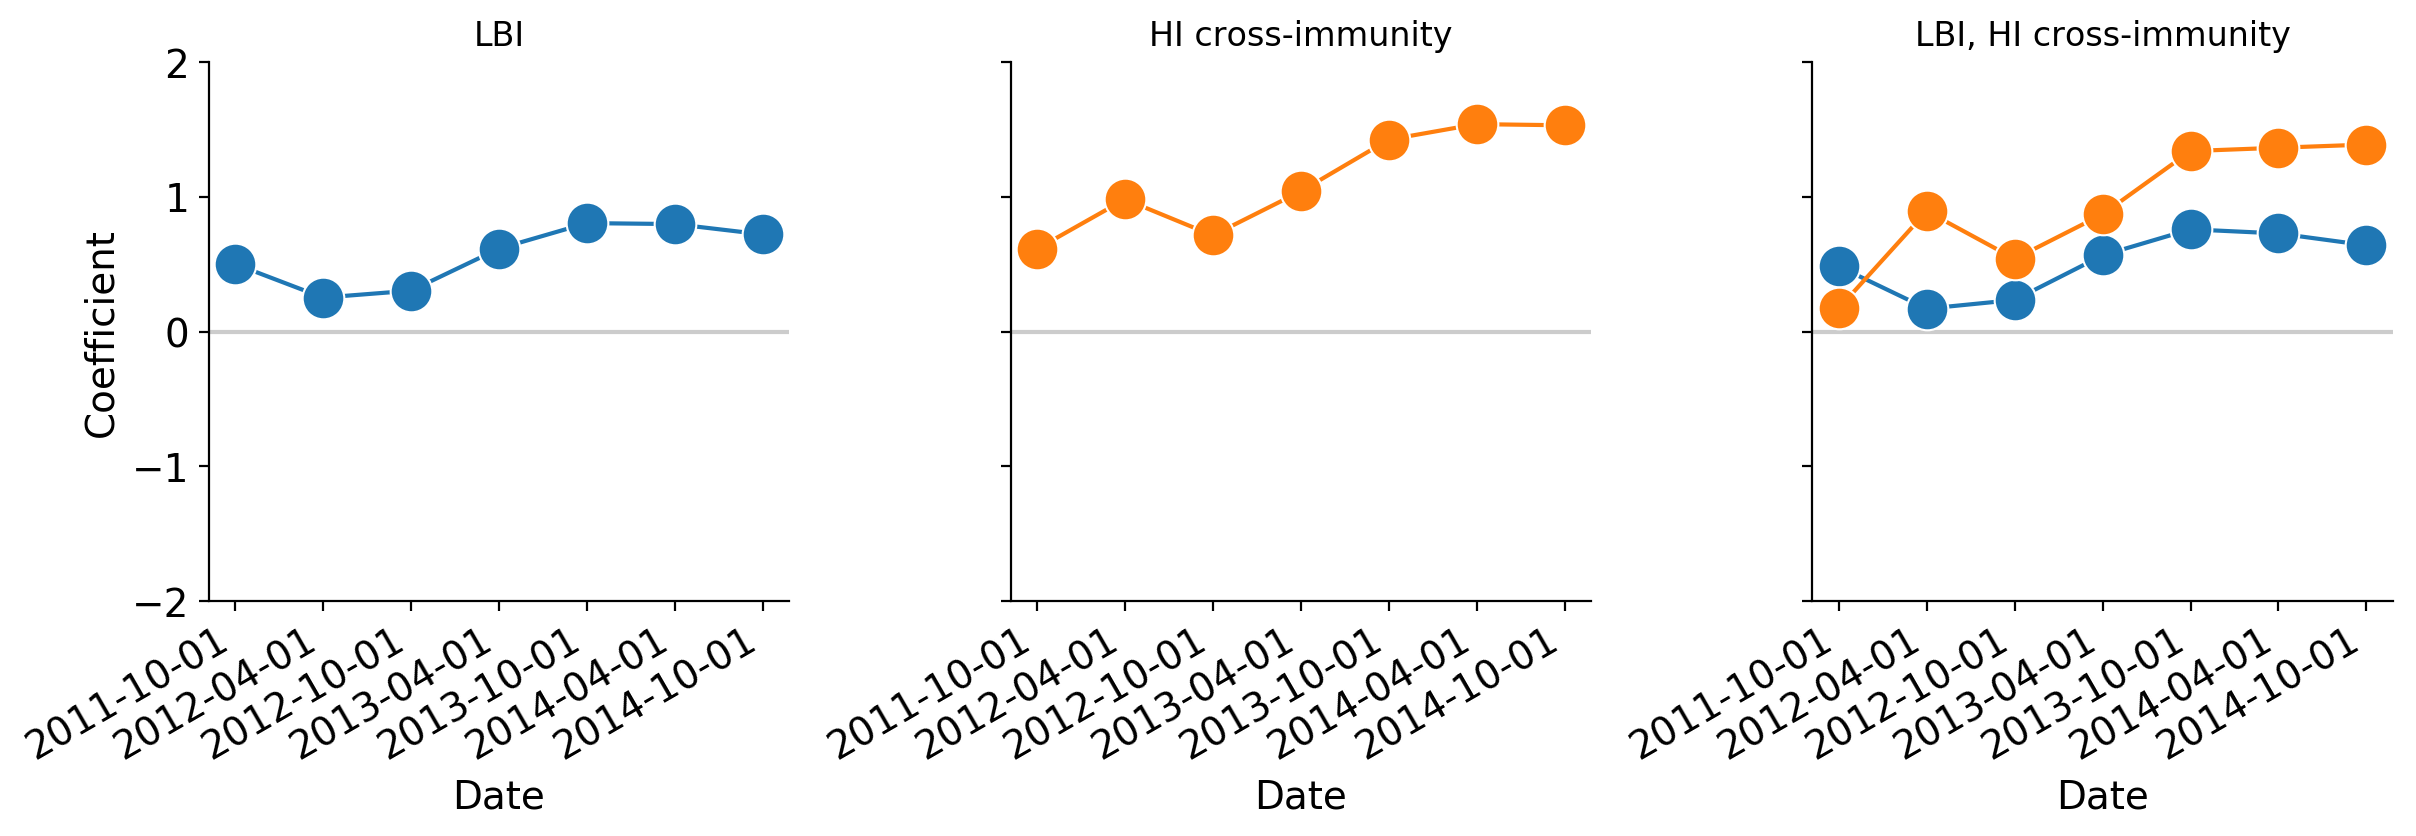

In [531]:
lbi_dfreq_order = ["lbi", "cTiterSub_x", "lbi-cTiterSub_x"]
lbi_dfreq_names = ["LBI", "HI cross-immunity", "LBI, HI cross-immunity"]
g = facet_time_plot(
    coefficients_by_time_df[coefficients_by_time_df["predictors"].isin(lbi_dfreq_order)],
    "coefficient",
    "Coefficient",
    timepoint_column="validation_timepoint",
    hue="predictor",
    col_order=lbi_dfreq_order
)

#g.set_titles("{col_name}")

for ci, ax in enumerate(g.axes.flatten()):
    ax.set_title(lbi_dfreq_names[ci], fontsize=12)
    ax.set_ylim(-2., 2.)